## Implémentation et extensions de Ada-FP pour le Reinforcement Learning

Alex Pierron \
Université Paris-Saclay \
M2 Mathématiques et Intelligence Artificielle 

Note: L'éxécution totale du Notebook peut prendre plusieurs minutes. Les générateurs aléatoires étant correctement configurés, il est recommandé de ne pas éxécuter le Notebook si l'objectif est d'accéder rapidemment aux résultats trouvés et proposés.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.pylab as pl
from matplotlib.colors import ListedColormap
import gymnasium as gym
from tqdm import tqdm
import pandas as pd
import time

## Rappel

Soit $d \geqslant 1, \mathrm{~F}: \mathbb{R}^d \rightarrow \mathbb{R}^d$ une application admettant un point fixe $x_* \in \mathbb{R}^d$, $\eta>0$, et $x_0 \in \mathbb{R}^d$.

Alors l'algorithme Ada-FP est donné par:
\begin{align}
\forall k \geqslant 0, \space x_{k+1} = x_k + \eta \frac{\mathrm{F} x_k - x_k}{\sqrt{\sum_{\ell=0}^k \left\| \mathrm{F} x_{\ell} - x_l \right\|_2^2}} \tag{Ada-FP} 
\end{align}


## Partie II: Comparaison en pratique avec les algorithmes classiques

### Labyrinthe

On réutilise le labyrinthe du TP1 dont on connait déjà le MDP. Les cellules suivantes sont directements issues de ce TP

#### Contexte

On modélise le problème par:
- un ensemble d'états $\mathcal{S}=\left\{ 1,\dots,n \right\}\times
  \left\{ 1,\dots,m \right\}$ qui correspond aux cellules,
- un ensemble d'actions $\mathcal{A}=\left\{ 0,1,2,3 \right\}$ qui correspondent respectivement à "bas", "droite", "haut", "gauche", et dont on utilisera parfois la représentation sous forme de vecteur,
- un ensemble de gains $\mathcal{R}=\left\{ 0,1 \right\}$
- un ensemble d'états appelés "murs intérieurs" $\mathcal{W}\subset \mathcal{A}$.

Les transitions sont toutes déterministes, et sont telles qu'on obtient un gain de 1 lorsqu'on se déplace vers la cellule d'arrivée depuis une cellule voisine, et un gain de 0 sinon. Si l'action choisie correspond à un déplacement non-autorisé (soit qu'il mène à l'extérieur du labyrinthe, soit qu'il mène vers un mur intérieur, soit que l'état actual est un mur intérieur), l'état reste inchangé.

On travaillera avec une valeur $\gamma=.9$ fixée.

La fonction suivante servira à représenter graphiquement le labyrinthe, les politiques, ainsi que les chemins empruntés par les politiques.

In [2]:
np.set_printoptions(precision=3)
%matplotlib inline

In [3]:
def plot(policy=None, path=False):
    grid_size = maze.shape
    fig, ax = plt.subplots(figsize=(grid_size[1]+1, grid_size[0]+1))
    im = ax.imshow(maze, cmap='Greys', interpolation='nearest', extent=[0, grid_size[1], 0, grid_size[0]], alpha=1)
    ax.set_xticks(np.arange(0, grid_size[1]+1, 1), minor=True)
    ax.set_yticks(np.arange(0, grid_size[0]+1, 1), minor=True)
    ax.grid(which="minor", color='black', linestyle='-', linewidth=1)
    ax.set_xticks([])
    ax.set_yticks([])
    if policy is not None:
        # Plot arrows
        for i in range(grid_size[0]):
            for j in range(grid_size[1]):
                action = policy[i, j]
                ax.text(j + 0.5, grid_size[0] - i - 0.5, action_arrows[action],
                        ha='center', va='center', fontsize=12, fontweight='bold')
        if path is True:
            cmap = pl.cm.Reds
            my_cmap = cmap(np.arange(cmap.N))
            my_cmap[:,-1] = np.linspace(0, 1, cmap.N)
            my_cmap = ListedColormap(my_cmap)

            im = ax.imshow(path_array(policy), cmap=my_cmap, interpolation='nearest', extent=[0, grid_size[1], 0, grid_size[0]], alpha=.5)
    plt.show()

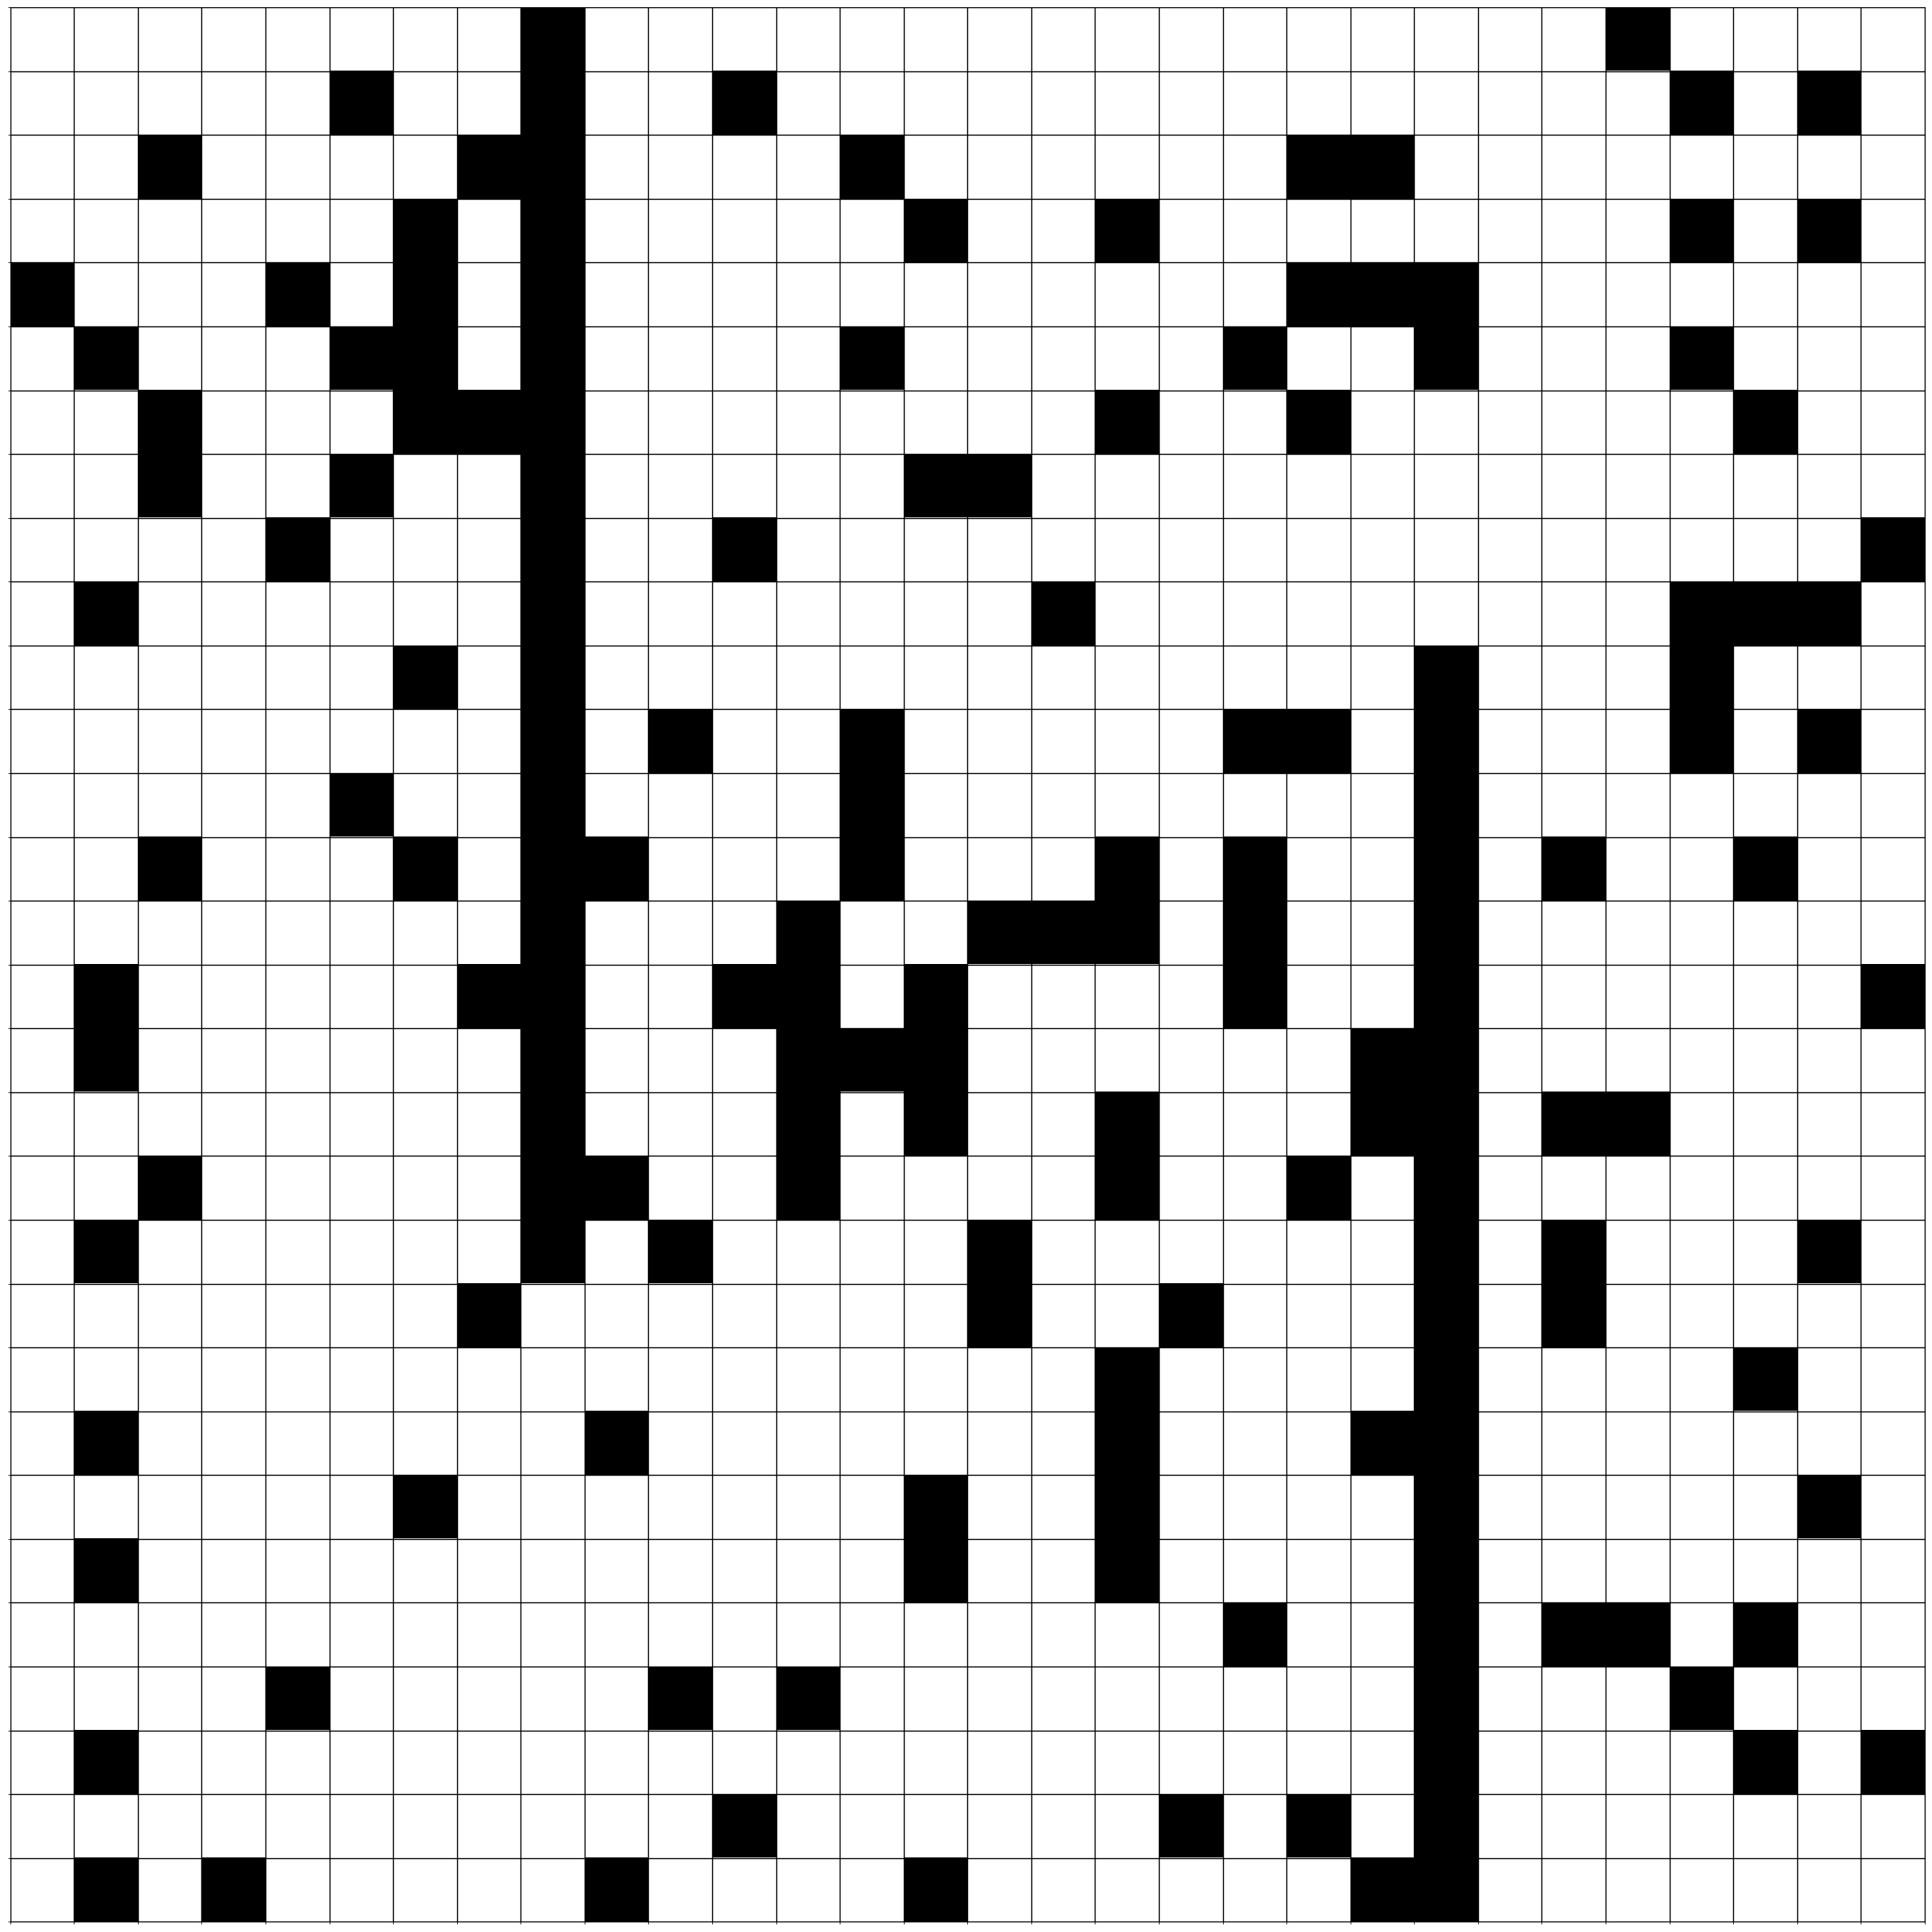

In [4]:
np.random.seed(496) #Seed à changer pour générer un nouveau labyrinthe

width = 30
height = 30
maze_size = (height, width) # nb lines & nb rows
start_cell = (0,0)
target_cell = (height-1, width-1)

maze = np.random.binomial(1, p=.15, size=maze_size)
maze[:round(2*width/3),round(height/4)] = 1
maze[round(width/3):,round(3*height/4)] = 1
chl = round(2*height/5)
chu = round(3*height/5)
cwl = round(2*width/5)
cwu = round(3*width/5)
maze[chl:chu,cwl:cwu] = np.random.binomial(1, p=.5, size=(chu-chl, cwu-cwl))
maze[start_cell] = 0
maze[target_cell] = 0
plot()

In [5]:
actions = [0,1,2,3]
action_coordinates = {0: np.array([1,0]),# down
                      1: np.array([0,1]), # right
                      2: np.array([-1,0]), # up
                      3: np.array([0,-1])} # left
action_arrows = ['↓', '→', '↑', '←']
gamma = .9

### Implémentation

On implémente les algorithmes $\text{Ada-VI}_{\pi}^{(V)}$ et $\text{Ada-VI}_{*}^{(V)}$ définit précédemment au cours de l'étude.\
On les compare respectivement à $\text{VI}_{\pi}^{(V)}$ et $\text{VI}_{*}^{(V)}$.

In [6]:
def transition(s,a):
    s_ = tuple(s + action_coordinates[a])

    if maze[s] == 1:
        return 0,s
    elif s_[1] == target_cell[1] and s_[0] == target_cell[0]:
        return 1,s_

    elif 0 <= s_[0] < maze_size[0] and 0 <= s_[1] < maze_size[1] and maze[s_] != 1:
        return 0,s_
    else:
        return 0,s
    
def B_pi(v, pi):
    v_ = np.zeros_like(v)
    for i in range(v.shape[0]):
        for j in range(v.shape[1]):
            s = (i,j)
            a = pi[s]
            r,s_ = transition(s,a)
            v_[s] = r + gamma * v[s_] 
    return v_

def B_star(v): 
    v_ = np.zeros_like(v)
    for i in range(v.shape[0]):
        for j in range(v.shape[1]):
            max_value = -np.inf
            for a in actions:
                s = (i,j)
                r,s_ = transition(s,a)
                value = r + gamma * v[s_[0],s[1]] 
                if value > max_value:
                    max_value = value
            v_[s] = max_value
    return v_

def greedy_policy(v):
    pi = np.zeros_like(v,dtype=int)
    for i in range(v.shape[0]):
        for j in range(v.shape[1]):
            max_value = -np.inf
            for a in actions:
                s = (i,j)
                r,s_ = transition(s,a)
                value = r + gamma * v[s_[0],s_[1]] 
                if value > max_value:
                    max_value = value
                    pi[s] = a
    return pi

def norm_inf_2d(a):
    """
    Norme infinie d'une matrice bidimensionnelle.
    """
    return np.max(np.absolute(a))

def comparatif_norm_vk(liste_vk, pi, function=B_pi):
    distances_returned = []

    if function == B_pi:
        distances_returned = [norm_inf_2d(v - function(v, pi)) for v in liste_vk]
    else:
        distances_returned = [norm_inf_2d(v - function(v)) for v in liste_vk]

    return distances_returned
    

In [7]:
import numpy as np

def VI_function(maze, function=B_pi, num_iterations=5000, seuil=1e-6, seed=42, print_metrics=False):
    """
    Paramètres :
    - maze (numpy.ndarray) : Représentation de l'espace d'état du labyrinthe.
    - function (fonction) : Fonction de valeur utilisée pour l'itération (B_pi ou B_star).
    - num_iterations (int) : Nombre maximal d'itérations à effectuer.
    - seuil (float) : Seuil d'arrêt indiquant la convergence lorsque la différence entre les itérations est inférieure à ce seuil.
    - seed (int) : Graine pour initialiser le générateur de nombres aléatoires.
    - print_metrics (bool) : Si True, affiche les métriques de convergence pendant l'exécution.

    Retourne :
    - distance (list) : Liste des distances maximales entre les itérations successives (VI).
    - distance_vpi (list) : Liste des distances maximales entre les itérations successives et v_pi (ou v_*).
    - v_pi (numpy.ndarray) : Fonction de valeur optimale obtenue à partir de l'itération.
    - liste_vk (list) : Liste des fonctions de valeur à chaque itération.
    - pi (numpy.ndarray) : Politique initiale choisie.
    """
    np.random.seed(seed)

    v = np.random.random(maze.shape)
    pi = greedy_policy(v)

    iter = 0
    epsilon = np.inf
    distance = []
    liste_vk = [v]
    Is_bpi = (function == B_pi)

    if print_metrics:
        print(f"Calcul de la valeur itérative (VI) pour {function}.")

    while epsilon > seuil and iter < num_iterations:
        # Calcul de la mise à jour de la fonction de valeur
        if Is_bpi:
            v_ = B_pi(v, pi)
        else:
            v_ = B_star(v)

        # Calcul de la différence maximale entre les itérations successives
        max_value = np.max(np.absolute(v - v_))

        # Stockage de la distance maximale dans la liste
        distance.append(max_value)

        # Mise à jour des variables pour la prochaine itération
        iter += 1
        v = np.copy(v_)
        liste_vk.append(v)
        epsilon = max_value

        # Affichage des métriques toutes les 100 itérations
        if iter % 100 == 0 and print_metrics:
            print('itérations : {:5d} , epsilon : {:3f}'.format(iter, epsilon), end='\r')

    # Affichage des métriques finales
    if print_metrics:
        print("\nNombre final d'itérations: ", iter)
        print("Distance finale :", epsilon)

    # Calcul de la fonction de valeur optimale v_pi
    v_pi = np.copy(v_)

    # Retrait de la dernière itération (valeur finale)
    liste_vk.pop()

    # Calcul de la distance entre chaque itération et v_pi
    distance_vpi = [np.max(np.absolute(v - v_)) for v in liste_vk]

    return distance, distance_vpi, v_pi, liste_vk, pi

In [8]:
import numpy as np

def Ada_VI_function(maze, function=B_pi, eta=1, num_iterations=2000, seuil=1e-4, seed=42, print_metrics=False):
    """
    Paramètres :
    - maze (numpy.ndarray) : Représentation de l'espace d'état du labyrinthe.
    - function (fonction) : Fonction de valeur utilisée pour l'itération (B_pi ou B_star).
    - eta (float) : Paramètre d'adaptation de l'échelle.
    - num_iterations (int) : Nombre maximal d'itérations à effectuer.
    - seuil (float) : Seuil d'arrêt indiquant la convergence lorsque la différence entre les itérations est inférieure à ce seuil.
    - seed (int) : Graine pour initialiser le générateur de nombres aléatoires.
    - print_metrics (bool) : Si True, affiche les métriques de convergence pendant l'exécution.

    Retourne :
    - distance (list) : Liste des distances maximales entre les itérations successives (Ada-VI).
    - distance_vpi (list) : Liste des distances maximales entre les itérations successives et v_pi (ou v_*).
    - v_pi (numpy.ndarray) : Fonction de valeur optimale obtenue à partir de l'itération.
    - liste_vk (list) : Liste des fonctions de valeur à chaque itération.
    - pi (numpy.ndarray) : Politique choisie.
    """
    
    np.random.seed(seed)
    v = np.random.random(maze.shape)
    pi = greedy_policy(v)
    v_ = np.zeros_like(v)
    iter = 0
    epsilon = np.inf
    distance = []
    Is_bpi = (function == B_pi)
    list_ul = []
    list_vk = [v]

    if print_metrics:
        print(f"Calcul de Ada-VI par composante pour {function} et eta = {eta}")

    while epsilon > seuil and iter < num_iterations:
        # Calcul de la mise à jour de la fonction de valeur avec adaptation de l'échelle
        if Is_bpi:
            intermediate = B_pi(v, pi)
        else:
            intermediate = B_star(v)

        u_l_i_j = np.linalg.norm(intermediate - v, ord=2)**2
        list_ul.append(u_l_i_j)
        v_ = v + eta * (intermediate - v) / (np.sqrt(sum(list_ul)))

        # Calcul de la différence maximale entre les itérations successives
        max_value = np.max(np.absolute(v - v_))

        # Stockage de la distance maximale dans la liste
        distance.append(max_value)

        # Mise à jour des variables pour la prochaine itération
        iter += 1
        v = np.copy(v_)
        list_vk.append(v)
        epsilon = max_value

        # Affichage des métriques toutes les 100 itérations
        if iter % 100 == 0 and print_metrics:
            print('itérations : {:5d} , epsilon : {:3f}'.format(iter, epsilon), end='\r')

    # Affichage des métriques finales
    if print_metrics:
        print("\nNombre final d'itérations:", iter)
        print("Distance finale :", epsilon)

    # Reconstruction de la distance || v_k - v_pi ||
    v_pi = np.copy(v_)  # Je prends le dernier v_k calculé comme étant v_pi (approximation)
    list_vk.pop()
    distance_vpi = [np.max(np.absolute(v - v_)) for v in list_vk]

    return distance, distance_vpi, v_pi, list_vk, pi

La cellule suivante permet de calculer $\text{Ada-VI}_{\pi}^{(V)}$ et $\text{Ada-VI}_{*}^{(V)}$  pour plusieurs valeurs de $\eta$ et ainsi observer plus en profondeur ce qu'il se passe en allant analyser les différentes données.

In [9]:
%time result_ada_pi_eta_1 = Ada_VI_function(maze, function=B_pi)
%time result_ada_star_eta_1 = Ada_VI_function(maze, function=B_star)

%time result_ada_pi_eta_10 = Ada_VI_function(maze, function=B_pi, eta=10)
%time result_ada_star_eta_10 = Ada_VI_function(maze, function=B_star, eta=10)

%time result_ada_pi_eta_100 = Ada_VI_function(maze, function=B_pi, eta=100)
%time result_ada_star_eta_100 = Ada_VI_function(maze, function=B_star, eta=100)

%time result_ada_pi_eta_1000 = Ada_VI_function(maze, function=B_pi, eta=1000)
%time result_ada_star_eta_1000 = Ada_VI_function(maze, function=B_star, eta=1000)

CPU times: total: 1.12 s
Wall time: 2.3 s
CPU times: total: 4.83 s
Wall time: 8.28 s
CPU times: total: 46.9 ms
Wall time: 232 ms
CPU times: total: 359 ms
Wall time: 934 ms
CPU times: total: 15.6 ms
Wall time: 281 ms
CPU times: total: 438 ms
Wall time: 1.44 s
CPU times: total: 156 ms
Wall time: 381 ms
CPU times: total: 531 ms
Wall time: 1.93 s


Pour chaque algorithme, on supposera que $v_\pi$ et $v_*$ sont les dernières valeurs atteintes.
On note $v_{\pi}$ et $v_{*}$ les estimations obtenues en utilisant $\text{VI}_\pi^{(\mathrm{V})}$ et $\text{VI}_*^{(\mathrm{V})}$.
On note $v_{\pi_{\text{Ada}_\pi}}$ et $v_{*_{\text{Ada}_*}}$ les estimations obtenues en utilisant $\text{Ada-VI}_\pi^{(\mathrm{V})}$ et $\text{Ada-VI}_*^{(\mathrm{V})}$.

La fonction suivante permet d'afficher les courbes des distances suivantes:
\begin{align}
\left\|v_k-v_{k+1}\right\|_{\infty}
\tag{d.modele}
\end{align}

\begin{align}
\left\|v_k-\mathrm{B}_\pi v_k \right\|_{\infty} ( \text{ resp } \left\|v_k-\mathrm{B}_* v_k\right\|_{\infty}) \text{ pour } \text{Ada-VI}_\pi^{(\mathrm{V})} ( \text{ resp } \text{Ada-VI}_*^{(\mathrm{V})}) \tag{d.bpi, d.b*}
\end{align}

\begin{align}
\left\|v_k-v_\pi\right\|_{\infty} ( \text{ resp } \left\|v_k-v_*\right\|_{\infty}) \tag{d.vpi, d.v*}
\end{align}

\begin{align}
\left\|v_k-v_{\pi_{\text{Ada}_\pi}}\right\|_{\infty} ( \text{ resp } \left\|v_k-v_{*_{\text{Ada}_*}}\right\|_{\infty}) \tag{d.adapi, d.ada*}
\end{align}

 Ces distances seront affichées pour chacun des algorithmes ($\text{VI}_\pi^{(\mathrm{V})}$, $\text{VI}_*^{(\mathrm{V})}$, $\text{Ada-VI}_\pi^{(\mathrm{V})}$ et $\text{Ada-VI}_*^{(\mathrm{V})}$) testés et pour chaque valeur de $\eta$ choisie.


In [10]:
from tqdm import tqdm
def plot_results(maze,etas, ada_function = Ada_VI_function, num_iterations = 2000,seuil=1e-4, seed = 42, print_metrics = False):
    """
    Visualise et compare la convergence de deux variations des algorithmes d'itération de la valeur (VI), à savoir VI_pi et VI_star,
    ainsi que de leurs versions adaptatives Ada_VI_pi et Ada_VI_star, pour une gamme de paramètres d'exploration donnés (etas).

    Paramètres :
    - maze (Maze) : L'environnement du labyrinthe sur lequel les algorithmes sont appliqués.
    - etas (list) : Une liste de paramètres d'exploration à tester.
    - ada_function(function): Variante de Ada-FP à utiliser. Par défaut : Ada_VI_function
    - num_iterations (int) : Nombre d'itérations à effectuer pour chaque algorithme. Par défaut : 5000.
    - seuil (float) : Seuil de convergence pour arrêter les itérations. Par défaut : 1e-6.
    - seed (int) : Graine pour la génération de nombres aléatoires en vue de la reproductibilité. Par défaut : 42.
    - print_metrics (bool) : Si True, affiche les métriques de convergence pendant l'exécution.

    Renvoie :
    None

    La fonction génère des graphiques comparant le comportement de convergence de VI_pi, VI_star, Ada_VI_pi et Ada_VI_star
    par rapport aux paramètres d'exploration spécifiés (etas). Les graphiques montrent les distances logarithmiques entre
    les itérations et la fonction de valeur optimale, ainsi qu'entre les itérations et la fonction de valeur de la politique.
    """
    
    result_VI_pi = VI_function(maze, function=B_pi,num_iterations=num_iterations , seuil=seuil,  seed = seed, print_metrics = print_metrics)
    result_VI_star = VI_function(maze, function=B_star,num_iterations=num_iterations, seuil = seuil , seed = seed, print_metrics = print_metrics)

    if ada_function == Ada_VI_function:
        en_tete_pi ="Ada-VI_pi"
        en_tete_star = "Ada-VI_*"
    elif ada_function == Ada_VI_composante:
        en_tete_pi ="Ada-VI_Compos_pi"
        en_tete_star = "Ada-VI_Compos_*"

    for eta in tqdm(etas, desc="Processing etas",position=0):
        
        result_ada_pi = ada_function(maze, function=B_pi, eta=eta, seuil = seuil, seed=seed,
                                     num_iterations=num_iterations, print_metrics = print_metrics)
        
        result_ada_star = ada_function(maze, function=B_star, eta=eta, seuil = seuil,seed=seed,
                                       num_iterations=num_iterations, print_metrics = print_metrics)

        distance_pi, distance_vpi_pi, vpi_pi, liste_vk_pi, pi_pi = result_ada_pi
        distance_star, distance_vpi_star, vpi_star, liste_vk_star, pi_star = result_ada_star

        distance_bpi_ada_pi = comparatif_norm_vk(liste_vk_pi,pi_pi,function = B_pi)
        distance_b_star_ada_star = comparatif_norm_vk(liste_vk_star,pi_star,function = B_star)

        distance_vpi_ada_pi = [[norm_inf_2d(v - result_VI_pi[-3]) for v in liste_vk_pi]]
        distance_v_star_ada_star = [[norm_inf_2d(v - result_VI_star[-3]) for v in liste_vk_star]]

        plt.figure(figsize=(20, 8))
        print(f'Distance finale entre v_pi estimée par VI et v_pi estimée par {en_tete_pi } pour eta = {eta} : {norm_inf_2d(vpi_pi - result_VI_pi[2])}')
        print(f'Distance finale entre v_* estimée par VI et v_* estimée par {en_tete_star } pour eta = {eta} : {norm_inf_2d(vpi_star - result_VI_star[2])}')         
        # Plot pour B_pi
        plt.subplot(2, 2, 1)
        iterations_pi = range(1, len(distance_pi) + 1)
        plt.plot(iterations_pi, distance_pi, label=f'{en_tete_pi}: d.modele')
        plt.plot(iterations_pi, distance_vpi_pi, label=f'{en_tete_pi}: d.adapi')
        plt.plot(range(1, len(result_VI_pi[0]) + 1 ), result_VI_pi[0], label=f'VI_pi: d.modele')
        plt.plot(range(1, len(result_VI_pi[0]) + 1), result_VI_pi[1], label=f'VI_pi: d.vpi')
        plt.yscale('log')
        plt.title(f'D.modele et D.adapi pour {en_tete_pi} et eta = {eta}')
        plt.xlabel('Iterations')
        plt.ylabel('Distance log')
        plt.legend()

        plt.subplot(2, 2, 3)
        iterations_pi = range(1, len(distance_pi) + 1)
        plt.plot(iterations_pi, distance_bpi_ada_pi, label=f'{en_tete_pi}: d.bpi')
        plt.plot(iterations_pi, distance_vpi_ada_pi[0], label=f'{en_tete_pi}: d.vpi')
        plt.plot(range(1, len(result_VI_pi[0]) + 1 ), result_VI_pi[0], label=f'VI_pi: d.modele')
        plt.plot(range(1, len(result_VI_pi[0]) + 1), result_VI_pi[1], label=f'VI_pi: d.vpi')
        plt.yscale('log')
        plt.title(f'd.bpi et d.vpi pour {en_tete_pi} et eta = {eta}')
        plt.xlabel('Iterations')
        plt.ylabel('Distance log')
        plt.legend()

        # Plot pour B_star
        plt.subplot(2, 2, 2)
        iterations_star = range(1, len(distance_star) + 1)
        plt.plot(iterations_star, distance_star, label=f'{en_tete_star}: d.modele')
        plt.plot(iterations_star, distance_vpi_star, label=f'{en_tete_star}: d.ada*')
        plt.plot(range(1, len(result_VI_star[0]) +1 ), result_VI_star[0], label=f'VI_*: d.modele')
        plt.plot(range(1, len(result_VI_star[0]) +1), result_VI_star[1], label=f'VI_*: d.v*')
        plt.yscale('log')
        plt.title(f'd.modele et d.ada* pour {en_tete_star} et eta = {eta}')
        plt.xlabel('Iterations')
        plt.ylabel('Distance log')
        plt.legend()

        plt.subplot(2, 2, 4)
        iterations_star = range(1, len(distance_star) + 1)
        plt.plot(iterations_star, distance_b_star_ada_star, label=f'{en_tete_star}: d.b*')
        plt.plot(iterations_star, distance_v_star_ada_star[0], label=f'{en_tete_star}: d.v*')
        plt.plot(range(1, len(result_VI_pi[0]) + 1 ), result_VI_pi[0], label=f'VI_pi: d.modele')
        plt.plot(range(1, len(result_VI_pi[0]) + 1), result_VI_pi[1], label=f'VI_pi: d.v*')
        plt.yscale('log')
        plt.title(f'd.b* et d.v* pour {en_tete_star} et eta = {eta}')
        plt.xlabel('Iterations')
        plt.ylabel('Distance log')
        plt.legend()

        plt.tight_layout()
        plt.show()
    pass

Processing etas:   0%|          | 0/5 [00:00<?, ?it/s]

Distance finale entre v_pi estimée par VI et v_pi estimée par Ada-VI_pi pour eta = 0.001 : 5.238150122107791
Distance finale entre v_* estimée par VI et v_* estimée par Ada-VI_* pour eta = 0.001 : 9.970681648340209


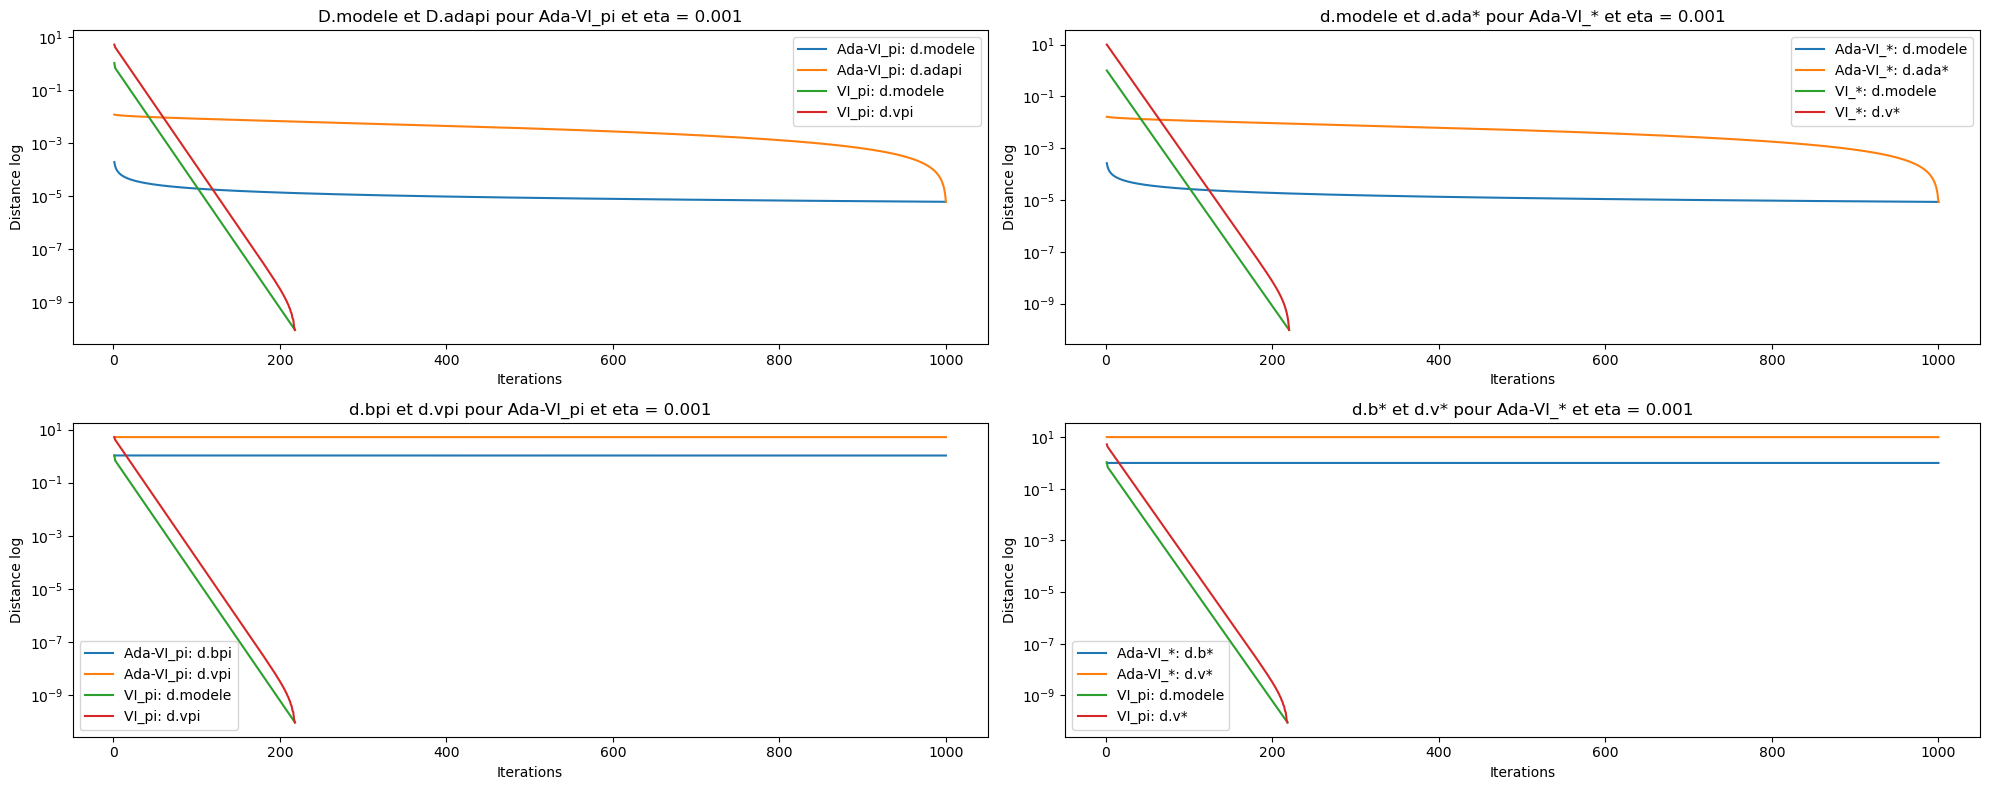

Processing etas:  20%|██        | 1/5 [00:43<02:53, 43.25s/it]

Distance finale entre v_pi estimée par VI et v_pi estimée par Ada-VI_pi pour eta = 0.1 : 3.8320535084269833
Distance finale entre v_* estimée par VI et v_* estimée par Ada-VI_* pour eta = 0.1 : 7.370242666384554


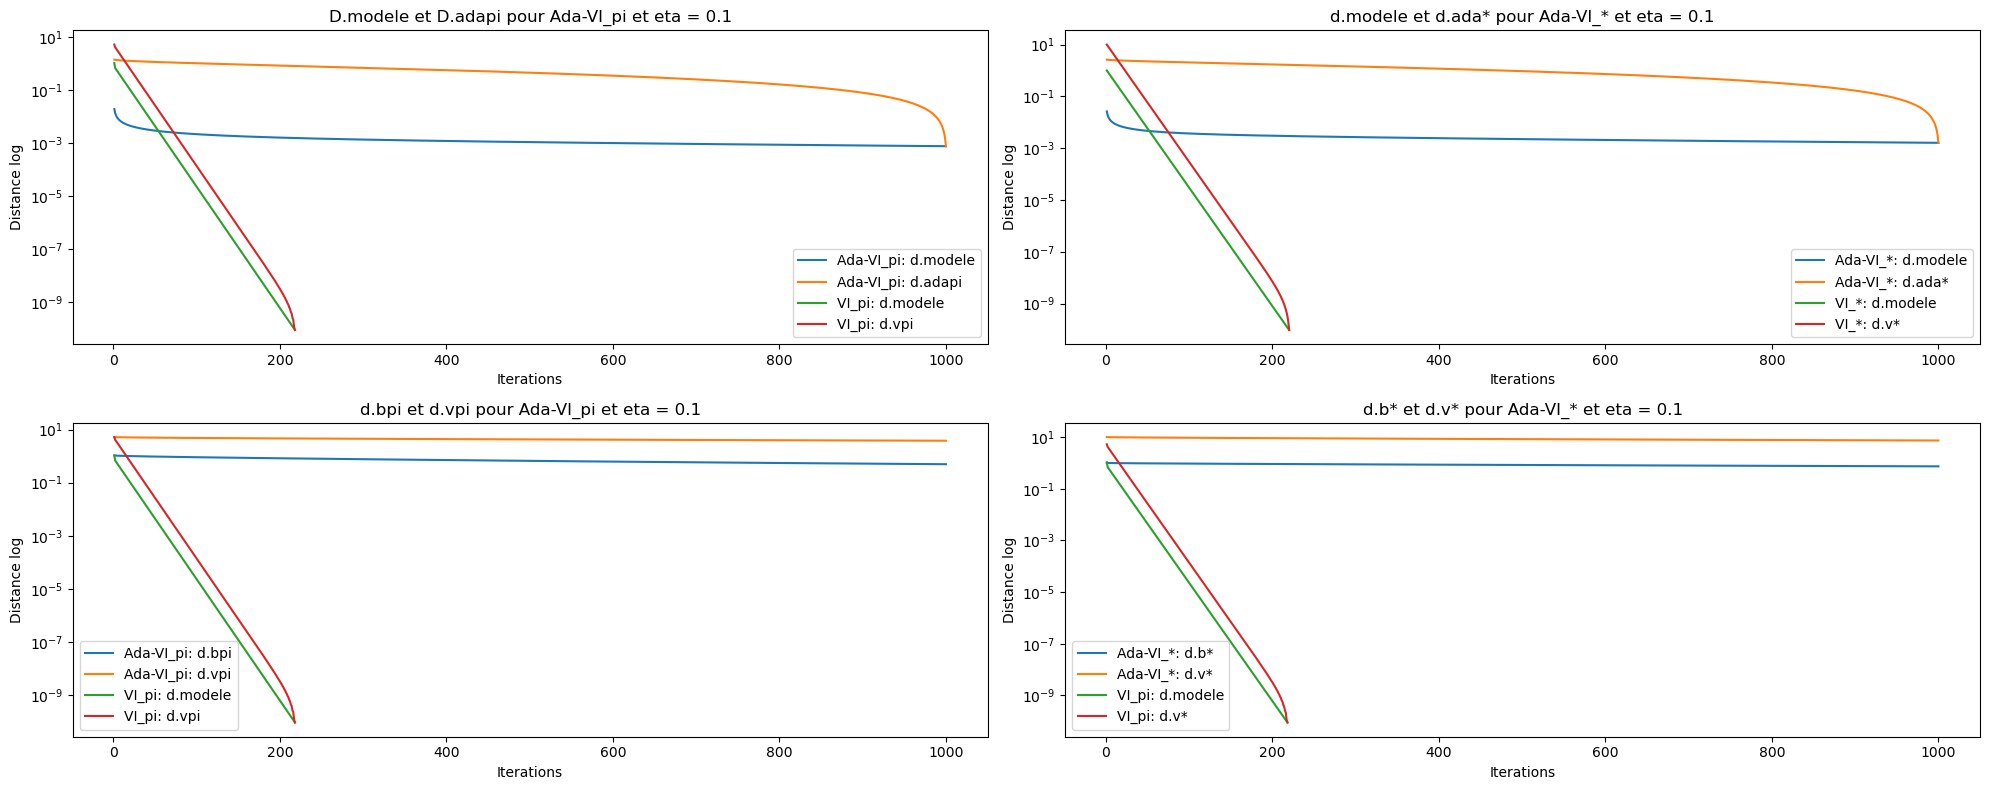

Processing etas:  40%|████      | 2/5 [01:19<01:57, 39.26s/it]

Distance finale entre v_pi estimée par VI et v_pi estimée par Ada-VI_pi pour eta = 1 : 0.00792113946253803
Distance finale entre v_* estimée par VI et v_* estimée par Ada-VI_* pour eta = 1 : 0.006326962318848217


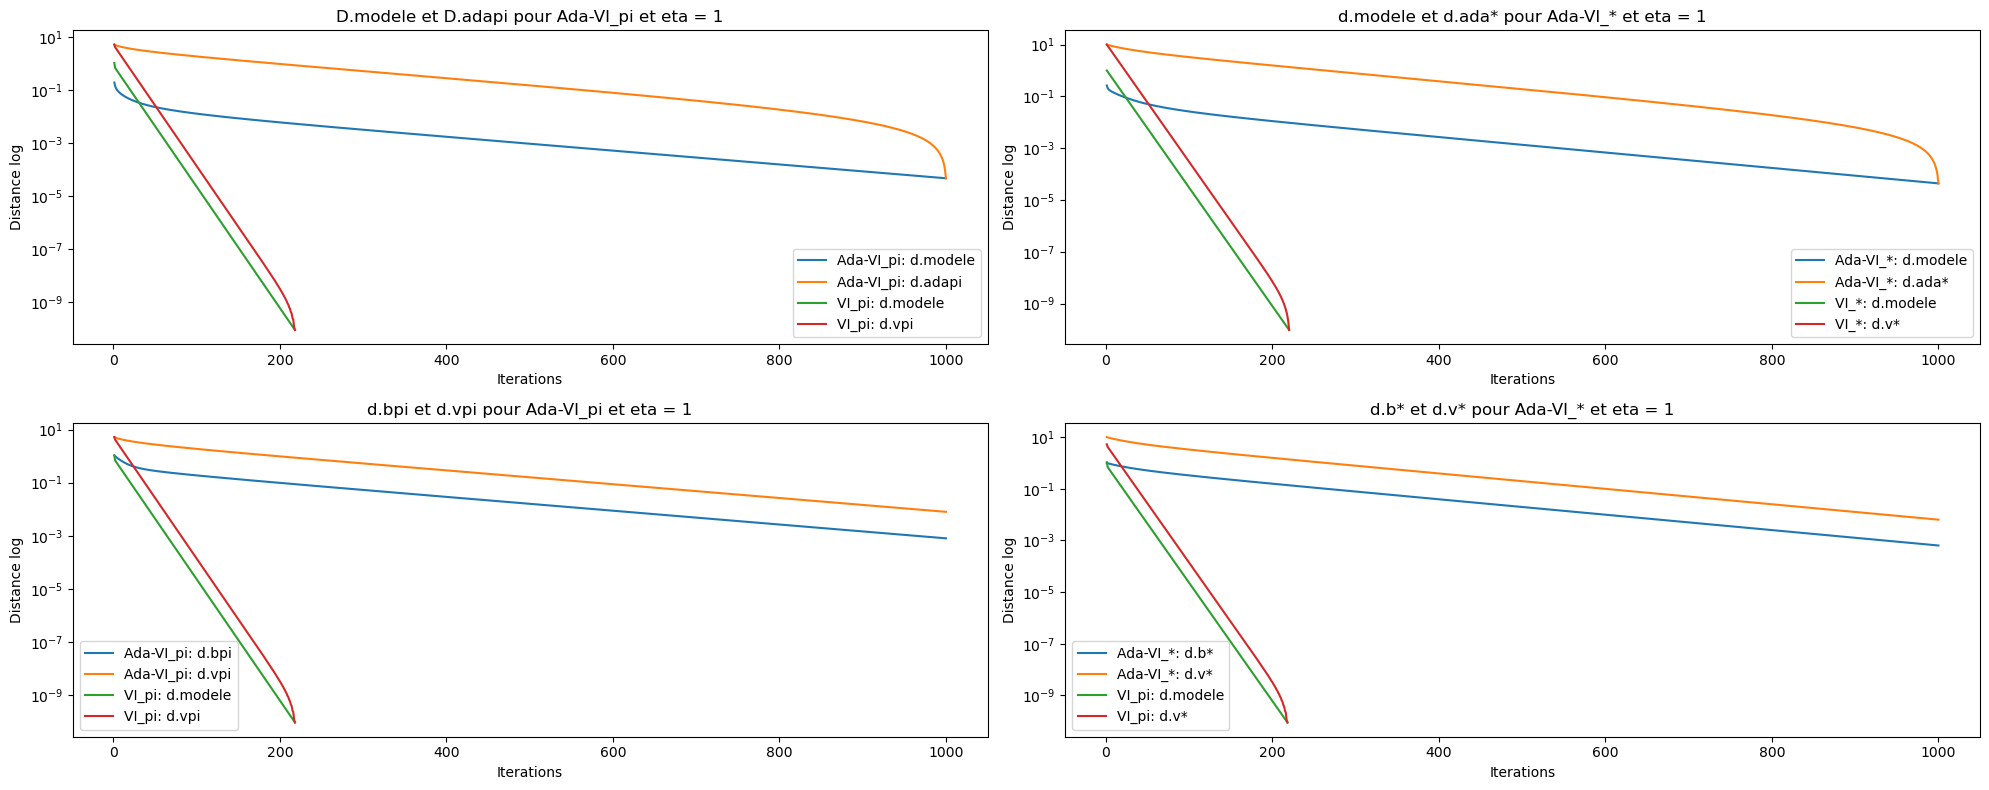

Processing etas:  60%|██████    | 3/5 [02:02<01:21, 40.65s/it]

Distance finale entre v_pi estimée par VI et v_pi estimée par Ada-VI_pi pour eta = 10 : 6.229958771086785e-10
Distance finale entre v_* estimée par VI et v_* estimée par Ada-VI_* pour eta = 10 : 2.869279641649676e-10


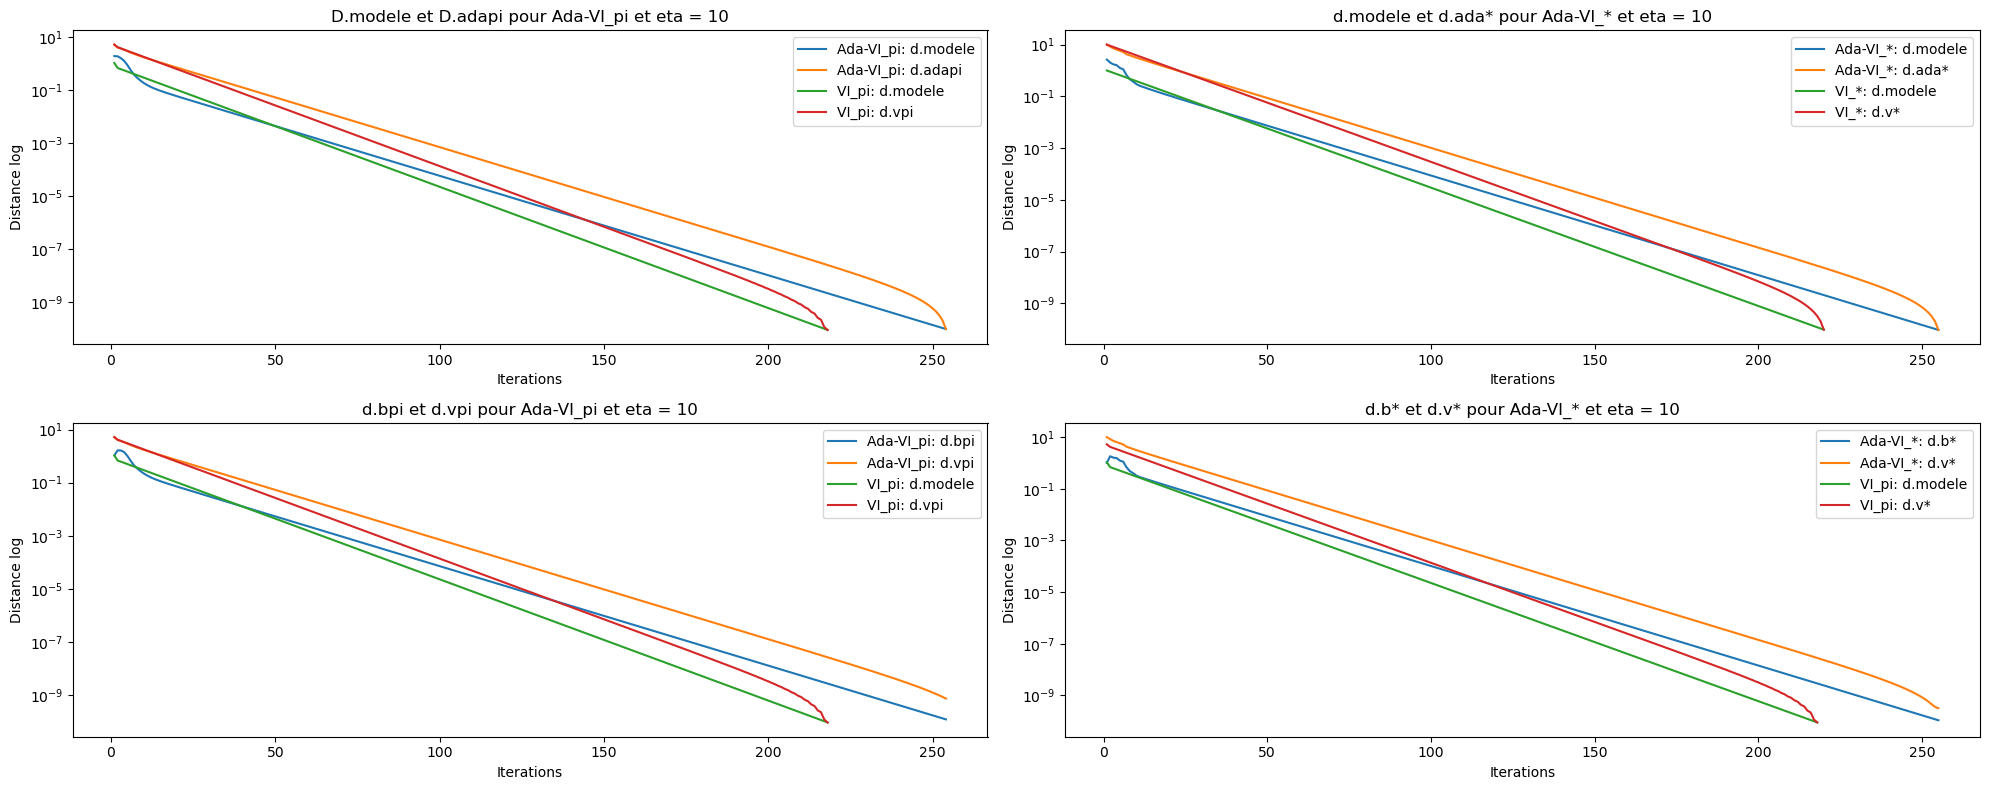

Processing etas:  80%|████████  | 4/5 [02:15<00:29, 29.86s/it]

Distance finale entre v_pi estimée par VI et v_pi estimée par Ada-VI_pi pour eta = 1000 : 1.6224808163656235e-09
Distance finale entre v_* estimée par VI et v_* estimée par Ada-VI_* pour eta = 1000 : 2.2742225880278966e-09


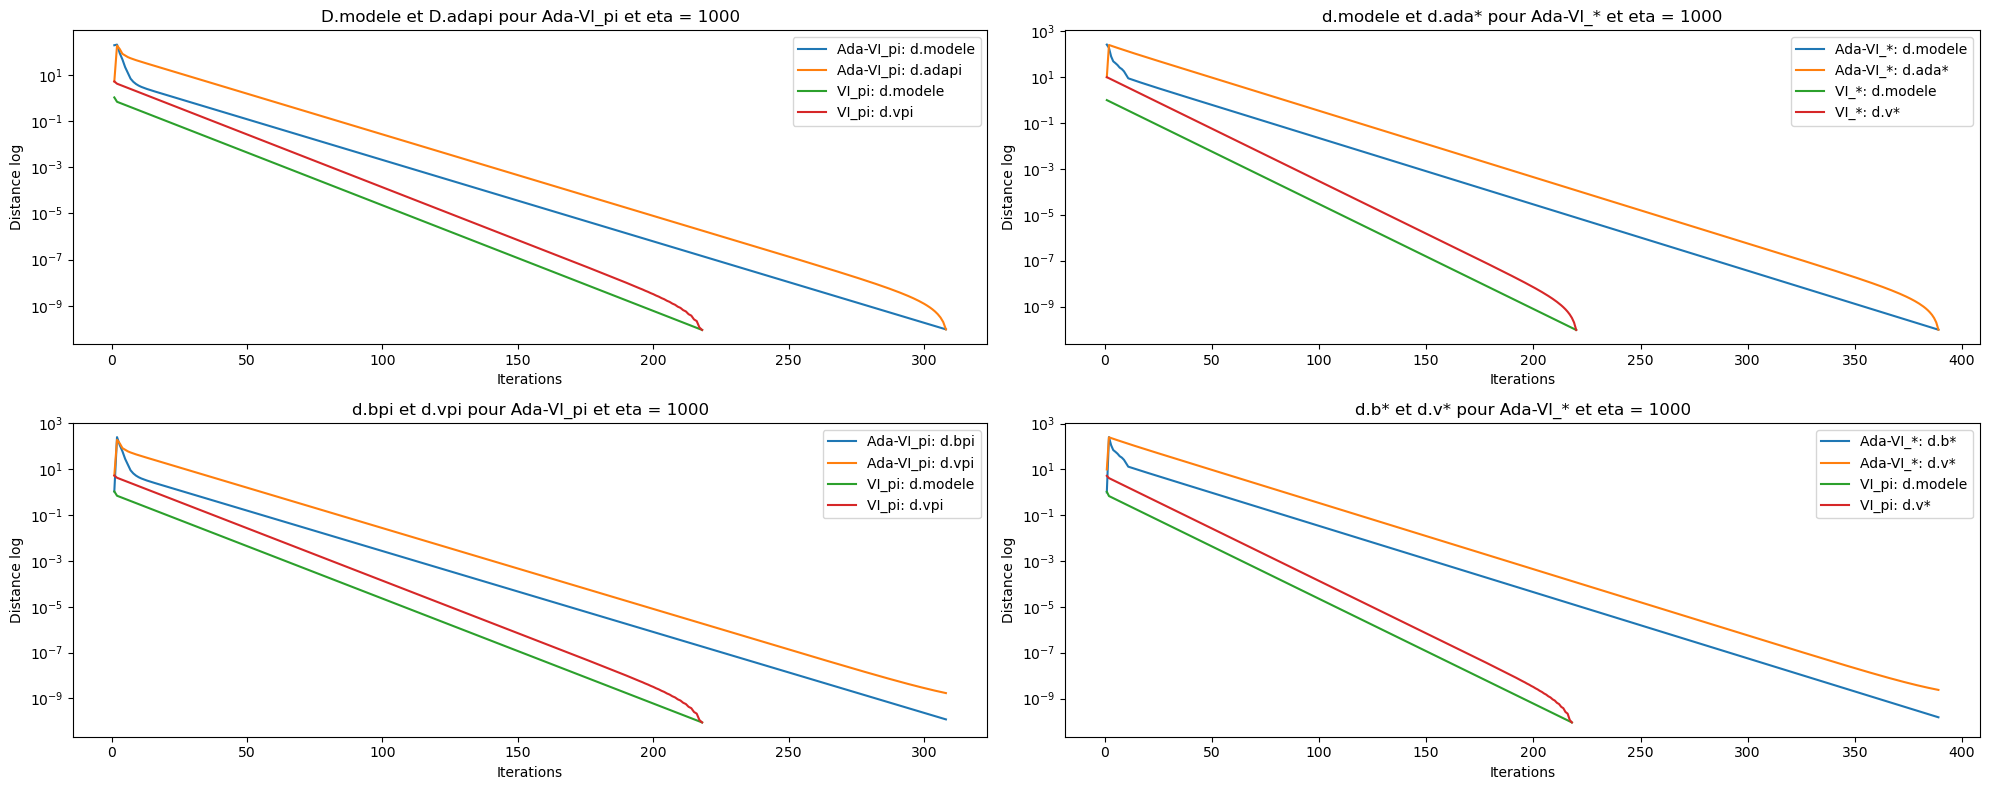

Processing etas: 100%|██████████| 5/5 [02:32<00:00, 30.42s/it]


In [11]:
# Appel de la fonction avec les valeurs d'eta que l'on souhaite tester
etas = [ 1e-3, 0.1, 1, 10 ,1000]
plot_results(maze,etas, ada_function=Ada_VI_function,seuil=1e-10,num_iterations=1000)

Pour ce MDP très simple, on constate que les algorithmes classiques sont au moins aussi efficace et on note une grande dépendance du comportement des algorithmes $\text{Ada-VI}_\pi^{(\mathrm{V})}$ et $\text{Ada-VI}_*^{(\mathrm{V})}$ par rapport à l'hyperparamètre $\eta$. Lorsque $\eta$ n'est pas correctement calibré, ici pour $\eta = 0.001$ par exemple, alors on constate que l'algorithme ne converge pas suffisamment vers le point fixe.

Lorsque $\eta$ est correctement calibré, ici pour $\eta = 10$, alors on obtient une convergence satisfaisante et un point fixe final très proche de celui obtenu par les algorithmes $\text{VI}_\pi^{(\mathrm{V})}$ et $\text{VI}_*^{(\mathrm{V})}$.Toutefois le coût computationnel de $\text{Ada-VI}_\pi^{(\mathrm{V})}$ et $\text{Ada-VI}_*^{(\mathrm{V})}$ est nettement plus élevée pour un nombre d'itérations égal, ce qui tends à favoriser les algorithmes $\text{VI}_\pi^{(\mathrm{V})}$ et $\text{VI}_*^{(\mathrm{V})}$ pour ce cas de figure.

Nous avons traité ici un MDP très simpliste dont on connait déjà très bien les transitions et même la politique optimale.
\
Par conséquent nous allons traiter dans la suite un MDP plus complexe, le jeu du blackjack. Cette démarche étant  plus difficile, elle sera proposée en extension supplémentaire de cette étude, au sein d'une partie IV bonus.

## Partie III: Extensions

Cette partie traite des extensions implémentées et étudiées pour le MDP du labyrinthe.

### (Ada-FP) définie composante par composante

On implémentes l'algorithme Ada-FP_Composante et qui est définie par:
$$x_{k+1, j}=x_{k, j}+\eta \frac{\left(\mathrm{F} x_k\right)_j-x_{k, j}}{\sqrt{\sum_{\ell=0}^k\left(\mathrm{~F}\left(x_{\ell}\right)_j-x_{\ell, j}\right)^2}}, \quad 1 \leqslant j \leqslant d, \quad k \geqslant 0 .$$

On réutilise les algorithmes $\text{Ada-VI}_{\pi}^{(V)}$ et $\text{Ada-VI}_{*}^{(V)}$ avec cette variante, on définit ainsi 
$ \text{Ada-VI-Comp}_{\pi}^{(V)}$ et $ \text{Ada-VI-Comp}_{*}^{(V)}$ par:
\begin{align} 
v_{k+1, j}=v_{k, j}+\eta \frac{\left(\mathrm{B}_\pi v_k\right)_j-v_{k, j}}{\sqrt{\sum_{\ell=0}^k\left(\mathrm{~B}_\pi\left(x_{\ell}\right)_j-v_{\ell, j}\right)^2}}, \quad 1 \leqslant j \leqslant d, \quad k \geqslant 0 \quad \text{Ada-VI-Comp}_{\pi}^{(V)}
\end{align}

\begin{align} 
v_{k+1, j}=v_{k, j}+\eta \frac{\left(\mathrm{B}_* v_k\right)_j-v_{k, j}}{\sqrt{\sum_{\ell=0}^k\left(\mathrm{~B}_*\left(x_{\ell}\right)_j-v_{\ell, j}\right)^2}}, \quad 1 \leqslant j \leqslant d, \quad k \geqslant 0 \quad \text{Ada-VI-Comp}_{*}^{(V)}
\end{align}

In [12]:
import numpy as np

def Ada_VI_composante(maze, function=B_pi, eta=1, num_iterations=2000, seuil=1e-6, seed=42, print_metrics=False):
    """
    Approxime la valeur itérative (VI) avec adaptation de l'échelle par composante (Ada-VI) pour une fonction de valeur donnée.

    Paramètres :
    - maze (numpy.ndarray) : L'espace d'état représentant le labyrinthe.
    - function (fonction) : La fonction de valeur utilisée pour l'itération (B_pi ou B_star).
    - eta (float) : Le paramètre d'adaptation de l'échelle.
    - num_iterations (int) : Le nombre maximum d'itérations à effectuer.
    - seuil (float) : Le seuil d'arrêt, indiquant la convergence lorsque la différence entre les itérations est inférieure à ce seuil.
    - seed (int) : La graine pour initialiser le générateur de nombres aléatoires.
    - print_metrics (bool) : Si True, affiche les métriques de convergence pendant l'exécution.

    Retourne :
    - distance (list) : Liste des distances maximales entre les itérations successives (Ada-VI_Composante).
    - distance_vpi (list) : Liste des distances maximales entre les itérations successives et (v_pi) (resp v_*).
    - eta (float) : La valeur finale du paramètre d'adaptation de l'échelle.
    """

    np.random.seed(seed)
    v = np.random.random(maze.shape)
    pi = greedy_policy(v)
    v_ = np.zeros_like(v)
    iter = 0
    epsilon = np.inf
    distance = []
    Is_bpi = (function == B_pi)
    list_ul = [[[] for _ in range(v.shape[0])] for _ in range(v.shape[1])]
    list_vk = [v]

    if print_metrics:
        print(f"Calcul de Ada-VI par composante pour {function} et eta = {eta}")

    while epsilon > seuil and iter < num_iterations:
        # Calcul de la mise à jour de la fonction de valeur avec adaptation de l'échelle par composante
        if Is_bpi:
            intermediate = B_pi(v, pi)
            for i in range(v.shape[0]):
                for j in range(v.shape[1]):
                    u_l_i_j = (intermediate[i][j] - v[i][j])**2
                    list_ul[i][j].append(u_l_i_j)
                    v_[i][j] = v[i][j] + eta * (intermediate[i][j] - v[i][j]) / (np.sqrt(sum(list_ul[i][j])))
        else:
            intermediate = B_star(v)
            for i in range(v.shape[0]):
                for j in range(v.shape[1]):
                    u_l_i_j = (intermediate[i][j] - v[i][j])**2
                    list_ul[i][j].append(u_l_i_j)
                    v_[i][j] = v[i][j] + eta * (intermediate[i][j] - v[i][j]) / (np.sqrt(sum(list_ul[i][j])))

        # Calcul de la différence maximale entre les itérations successives
        max_value = norm_inf_2d(v-v_)

        # Stockage de la distance maximale dans la liste
        distance.append(max_value)

        # Mise à jour des variables pour la prochaine itération
        iter += 1
        v = np.copy(v_)
        list_vk.append(v)
        epsilon = max_value

        # Affichage des métriques toutes les 100 itérations
        if iter % 100 == 0 and print_metrics:
            print('iter : {:5d} , epsilon : {:3f}'.format(iter, epsilon), end='\r')

    # Affichage des métriques finales
    if print_metrics:
        print("\nNombre final d'itérations:", iter)
        print("Distance finale :", epsilon)

    # Reconstruction de la distance || v_k - v_pi ||
    v_pi = np.copy(v_)  # Je prends le dernier v_k calculé comme étant v_pi (approximation)
    list_vk.pop()
    distance_vpi = [norm_inf_2d(v - v_pi) for v in list_vk]

    return distance, distance_vpi, v_pi, list_vk, pi

Processing etas:   0%|          | 0/5 [00:00<?, ?it/s]

Distance finale entre v_pi estimée par VI et v_pi estimée par Ada-VI_Compos_pi pour eta = 0.001 : 5.20690370178108
Distance finale entre v_* estimée par VI et v_* estimée par Ada-VI_Compos_* pour eta = 0.001 : 9.94374774973053


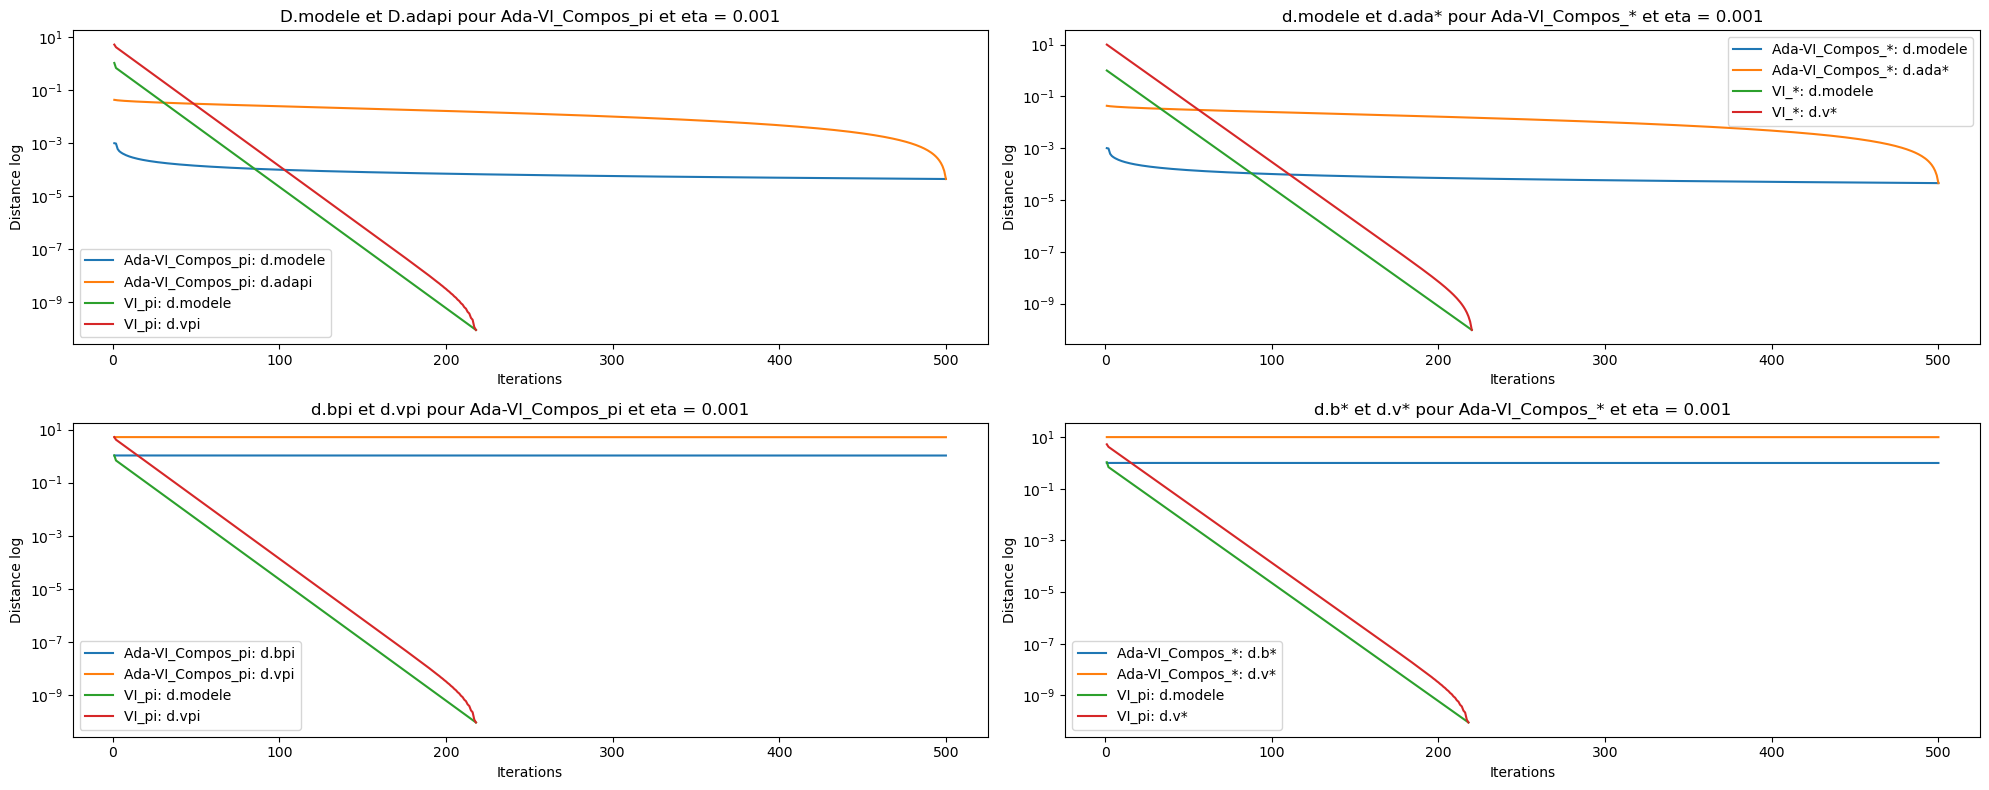

Processing etas:  20%|██        | 1/5 [00:31<02:06, 31.68s/it]

Distance finale entre v_pi estimée par VI et v_pi estimée par Ada-VI_Compos_pi pour eta = 0.1 : 1.55081735433417
Distance finale entre v_* estimée par VI et v_* estimée par Ada-VI_Compos_* pour eta = 0.1 : 6.036750450453548


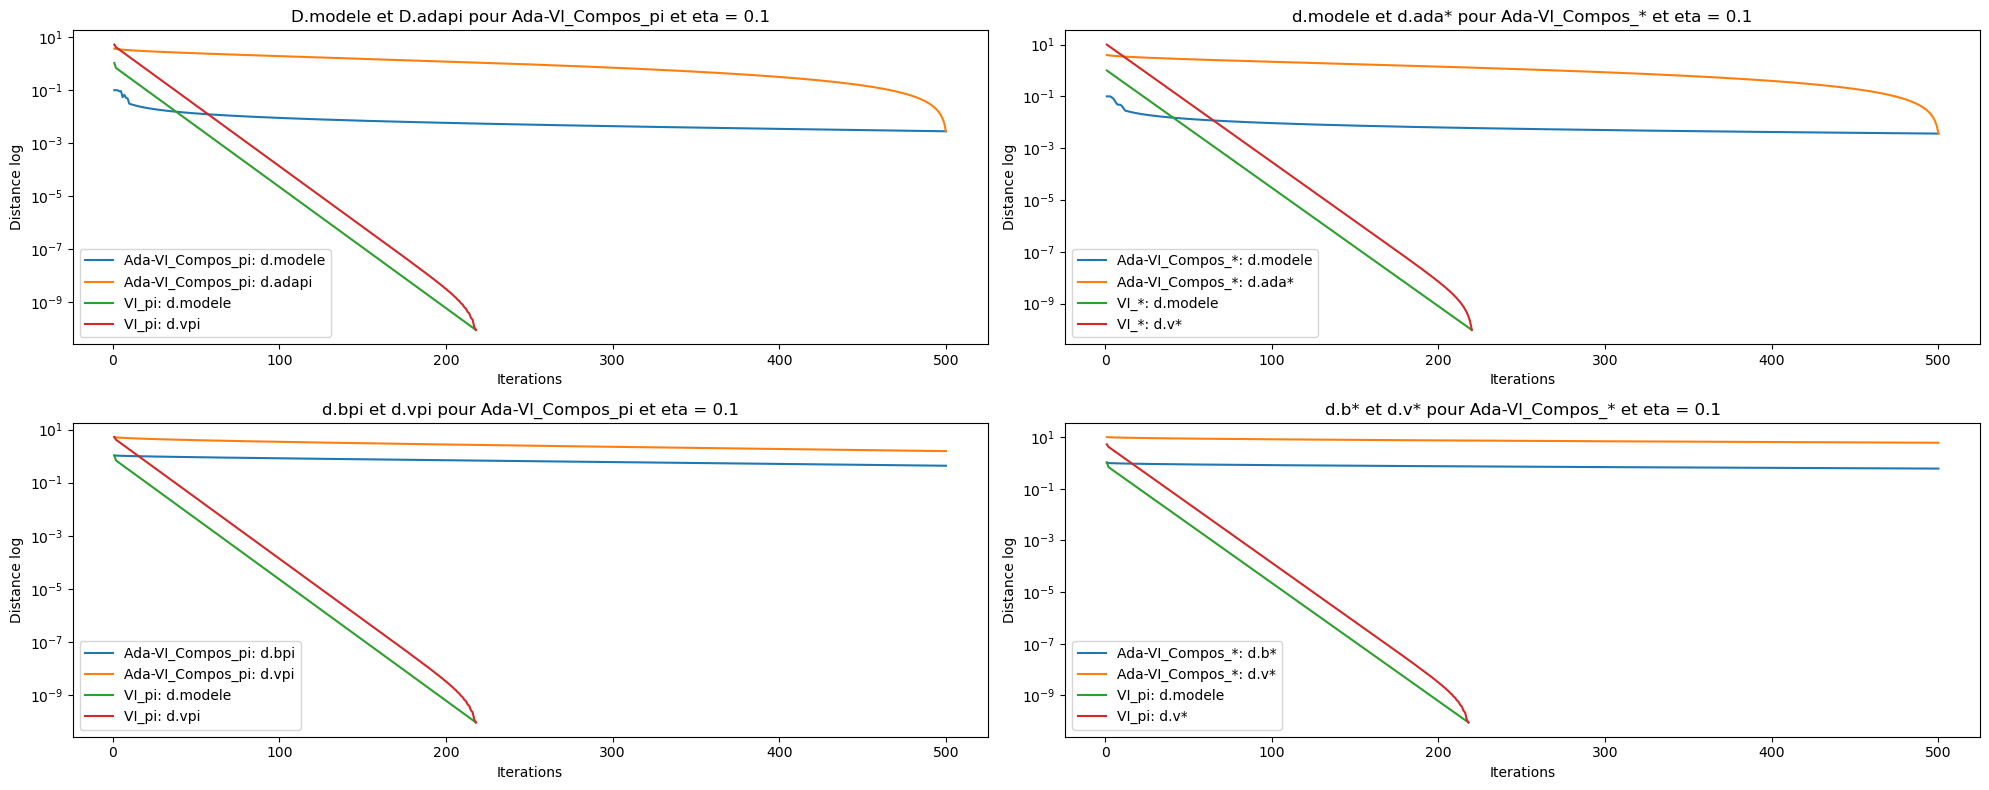

Processing etas:  40%|████      | 2/5 [01:04<01:37, 32.50s/it]

Distance finale entre v_pi estimée par VI et v_pi estimée par Ada-VI_Compos_pi pour eta = 1 : 1.6358321667366754e-09
Distance finale entre v_* estimée par VI et v_* estimée par Ada-VI_Compos_* pour eta = 1 : 5.731042440683729e-06


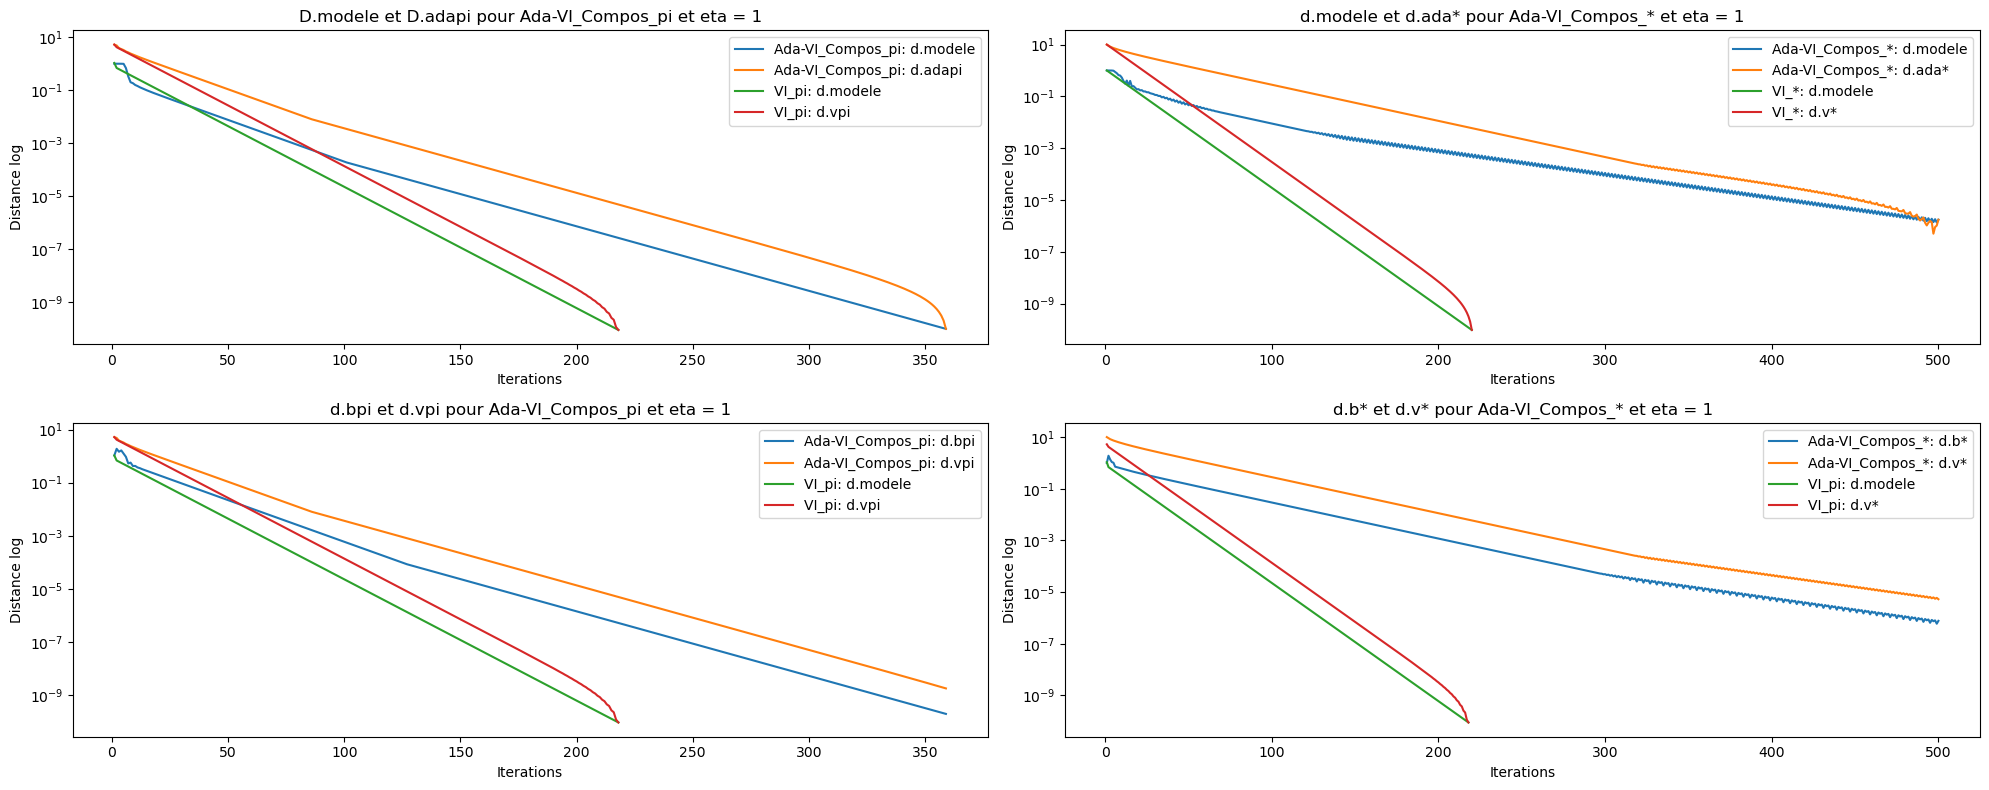

Processing etas:  60%|██████    | 3/5 [01:31<00:59, 29.76s/it]

Distance finale entre v_pi estimée par VI et v_pi estimée par Ada-VI_Compos_pi pour eta = 10 : 1.6685042790748918e-09
Distance finale entre v_* estimée par VI et v_* estimée par Ada-VI_Compos_* pour eta = 10 : 1.5931579244786466e-07


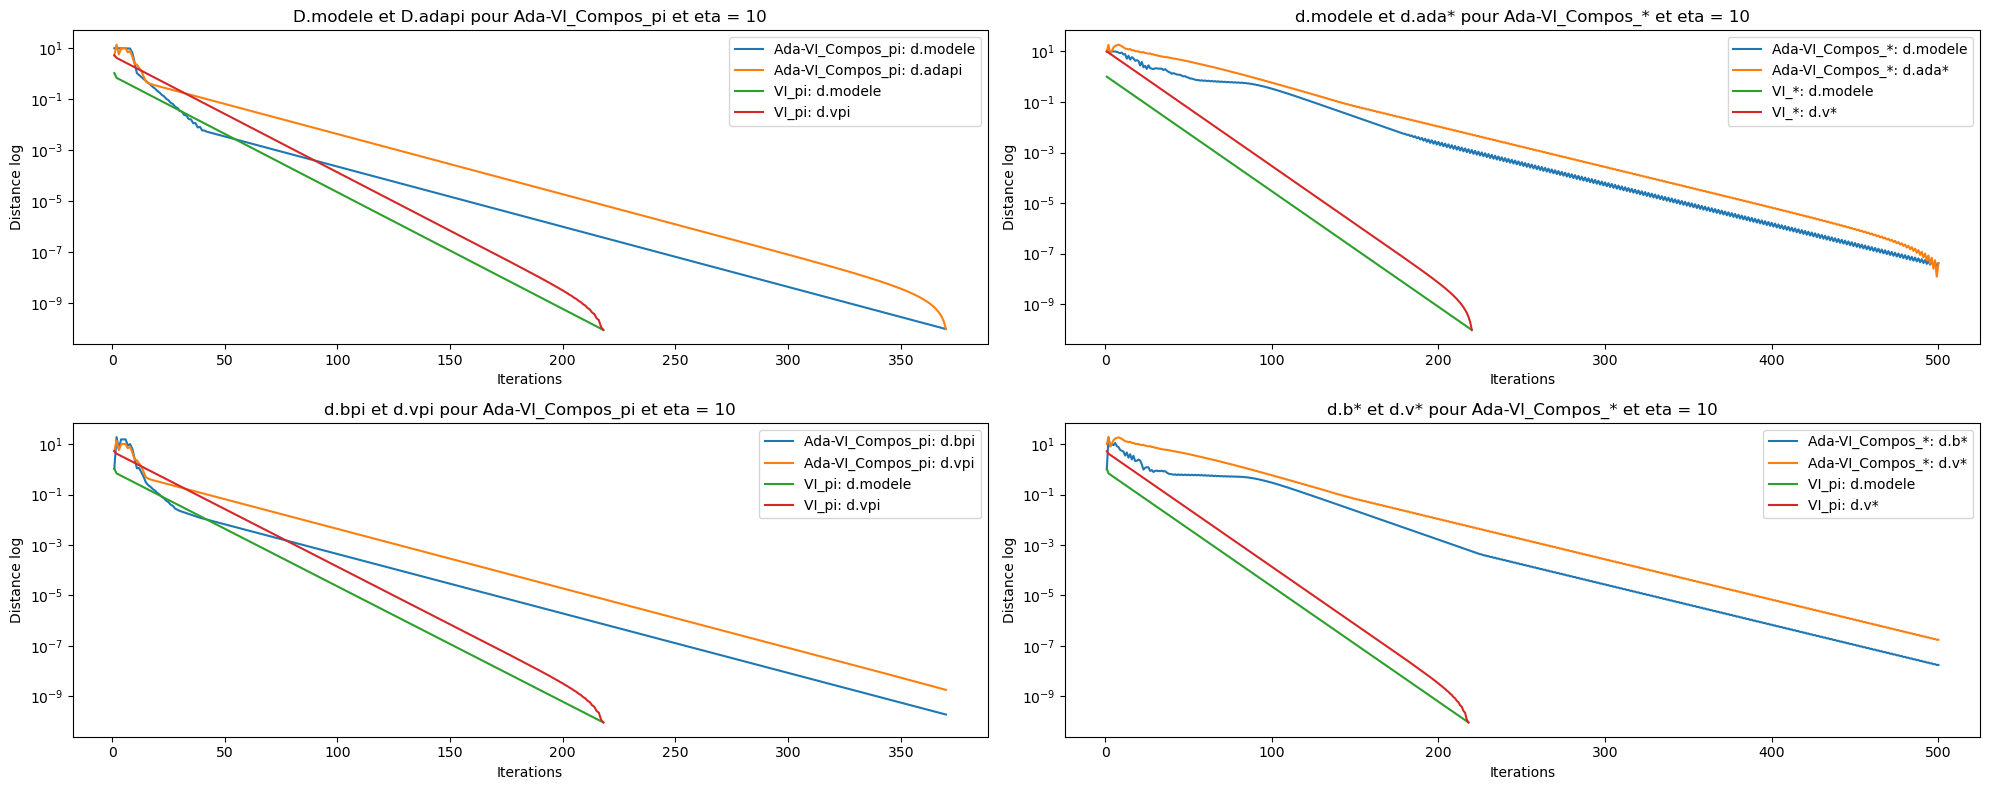

Processing etas:  80%|████████  | 4/5 [01:57<00:28, 28.48s/it]

Distance finale entre v_pi estimée par VI et v_pi estimée par Ada-VI_Compos_pi pour eta = 1000 : 1.65402231045645e-09
Distance finale entre v_* estimée par VI et v_* estimée par Ada-VI_Compos_* pour eta = 1000 : 6.434411031408967


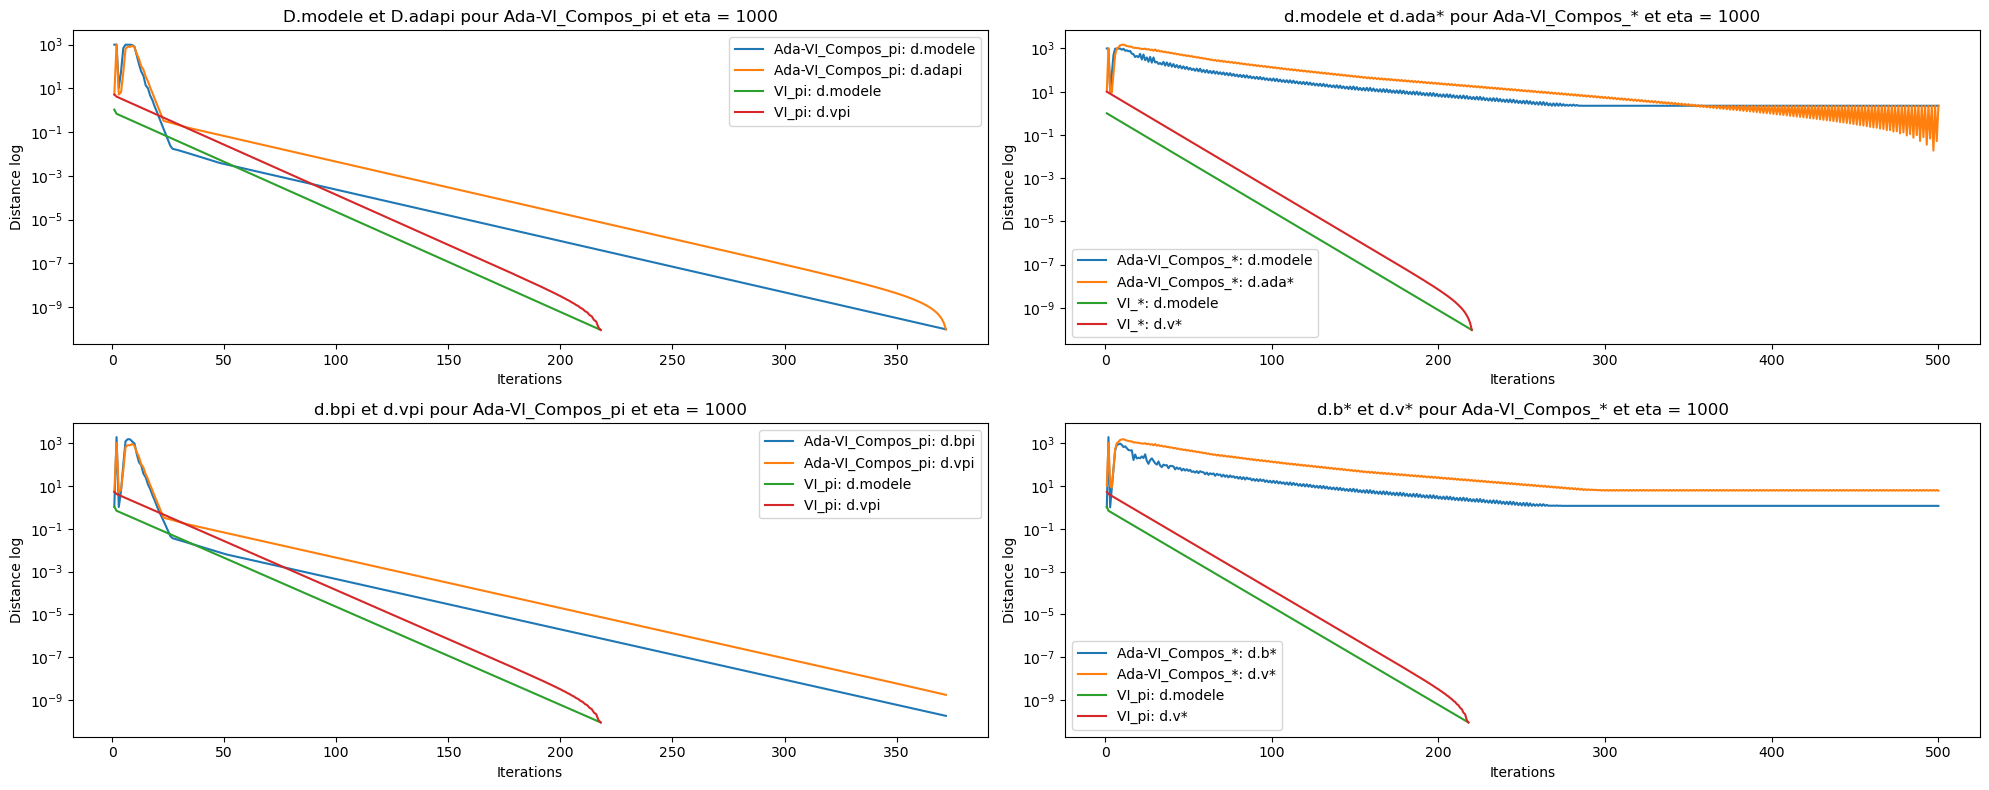

Processing etas: 100%|██████████| 5/5 [02:24<00:00, 28.86s/it]


In [13]:
etas = [1e-3, 0.1, 1, 10 ,1000]
plot_results(maze,etas, ada_function = Ada_VI_composante,num_iterations=500, seuil = 1e-10)

Pour ce MDP très simple, on constate que les algorithmes classiques sont au moins aussi efficace et on note une grande dépendance du comportement des algorithmes $\text{Ada-VI-Comp}_\pi^{(\mathrm{V})}$ et $\text{Ada-VI-Comp}_*^{(\mathrm{V})}$ par rapport à l'hyperparamètre $\eta$. Lorsque $\eta$ n'est pas correctement calibré, ici pour $\eta = 0.001$ ou $\eta = 1000$ par exemple, alors on constate que l'algorithme ne converge pas suffisamment vers le point fixe. Dans le cas où $\eta = 1000$, on constate que $\text{Ada-VI-Comp}_\pi^{(\mathrm{V})}$ converge correctement vers le point fixe mais que $\text{Ada-VI-Comp}_*^{(\mathrm{V})}$ ne parvient pas à converger vers le point fixe.

Lorsque $\eta$ est correctement calibré, ici pour $\eta = 10$, alors on obtient une convergence satisfaisante et un point fixe final très proche de celui obtenu par les algorithmes $\text{VI}_\pi^{(\mathrm{V})}$ et $\text{VI}_*^{(\mathrm{V})}$.Toutefois le coût computationnel de $\text{Ada-VI-Comp}_\pi^{(\mathrm{V})}$ et $\text{Ada-VI-Comp}_*^{(\mathrm{V})}$ est nettement plus élevée pour un nombre d'itérations égal, ce qui tends à favoriser les algorithmes $\text{VI}_\pi^{(\mathrm{V})}$ et $\text{VI}_*^{(\mathrm{V})}$ pour ce cas de figure.

### Itérations asynchrones

On souhaite à présent appliquer $\text{VI}_{\pi}^{(V)}$,  $\text{VI}_{*}^{(V)}$, $\text{Ada-VI}_{\pi}^{(V)}$, $\text{Ada-VI}_{*}^{(V)}$, $\text{Ada-VI-Comp}_{\pi}^{(V)}$ et $\text{Ada-VI-Comp}_{*}^{(V)}$ avec des itérations asynchrones. Il est dans un premier temps nécessaire de vectoriser davantage nos calculs pour permettre une éxécution rapide malgré le nombre élevé d'itérations.
\
Je remercie Virgil Bertrand à qui j'ai emprunté les fonctions vectorisées suivantes et que j'ai pu intégrer dans mes autres fonctions.

In [14]:
transition_vectorized = np.zeros((maze_size[0], maze_size[1], len(actions), 1+2))
for s in np.ndindex(maze_size):
    for a in actions:
        r, s_ = transition(s, a)
        transition_vectorized[s[0], s[1], a, 0] = r
        transition_vectorized[s[0], s[1], a, 1:] = np.array(s_)
        
transition_vectorized = transition_vectorized.astype(int)

In [15]:
#Fonctions vectorisées empruntées à Virgil Bertrand (TP4).
def greedy_policy_vect(v) :
    i, j, a = np.indices((maze_size[0], maze_size[1], len(actions)))
    s_ = transition_vectorized[i, j, a, 1:]
    r = transition_vectorized[i, j, a, 0]
    values = r + gamma * v[s_[:, :, :, 0], s_[:, :, :, 1]]
    return values.argmax(axis=-1)

def update_state_pi(v_,v,s,pi):
    if s==(29,29):
        v_[s] = 1
        return v_
    a = pi[s]
    s_ = transition_vectorized[s[0], s[1], a, 1:]
    rewards = transition_vectorized[s[0], s[1], a, 0]
    v_[s] = rewards + gamma * v[s_[0], s_[1]]
    return v_

def update_state_star(v_,v,s):
    if s==(29,29):
        v_[s] = 1
        return v_
    s_ = transition_vectorized[s[0], s[1], :, 1:]
    rewards = transition_vectorized[s[0], s[1], :, 0]

    values = rewards + gamma * v[s_[:, 0], s_[:, 1]]
    max_value = np.max(values)

    v_[s] = max_value
    return v_

Pour analyser les estimations de $v_{\pi}$, $v_{*}$, $v_{\pi_{\text{Ada}_\pi}}$ et $v_{*_{\text{Ada}_*}}$ obtenues à la fin, on introduit une nouvelle distance:

\begin{align}
d_{\text{asynchrone}} : \mathbb{R}^D \rightarrow \mathbb{R}^+, \quad d_{\text{asynchrone}}(a) = \frac{\lVert a  \rVert_2^2}{D}
\tag{$d_{\text{asynchrone}}$}
\end{align}
On adopte les notations suivantes:
\begin{align}
d_{\text{asynchrone}}(v_{\pi} - v_{\pi_{\text{Ada}_\pi}}) = \frac{\lVert  v_{\pi} - v_{\pi_{\text{Ada}_\pi}} \rVert_2^2}{D}
\tag{$d_{\text{async}}\pi$}
\end{align}

\begin{align}
d_{\text{asynchrone}}(v_{*} - v_{*_{\text{Ada}_*}}) = \frac{\lVert  v_{*} - v_{*_{\text{Ada}_*}} \rVert_2^2}{D}
\tag{$d_{\text{async}}*$}
\end{align}

In [16]:
def asynchrone_final_metric(a,b):
    return(np.linalg.norm(a-b,ord=2)**2/a.size)

def comparatif_norm_vk_asynchrone(liste_vk,liste_state_vk, pi, function=update_state_pi):
    distances_returned = []

    if function == update_state_pi:
        distances_returned = [asynchrone_final_metric(v , function(np.copy(v),v,state, pi)) for v,state in zip(liste_vk,liste_state_vk)]
    else:
        distances_returned = [asynchrone_final_metric(v , function(np.copy(v),v,state)) for v,state in zip(liste_vk,liste_state_vk)]

    return distances_returned

In [17]:
import numpy as np

def VI_function_asynchrone(maze, function=update_state_pi, num_iterations=10000, seuil=1e-6, seed=42, print_metrics=False):
    """
    Approxime la valeur itérative (VI) de manière asynchrone pour une fonction de valeur donnée.

    Paramètres :
    - maze (numpy.ndarray) : Représentation de l'espace d'état du labyrinthe.
    - function (fonction) : Fonction de valeur utilisée pour l'itération (update_state_pi ou update_state_star).
    - num_iterations (int) : Nombre maximum d'itérations à effectuer.
    - seuil (float) : Seuil d'arrêt indiquant la convergence lorsque la différence entre les itérations est inférieure à ce seuil.
    - seed (int) : Graine pour initialiser le générateur de nombres aléatoires.
    - print_metrics (bool) : Si True, affiche les métriques de convergence pendant l'exécution.

    Retourne :
    - distance (list) : Liste des distances maximales entre les itérations successives (VI).
    - distance_vpi (list) : Liste des distances maximales entre les itérations successives et v_pi (ou v_*).
    - v_pi (numpy.ndarray) : Fonction de valeur optimale obtenue à partir de l'itération.
    - liste_vk (list) : Liste des fonctions de valeur à chaque itération.
    - liste_state (list) : Liste des états sélectionnés à chaque itération.
    - pi (numpy.ndarray) : Politique optimale obtenue à partir de l'itération.
    """
    np.random.seed(seed)

    v = np.random.random(maze.shape)
    v[29, 29] = 1
    pi = greedy_policy_vect(v)
    v_ = np.copy(v)
    states = list(np.ndindex(maze_size))
    state_len = len(states) - 1
    state_picked = np.random.randint(0, state_len)
    iter = 0
    liste_state = [state_picked]
    epsilon = np.inf
    distance = [np.inf]
    liste_vk = [v]
    Is_bpi = (function == update_state_pi)

    if print_metrics:
        print(f"Calcul de VI-asynchrone pour {function}.")

    while iter < num_iterations:
        # Calcul de la mise à jour de la fonction de valeur
        if Is_bpi:
            v_ = update_state_pi(v_, v, states[state_picked], pi)
        else:
            v_ = update_state_star(v_, v, states[state_picked])

        # Calcul de la différence maximale entre les itérations successives
        max_value = np.max(np.absolute(v - v_))

        if max_value == 0:
            max_value = distance[-1]

        # Stockage de la distance maximale dans la liste
        distance.append(max_value)

        # Mise à jour des variables pour la prochaine itération
        iter += 1
        v = np.copy(v_)
        liste_vk.append(v)
        epsilon = max_value
        state_picked = (state_picked + 1) % (len(states))
        liste_state.append(state_picked)

        # Affichage des métriques toutes les 100 itérations
        if iter % 100 == 0 and print_metrics:
            print('itérations : {:5d} , epsilon : {:3f}'.format(iter, epsilon), end='\r')

    # Affichage des métriques finales
    if print_metrics:
        print("\nNombre final d'itérations: ", iter)
        print("Distance finale :", epsilon)

    # Calcul de la fonction de valeur optimale v_pi
    v_pi = np.copy(v_)

    # Retrait de la dernière itération (valeur finale)
    liste_vk.pop() 

    # Calcul de la distance entre chaque itération et v_pi
    distance_vpi = [norm_inf_2d(v - v_pi) for v in liste_vk]
    return distance, distance_vpi, v_pi, liste_vk, liste_state, pi

In [18]:
import numpy as np

def Ada_VI_function_asynchrone(maze, function=update_state_pi, eta=1, num_iterations=10000, seuil=1e-6, seed=42, print_metrics=False):
    """
    Approxime la valeur itérative (Ada-VI) de manière asynchrone pour une fonction de valeur donnée.

    Paramètres :
    - maze (numpy.ndarray) : Représentation de l'espace d'état du labyrinthe.
    - function (fonction) : Fonction de valeur utilisée pour l'itération (update_state_pi ou update_state_star).
    - eta (float) : Paramètre d'adaptation de l'échelle.
    - num_iterations (int) : Nombre maximum d'itérations à effectuer.
    - seuil (float) : Seuil d'arrêt indiquant la convergence lorsque la différence entre les itérations est inférieure à ce seuil.
    - seed (int) : Graine pour initialiser le générateur de nombres aléatoires.
    - print_metrics (bool) : Si True, affiche les métriques de convergence pendant l'exécution.

    Retourne :
    - distance (list) : Liste des distances maximales entre les itérations successives (Ada-VI).
    - distance_vpi (list) : Liste des distances maximales entre les itérations successives et v_pi (ou v_*).
    - v_pi (numpy.ndarray) : Fonction de valeur optimale obtenue à partir de l'itération.
    - liste_vk (list) : Liste des fonctions de valeur à chaque itération.
    - liste_state (list) : Liste des états sélectionnés à chaque itération.
    - pi (numpy.ndarray) : Politique choisie.
    """
    np.random.seed(seed)

    v = np.random.random(maze.shape)
    v[29, 29] = 1
    pi = greedy_policy_vect(v)
    v_ = np.copy(v)
    states = list(np.ndindex(maze_size))
    state_len = len(states) - 1
    state_picked = np.random.randint(0, state_len)
    iter = 0
    epsilon = np.inf
    distance = []
    list_ul = []
    liste_state = [states[state_picked]]
    liste_vk = [v]
    Is_bpi = (function == update_state_pi)

    if print_metrics:
        print(f"Calcul de Ada-VI_asynchrone pour {function}.")

    while iter < num_iterations:
        # Calcul de la mise à jour de la fonction de valeur
        if Is_bpi:
            intermediate = update_state_pi(v_, v, states[state_picked], pi)
        else:
            intermediate = update_state_star(v_, v, states[state_picked])

        u_l_i_j = np.linalg.norm(intermediate - v, ord=2)**2
        list_ul.append(u_l_i_j)
        v_[states[state_picked]] = v[states[state_picked]] + eta * (intermediate[states[state_picked]] - v[states[state_picked]]) / (np.sqrt(sum(list_ul)))

        state_picked = (state_picked + 1) % (len(states))
        liste_state.append([states[state_picked]])

        # Calcul de la différence maximale entre les itérations successives
        max_value = np.max(np.absolute(v - v_))

        if max_value == 0:
            max_value = distance[-1]

        # Stockage de la distance maximale dans la liste
        distance.append(max_value)

        # Mise à jour des variables pour la prochaine itération
        iter += 1
        v = np.copy(v_)
        liste_vk.append(v)
        epsilon = max_value

        # Affichage des métriques toutes les 100 itérations
        if iter % 100 == 0 and print_metrics:
            print('itérations : {:5d} , epsilon : {:3f}'.format(iter, epsilon), end='\r')

    # Affichage des métriques finales
    if print_metrics:
        print("\nNombre final d'itérations: ", iter)
        print("Distance finale :", epsilon)

    # Calcul de la fonction de valeur optimale v_pi
    v_pi = np.copy(v_)

    # Retrait de la dernière itération (valeur finale)
    liste_vk.pop() 

    # Calcul de la distance entre chaque itération et v_pi
    distance_vpi = [norm_inf_2d(v - v_pi) for v in liste_vk]

    return distance, distance_vpi, v_pi, liste_vk, liste_state, pi

In [19]:
import numpy as np

def Ada_VI_Comp_function_asynchrone(maze, function=update_state_pi, eta=1, num_iterations=10000, seed=42, print_metrics=False):
    """
    Approxime la valeur itérative (Ada-VI-Comp) de manière asynchrone pour une fonction de valeur donnée.

    Paramètres :
    - maze (numpy.ndarray) : Représentation de l'espace d'état du labyrinthe.
    - function (fonction) : Fonction de valeur utilisée pour l'itération (update_state_pi ou update_state_star).
    - eta (float) : Paramètre d'adaptation de l'échelle.
    - num_iterations (int) : Nombre maximum d'itérations à effectuer.
    - seed (int) : Graine pour initialiser le générateur de nombres aléatoires.
    - print_metrics (bool) : Si True, affiche les métriques de convergence pendant l'exécution.

    Retourne :
    - distance (list) : Liste des distances maximales entre les itérations successives (Ada-VI-Comp).
    - distance_vpi (list) : Liste des distances maximales entre les itérations successives et v_pi (ou v_*).
    - v_pi (numpy.ndarray) : Fonction de valeur optimale obtenue à partir de l'itération.
    - liste_vk (list) : Liste des fonctions de valeur à chaque itération.
    - liste_state (list) : Liste des états sélectionnés à chaque itération.
    - pi (numpy.ndarray) : Politique choisie.
    """
    np.random.seed(seed)

    v = np.random.random(maze.shape)
    pi = greedy_policy_vect(v)
    v_ = np.copy(v)
    states = list(np.ndindex(maze_size))
    state_len = len(states) - 1
    state_picked = np.random.randint(0, state_len)
    iter = 0
    epsilon = np.inf
    distance = []
    liste_state = [states[state_picked]]
    list_ul = [[[] for _ in range(v.shape[0])] for _ in range(v.shape[1])]
    liste_vk = [v]

    if print_metrics:
        print(f"Calcul de Ada-VI-Comp pour {function}.")

    while iter < num_iterations:
        # Calcul de la mise à jour de la fonction de valeur
        if function == update_state_pi:
            intermediate = update_state_pi(v_, v, states[state_picked], pi)
        else:
            intermediate = update_state_star(v_, v, states[state_picked])

        u_l_i_j = (intermediate[states[state_picked]] - v[states[state_picked]])**2
        list_ul[states[state_picked][0]][states[state_picked][1]].append(u_l_i_j)
        v_[states[state_picked]] = v[states[state_picked]] + eta * (intermediate[states[state_picked]] - v[states[state_picked]]) / (np.sqrt(sum(list_ul[states[state_picked][0]][states[state_picked][1]])))

        state_picked = (state_picked + 1) % (state_len)
        liste_state.append([states[state_picked]])

        # Calcul de la différence maximale entre les itérations successives
        max_value = norm_inf_2d(v - v_)

        if max_value == 0:
            max_value = distance[-1]

        # Stockage de la distance maximale dans la liste
        distance.append(max_value)

        # Mise à jour des variables pour la prochaine itération
        iter += 1
        v = np.copy(v_)
        liste_vk.append(v)
        epsilon = max_value

        # Affichage des métriques toutes les 100 itérations
        if iter % 100 == 0 and print_metrics:
            print('itérations : {:5d} , epsilon : {:3f}'.format(iter, epsilon), end='\r')

    # Affichage des métriques finales
    if print_metrics:
        print("\nNombre final d'itérations: ", iter)
        print("Distance finale :", epsilon)

    # Calcul de la fonction de valeur optimale v_pi
    v_pi = np.copy(v_)

    # Retrait de la dernière itération (valeur finale)
    liste_vk.pop() 

    # Calcul de la distance entre chaque itération et v_pi
    distance_vpi = [norm_inf_2d(v - v_pi) for v in liste_vk]

    return distance, distance_vpi, v_pi, liste_vk, liste_state, pi

In [20]:
from tqdm import tqdm
import pandas as pd
def plot_results_asynchrone(maze,etas, ada_function = Ada_VI_function_asynchrone, num_iterations = 2000, seed = 42,
                            print_written_results = False,
                            print_all_metrics = False, print_plot=False):
    
    result_VI_pi = VI_function_asynchrone(maze, function=update_state_pi,num_iterations=num_iterations , seed = seed,
                                           print_metrics = print_all_metrics)
    result_VI_star = VI_function_asynchrone(maze, function=update_state_star, num_iterations=num_iterations, seed = seed,
                                             print_metrics = print_all_metrics)

    if ada_function == Ada_VI_function_asynchrone:
        en_tete_pi ="Ada-VI_pi_asynchrone"
        en_tete_star = "Ada-VI_*_asynchrone"
    elif ada_function == Ada_VI_Comp_function_asynchrone:
        en_tete_pi ="Ada-VI_Compos_pi_asynchrone"
        en_tete_star = "Ada-VI_Compos_*_asynchrone"

    results_table = []

    for eta in tqdm(etas, desc="Processing etas",position=0):
        print("--------------------------------------")
        print(f"eta = {eta}")
        result_ada_pi = ada_function(maze, function=update_state_pi, eta=eta, seed=seed,
                                     num_iterations=num_iterations, print_metrics = print_all_metrics)
        
        result_ada_star = ada_function(maze, function=update_state_star, eta=eta,seed=seed,
                                       num_iterations=num_iterations, print_metrics = print_all_metrics)

        distance_pi, distance_vpi_pi, vpi_pi, liste_vk_pi,liste_state_vk_pi, pi_pi = result_ada_pi
        distance_star, distance_vpi_star, vpi_star, liste_vk_star,liste_state_vk_star, pi_star = result_ada_star
        
        results_table.append({
            'eta': eta,
            'num_iterations':num_iterations,
            f'distance_{en_tete_pi}': asynchrone_final_metric(vpi_pi, result_VI_pi[2]),
            f'distance_{en_tete_star}': asynchrone_final_metric(vpi_star, result_VI_star[2]),
        })

        """
        TO FIX 
        distance_bpi_ada_pi = comparatif_norm_vk_asynchrone(liste_vk_pi, liste_state_vk_pi, pi_pi, function = update_state_pi)
        distance_b_star_ada_star = comparatif_norm_vk_asynchrone(liste_vk_star, liste_state_vk_star, pi_star,function = update_state_star)

        distance_vpi_ada_pi = [asynchrone_final_metric(v, result_VI_pi[2]) for v in liste_vk_pi]
        distance_v_star_ada_star = [asynchrone_final_metric(v, result_VI_star[2]) for v in liste_vk_star]
        """
        if print_written_results:
            print(f'Distance asynchrone finale entre v_pi estimée par VI_asynchrone et v_pi estimée par {en_tete_pi } pour eta = {eta} : {asynchrone_final_metric(vpi_pi, result_VI_pi[2])}')
            print(f'Distance asynchrone finale entre v_* estimée par VI_asynchrone et v_* estimée par {en_tete_star } pour eta = {eta} : {asynchrone_final_metric(vpi_star, result_VI_star[2])}')         
            
        if print_plot:
            plt.figure(figsize=(20, 8))
            # Plot pour B_pi
            plt.subplot(1, 2, 1)
            iterations_pi = range(1, len(distance_pi) + 1)
            plt.plot(iterations_pi, distance_pi, label=f'{en_tete_pi}: d.modele')
            plt.plot(iterations_pi, distance_vpi_pi, label=f'{en_tete_pi}: d.adapi')
            plt.plot(range(1, len(result_VI_pi[0]) +1  ), result_VI_pi[0], label=f'VI_pi: d.modele')
            plt.plot(range(1, len(result_VI_pi[0]) ), result_VI_pi[1], label=f'VI_pi: d.vpi')
            plt.yscale('log')
            plt.title(f'D.modele et D.adapi pour {en_tete_pi} et eta = {eta}')
            plt.xlabel('Iterations')
            plt.ylabel('Distance log')
            plt.legend()

            """
            plt.subplot(2, 2, 3)
            iterations_pi = range(1, len(distance_pi) + 1)
            plt.plot(iterations_pi, distance_bpi_ada_pi, label=f'{en_tete_pi}: d.bpi')
            plt.plot(iterations_pi, distance_vpi_ada_pi, label=f'{en_tete_pi}: d.vpi')
            plt.plot(range(1, len(result_VI_pi[0]) + 1 ), result_VI_pi[0], label=f'VI_pi: d.modele')
            plt.plot(range(1, len(result_VI_pi[0]) + 1), result_VI_pi[1], label=f'VI_pi: d.vpi')
            plt.yscale('log')
            plt.title(f'd.bpi et d.vpi pour {en_tete_pi} et eta = {eta}')
            plt.xlabel('Iterations')
            plt.ylabel('Distance log')
            plt.legend()
            """

            # Plot pour B_star
            plt.subplot(1, 2, 2)
            iterations_star = range(1, len(distance_star) + 1)
            plt.plot(iterations_star, distance_star, label=f'{en_tete_star}: d.modele')
            plt.plot(iterations_star, distance_vpi_star, label=f'{en_tete_star}: d.ada*')
            plt.plot(range(1, len(result_VI_star[0]) +1 ), result_VI_star[0], label=f'VI_*: d.modele')
            plt.plot(range(1, len(result_VI_star[0]) ), result_VI_star[1], label=f'VI_*: d.v*')
            plt.yscale('log')
            plt.title(f'd.modele et d.ada* pour {en_tete_star} et eta = {eta}')
            plt.xlabel('Iterations')
            plt.ylabel('Distance log')
            plt.legend()

            """
            plt.subplot(2, 2, 4)
            iterations_star = range(1, len(distance_star) + 1)
            plt.plot(iterations_star, distance_b_star_ada_star, label=f'{en_tete_star}: d.b*')
            plt.plot(iterations_star, distance_v_star_ada_star, label=f'{en_tete_star}: d.v*')
            plt.plot(range(1, len(result_VI_pi[0]) + 1 ), result_VI_pi[0], label=f'VI_pi: d.modele')
            plt.plot(range(1, len(result_VI_pi[0]) + 1), result_VI_pi[1], label=f'VI_pi: d.v*')
            plt.yscale('log')
            plt.title(f'd.b* et d.v* pour {en_tete_star} et eta = {eta}')
            plt.xlabel('Iterations')
            plt.ylabel('Distance log')
            plt.legend()
            """
            
            plt.tight_layout()
            plt.show()
    results_df = pd.DataFrame(results_table)
    results_df_sorted = results_df.sort_values(by='eta')
    print("\n")
    print(results_df_sorted.to_string(index=False))
    pass

In [21]:
# Appel de la fonction avec les valeurs d'eta que l'on souhaite tester
etas = [1e-5, 1e-3, 1, 10, 100, 1e5]
plot_results_asynchrone(maze,etas,ada_function=Ada_VI_function_asynchrone,num_iterations=25000)

Processing etas:   0%|          | 0/6 [00:00<?, ?it/s]

--------------------------------------
eta = 1e-05


Processing etas:  17%|█▋        | 1/6 [00:28<02:20, 28.11s/it]

--------------------------------------
eta = 0.001


Processing etas:  33%|███▎      | 2/6 [00:57<01:56, 29.05s/it]

--------------------------------------
eta = 1


Processing etas:  50%|█████     | 3/6 [01:27<01:28, 29.50s/it]

--------------------------------------
eta = 10


Processing etas:  67%|██████▋   | 4/6 [01:57<00:59, 29.50s/it]

--------------------------------------
eta = 100


Processing etas:  83%|████████▎ | 5/6 [02:26<00:29, 29.42s/it]

--------------------------------------
eta = 100000.0


Processing etas: 100%|██████████| 6/6 [02:57<00:00, 29.59s/it]



         eta  num_iterations  distance_Ada-VI_pi_asynchrone  distance_Ada-VI_*_asynchrone
     0.00001           25000                   2.150580e-01                  1.614952e-01
     0.00100           25000                   2.152070e-01                  1.616166e-01
     1.00000           25000                   3.070884e-01                  2.526410e-01
    10.00000           25000                   3.521441e-02                  1.137701e+00
   100.00000           25000                   1.545260e+00                  9.867932e+01
100000.00000           25000                   1.118081e+06                  9.773484e+07


In [22]:
# Appel de la fonction avec les valeurs d'eta que l'on souhaite tester
etas = [1e-5, 1e-3, 1, 10, 100, 1e5]
plot_results_asynchrone(maze,etas,ada_function=Ada_VI_Comp_function_asynchrone,num_iterations=250000)

Processing etas:   0%|          | 0/6 [00:00<?, ?it/s]

--------------------------------------
eta = 1e-05


Processing etas:  17%|█▋        | 1/6 [00:16<01:22, 16.42s/it]

--------------------------------------
eta = 0.001


Processing etas:  33%|███▎      | 2/6 [00:40<01:23, 20.81s/it]

--------------------------------------
eta = 1


Processing etas:  50%|█████     | 3/6 [00:58<00:59, 19.69s/it]

--------------------------------------
eta = 10


Processing etas:  67%|██████▋   | 4/6 [01:18<00:39, 19.71s/it]

--------------------------------------
eta = 100


Processing etas:  83%|████████▎ | 5/6 [01:37<00:19, 19.36s/it]

--------------------------------------
eta = 100000.0


Processing etas: 100%|██████████| 6/6 [01:56<00:00, 19.45s/it]




         eta  num_iterations  distance_Ada-VI_Compos_pi_asynchrone  distance_Ada-VI_Compos_*_asynchrone
     0.00001          250000                              0.243190                             0.183145
     0.00100          250000                              0.245358                             0.184610
     1.00000          250000                              0.003285                             0.014233
    10.00000          250000                              0.003285                             0.014238
   100.00000          250000                              0.003285                             0.014239
100000.00000          250000                              0.003285                             0.014457


## Partie IV (Bonus): Blackjack

On considère à présent le MDP du blackjack, accessible dans la bibliothèque gymnasium et dont la documentation est accessible ici: https://www.gymlibrary.dev/environments/toy_text/blackjack/
On adapte les fonctions précédentes et on en crée de nouvelles pour pouvoir utiliser ce MDP dans un but analogue à celui du labyrinthe.
\
\
La démarche ainsi que les algorithmes utilisés sont les mêmes que pour le labyrinthe, seul le cadre change ainsi que plusieurs fonctions outils indispensables mais secondaire par rapport au propos de cette étude.

La cellule suivante configure l'environnement en implémentant des méthodes supplémentaires nécessaires et non disponible avec la classe native dans gymnasium.

In [23]:
from gymnasium.envs.toy_text.blackjack import BlackjackEnv
import copy
import random
gamma = 0.9
actions = [0, 1]

deck = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 10, 10, 10]


def draw_card():
    return random.choice(deck)

class CustomBlackjackEnv(BlackjackEnv):
    def set_custom_state(self, player_sum, dealer_card, usable_ace):
        """
        Initialise l'environnement à un état spécifique.
        
        Paramètres :
        - player_sum (int) : La somme des cartes du joueur.
        - dealer_card (int) : La carte visible du croupier.
        - usable_ace (bool) : Indique si le joueur a un as utilisable (True) ou non (False).

        Retourne :
        - obs (tuple) : L'état initial de l'environnement après l'initialisation.
        """
        self.reset()
        self.player = [player_sum, usable_ace]
        self.dealer = [dealer_card, draw_card()]
        return self._get_obs()

    def artificial_step(self, action):
        """
        Effectue une étape artificielle dans l'environnement pour simuler une action.

        Paramètres :
        - action (int) : L'action à simuler (0 pour rester, 1 pour tirer une carte).

        Retourne :
        - next_state (tuple) : Le nouvel état de l'environnement après avoir simulé l'action.
        - reward (float) : La récompense obtenue après l'action.
        - terminated (bool) : Indique si l'épisode est terminé après l'action.
        - truncated (bool) : Indique si l'épisode est tronqué après l'action.
        """
        # Créer une copie de l'environnement initial
        env_copy = copy.deepcopy(self)
        # Effectuer l'action dans la copie
        next_state, reward, terminated, truncated, _ = env_copy.step(action)
        
        # Ne pas oublier de fermer la copie de l'environnement si nécessaire
        env_copy.close()
        return next_state, reward, terminated, truncated

    def transition(self, a):
        """
        Effectue une transition dans l'environnement en simulant une action.

        Paramètres :
        - a (int) : L'action à simuler (0 pour rester, 1 pour tirer une carte).

        Retourne :
        - r (float) : La récompense obtenue après l'action simulée.
        - s_ (tuple) : Le nouvel état de l'environnement après avoir simulé l'action.
        """
        s_, r, terminated, truncated = self.artificial_step(a)
        sum_player = s_[0]
        return r, s_



La cellule suivante crée les fonctions nécessaires pour avoir une estimation des probabilités de transitions entre chaque états.
La méthode employée est de faire un nombre n de simulations pour chaque état, prendre n le plus grand possible et ensuite utiliser la loi faible des grands nombres pour obtenir un estimateur de la probabilité de chaque événements.

In [24]:
def enumerate_states():
    """
    Génère une liste de tous les états possibles dans le problème du Blackjack.

    Returns:
        list: Une liste d'états possibles.
    """
    states = []
    for player_sum in range(0, 32):  # Valeurs possibles pour la somme du joueur
        for dealer_card in range(1, 11):  # Valeurs possibles pour la carte du croupier
            for usable_ace in [False, True]:
                for reward in [-1,0,1]: 
                    states.append((player_sum, dealer_card, usable_ace,reward))
    return states
    
def estim_proba_unique(etat, a, nombre_estimateur=100):
    """
    Estime les probabilités de transition pour un état et une action donnée en utilisant une approche stochastique.

    Args:
        etat (tuple): Un tuple représentant un état du Blackjack.
        a (int): Une action (0 pour rester, 1 pour tirer une carte).
        nombre_estimateur (int): Le nombre d'estimateurs utilisés pour l'estimation stochastique.

    Returns:
        numpy.ndarray: Une matrice représentant les probabilités de transition estimées.
    """
    liste = np.zeros([32,10,2,3])
    list_reward = [-1,0,1]
    
    for i in range(nombre_estimateur):
        env = CustomBlackjackEnv(natural=False, sab=False)
        env.set_custom_state(etat[0],etat[1],etat[2])
        r,state = env.transition(a)
        reward_index = list_reward.index(r)
        liste[state[0]][state[1]-1][state[2]][reward_index] += 1
    np.divide(liste, nombre_estimateur,out=liste)

    return liste

def totale_estim_proba(nombre_estimateur=100):
    """
    Estime les probabilités de transition pour toutes les combinaisons d'états et d'actions possibles dans le problème du Blackjack.

    Args:
        nombre_estimateur (int): Le nombre d'estimateurs utilisés pour chaque estimation stochastique.

    Returns:
        list: Un tableau multidimensionnel représentant les probabilités de transition estimées pour chaque état et action.
    """
    liste_action = [0,1]
    env = CustomBlackjackEnv(natural=False, sab=False)
    list_etat_reward = enumerate_states()
    list_reward = [-1,0,1]
    # dimension : 32 pour la somme du joueur, 10 pour le croupier, 2 pour l'as, 3 pour les issues possibles
    proba_estim = [[[[[] for _ in range(3)]  for _ in range(2)] for _ in range(10)] for _ in range(32)]

    for etat in tqdm(list_etat_reward, desc="Estimation stochastique", leave=False):
        if etat[0] < 21:
            for action in liste_action:
                proba_estim[etat[0]][etat[1]-1][etat[2]][action] = estim_proba_unique(etat,action,nombre_estimateur= nombre_estimateur)
        elif etat[0] == 21:
            proba_estim[etat[0]][etat[1]-1][etat[2]][0] = estim_proba_unique(etat,0,nombre_estimateur= nombre_estimateur)
            
    return proba_estim


def get_accessible_states(state,action,proba_estim):
    """
    Extrait les états accessibles à partir d'un état donné en fonction d'une action et des probabilités de transition estimées.

    Args:
        state (tuple): L'état initial du Blackjack.
        action (int): L'action effectuée (0 pour rester, 1 pour tirer une carte).
        proba_estim (list): Les probabilités de transition estimées.

    Returns:
        tuple: Deux tableaux NumPy représentant les états accessibles et les probabilités correspondantes.
    """
    list_reward = [-1,0,1]
    list_concerned = proba_estim[state[0]][state[1]-1][state[2]][action]

    list_indice_nonzero = np.nonzero(list_concerned)
    sum_player,carte_croupier, ace, reward = np.nonzero(list_concerned)
    number_value = len(sum_player)
    list_etat_accessible = []
    liste_proba_accessible = []

    for i in range(number_value):
        list_etat_accessible.append([sum_player[i],carte_croupier[i],ace[i],action,list_reward[reward[i] ] ])
        liste_proba_accessible.append(list_concerned[sum_player[i]][carte_croupier[i]][ace[i]][reward[i]])
         
    list_etat_accessible = np.array(list_etat_accessible)
    list_proba_accessible = np.array(liste_proba_accessible)
    
    return list_etat_accessible,list_proba_accessible


def computing_b_pi_for_s(list_etat_accessible,list_proba_accessible, v):
    """
    Calcules b_pi(s)

    Args:
        list_etat_accessible (numpy.ndarray): Les états accessibles depuis l'état s.
        list_proba_accessible (numpy.ndarray): Les probabilités correspondantes d'atteindre ces états.
        v (numpy.ndarray): La fonction de valeur v utilisée pour le calcul.

    Returns:
        float: La valeur de b^pi(s) calculée.
    """
    somme = 0
    for etat_accessible, proba_accessible in zip(list_etat_accessible,list_proba_accessible):
        somme += proba_accessible * ( etat_accessible[-1] + gamma * v[etat_accessible[0]][etat_accessible[1]-1][etat_accessible[2]])
    
    return somme


On définit deux fonctions normes à utiliser avec nos tableaux 3d.

In [25]:
def norm_2(a,b):
    norm = 0
    for i in range(a.shape[0]):
        for j in range(a.shape[1]):
            for k in range(a.shape[2]):
                norm += np.linalg.norm(a[i][j][k] - b[i][j][k])**2
    return norm

def norm_inf(a):
    max_value = -np.inf
    for i in range(a.shape[0]):
        for j in range(a.shape[1]):
            for k in range(a.shape[2]):
                value = np.linalg.norm(a[i][j][k])
                if value > max_value:
                    max_value = value
    return max_value

On estime les probabilités de transitions. Attention, plus le nombre d'estimateur est grand, plus le temps de calcul est grand.

In [26]:
%time proba_table = totale_estim_proba(nombre_estimateur=250)

Estimation stochastique:   0%|          | 1/1920 [00:00<05:26,  5.88it/s]

CPU times: total: 56.7 s
Wall time: 2min 54s


Les cellules suivantes adaptes les fonctions utilisées pour le labyrinthe pour calculer la politique initiale, $B_\pi$ et $B_*$.
Ici il est important de prendre en compte les différents états possibles, les probabilités de transitions que les récompenses associées comme vu en cours dans le chapitre II sur les opérateurs de Bellman.

In [27]:
def greedy_policy_blackjack(v):
    pi = np.zeros_like(v,dtype=int)
    pi[0] = np.ones_like(v[0],dtype=int)
    pi[1] = np.ones_like(v[0],dtype=int)
    for i in range(2,v.shape[0]-11):
        for j in range(v.shape[1]):
            for k in range(v.shape[2]):
                max_value = -np.inf
                s =(i,j,k)
                for a in actions:
                    value = 0
                    list_etat_accessible, list_proba_accessible = get_accessible_states(s,a,proba_table)
                    value  += computing_b_pi_for_s(list_etat_accessible,list_proba_accessible, v)
                    if value > max_value:
                        max_value = value
                        pi[s] = a
    return pi

In [28]:
gamma = 0.9

def B_pi_blackjack(v, pi): 
    v_ = np.zeros_like(v)
    list_reward = [-1,0,1]
    v_[22:, :, :] = -1 # car si on a plus de 21 on perd immédiatement
    for i in range(v.shape[0] -10):
        for j in range(v.shape[1]):
            for k in range(v.shape[2]):
                value = 0
                s = (i, j, k)
                a = pi[s]
                list_etat_accessible, list_proba_accessible = get_accessible_states(s,a,proba_table)
                value  += computing_b_pi_for_s(list_etat_accessible,list_proba_accessible, v)
                v_[s] = value
    return v_

def B_star_blackjack(v): 
    v_ = np.zeros_like(v)
    v_[22:, :, :] = -1 # car si on a plus de 21 on perd immédiatement
    for i in range(v.shape[0] - 11):
        for j in range(v.shape[1]):
            for k in range(v.shape[2]):
                max_value = -np.inf
                s = (i, j, k)
                for a in actions:
                    value = 0
                    list_etat_accessible, list_proba_accessible = get_accessible_states(s,a,proba_table)
                    value  += computing_b_pi_for_s(list_etat_accessible,list_proba_accessible, v)
                    if value > max_value:
                        max_value = value
                v_[s[0], s[1], s[2]] = max_value
    i = 21 
    for j in range(v.shape[1]):
            for k in range(v.shape[2]):
                max_value = -np.inf
                s = (i, j, k)
                value = 0
                list_etat_accessible, list_proba_accessible = get_accessible_states(s,0,proba_table)
                value  += computing_b_pi_for_s(list_etat_accessible,list_proba_accessible, v)
                if value > max_value:
                    max_value = value
                v_[s[0], s[1], s[2]] = max_value
    return v_


def comparatif_norm_vk_blackjack(liste_vk,pi,function = B_pi_blackjack):
    distance_returned = []
    if function == B_pi_blackjack:
        for v in liste_vk:
            distance_returned.append(norm_inf(v - function(v,pi)))
    else:
        for v in liste_vk:
            distance_returned.append(norm_inf(v - function(v)))
    return distance_returned


La cellule suivante implémentent respectivement $\text{VI}_{\pi}^{(V)}$ et $\text{VI}_{*}^{(V)}$ en utilisant la même base que pour le labyrinthe.

In [29]:
import numpy as np

def VI_function_blackjack(function=B_pi_blackjack, num_iterations=1000, seuil=1e-6, seed=42, print_metrics=False):
    """
    Paramètres :
    - function (fonction) : La fonction de valeur utilisée pour l'itération (B_pi_blackjack ou B_star_blackjack).
    - num_iterations (int) : Le nombre maximum d'itérations à effectuer.
    - seuil (float) : Le seuil d'arrêt, indiquant la convergence lorsque la différence entre les itérations est inférieure à ce seuil.
    - seed (int) : La graine pour initialiser le générateur de nombres aléatoires.
    - print_metrics (bool) : Si True, affiche les métriques de convergence pendant l'exécution.

    Retourne :
    - distance (list) : Liste des distances pour la norme infinie entre les itérations successives (VI).
    - distance_vpi (list) : Liste des distances pour la norme infinie entre les itérations successives et v_pi (resp v_*).
    - v_pi (numpy.ndarray) : Fonction de valeur optimale obtenue à partir de l'itération.
    - liste_vk (list) : Liste des fonctions de valeur à chaque itération.
    - pi (numpy.ndarray) : Politique choisie.
    """

    # Initialisation de l'environnement
    np.random.seed(seed)
    env = CustomBlackjackEnv(natural=False, sab=False)
    env.reset(seed=seed)
    v = np.random.random([32, 10, 2])
    v[22:, :, :] = -1  # car si on a plus de 21 on perd immédiatement
    pi = greedy_policy_blackjack(v)
    iter = 0
    epsilon = np.inf
    distance = []
    liste_vk = [v]
    Is_bpi = (function == B_pi_blackjack)

    if print_metrics:
        print(f"Calcul de VI pour {function}.")

    while epsilon > seuil and iter < num_iterations:
        if Is_bpi:
            v_ = B_pi_blackjack(v, pi)
        else:
            v_ = B_star_blackjack(v)

        max_value = norm_inf(v - v_)
        distance.append(max_value)
        iter += 1
        v = np.copy(v_)
        liste_vk.append(v)
        epsilon = max_value
        if iter % 100 == 0 and print_metrics:
            print('iter : {:5d} , epsilon : {:3f}'.format(iter, epsilon), end='\r')
    if print_metrics:
        print("\nNombre final d'itérations: ", iter)
        print("Distance finale :", epsilon)

    v_pi = np.copy(v_)
    liste_vk.pop()
    distance_vpi = [norm_inf(v - v_pi) for v in liste_vk]

    return distance, distance_vpi, v_pi, liste_vk, pi

La cellule suivante implémentent respectivement $\text{Ada-VI}_{\pi}^{(V)}$ et $\text{Ada-VI}_{*}^{(V)}$ en utilisant la même base que pour le labyrinthe.

In [30]:
import numpy as np

def Ada_VI_function_blackjack(function=B_pi_blackjack, eta=1, num_iterations=2000, seuil=1e-4, seed=42, print_metrics=False):
    """
    Paramètres :
    - function (fonction) : La fonction de valeur utilisée pour l'itération (B_pi_blackjack ou B_star_blackjack).
    - eta (float) : Le paramètre d'adaptation de l'échelle.
    - num_iterations (int) : Le nombre maximum d'itérations à effectuer.
    - seuil (float) : Le seuil d'arrêt, indiquant la convergence lorsque la différence entre les itérations est inférieure à ce seuil.
    - seed (int) : La graine pour initialiser le générateur de nombres aléatoires.
    - print_metrics (bool) : Si True, affiche les métriques de convergence pendant l'exécution.

    Retourne :
    - distance (list) : Liste des distances maximales pour la norme infinie entre les itérations successives (Ada-VI).
    - distance_vpi (list) : Liste des distances maximales pour la norme infinie entre les itérations successives et v_pi (resp v_*).
    - v_pi (numpy.ndarray) : Fonction de valeur optimale obtenue à partir de l'itération.
    - liste_vk (list) : Liste des fonctions de valeur à chaque itération.
    - pi (numpy.ndarray) : Politique choisie.
    "
    """
    # Initialisation de l'environnement
    np.random.seed(seed)
    env = CustomBlackjackEnv(natural=False, sab=False)
    env.reset(seed=seed)
    v = np.random.random([32, 10, 2])
    v[22:, :, :] = -1  # car si on a plus de 21 on perd immédiatement
    pi = greedy_policy_blackjack(v)
    iter = 0
    epsilon = np.inf
    distance = []
    Is_bpi = (function == B_pi_blackjack)
    list_ul = []
    liste_vk = [v]

    if print_metrics:
        print(f"Calcul de Ada-VI par composante pour {function} et eta = {eta}")

    while epsilon > seuil and iter < num_iterations:

        if Is_bpi:
            intermediate = B_pi_blackjack(v, pi)
            u_l = norm_2(intermediate, v)
            list_ul.append(u_l)
            v_ = v + eta * (intermediate - v) / (np.sqrt(sum(list_ul)))
        else:
            intermediate = B_star_blackjack(v)
            u_l = norm_2(intermediate, v)
            list_ul.append(u_l)
            v_ = v + eta * (intermediate - v) / (np.sqrt(sum(list_ul)))

        max_value = norm_inf(v - v_)
        distance.append(max_value)
        iter += 1
        v = np.copy(v_)
        liste_vk.append(v)
        epsilon = max_value
        if iter % 100 == 0 and print_metrics:
            print('iter : {:5d} , epsilon : {:3f}'.format(iter, epsilon), end='\r')
    if print_metrics:
        print("\nNombre final d'itérations:", iter)
        print("Distance final :", epsilon)

    # Reconstruction de la distance || v_k - v_pi||
    v_pi = np.copy(v_)  # Je prends le dernier v_k calculé comme étant v_pi (approximation)
    liste_vk.pop()
    distance_vpi = [norm_inf(v - v_pi) for v in liste_vk]


    return distance, distance_vpi, v_pi, liste_vk, pi

On Incorpore directement la version de $ \text{Ada-VI-Comp}_{\pi}^{(V)}$ et $ \text{Ada-VI-Comp}_{*}^{(V)}$ pour le blackjack. La fonction est analogue à celle utilisée pour le labyrinthe.

In [31]:
import numpy as np

def Ada_VI_composante_blackjack(function=B_pi_blackjack, eta=1, num_iterations=500, seuil=1e-6, seed=42, print_metrics=False):
    """
    Paramètres :
    - function (fonction) : La fonction de valeur utilisée pour l'itération (B_pi_blackjack ou B_star_blackjack).
    - eta (float) : Le paramètre d'adaptation de l'échelle.
    - num_iterations (int) : Le nombre maximum d'itérations à effectuer.
    - seuil (float) : Le seuil d'arrêt, indiquant la convergence lorsque la différence entre les itérations est inférieure à ce seuil.
    - seed (int) : La graine pour initialiser le générateur de nombres aléatoires.
    - print_metrics (bool) : Si True, affiche les métriques de convergence pendant l'exécution.

    Retourne :
    - distance (list) : Liste des distances maximales entre les itérations successives (Ada-VI).
    - distance_vpi (list) : Liste des distances maximales entre les itérations successives et (v_pi) (resp v_*).
    - v_pi (numpy.ndarray) : La valeur optimale obtenue à partir de l'itération.
    - list_vk (list) : Liste des fonctions de valeur à chaque itération.
    - pi (numpy.ndarray) : La politique choisie.
    """
    
    # Initialisation de l'espace des états et de la politique
    np.random.seed(seed)
    env = CustomBlackjackEnv(natural=False, sab=False)
    env.reset(seed=seed)
    v = np.random.random([32, 10, 2])
    v[22:, :, :] = -1  # car si on a plus de 21 on perd immédiatement
    v_ = np.ones_like(v)
    v_[22:, :, :] = -1
    pi = greedy_policy_blackjack(v)
    iter = 0
    epsilon = np.inf
    distance = []
    Is_bpi = (function == B_pi_blackjack)
    list_vk = [v]
    list_ul = [[[[] for _ in range(v.shape[2])] for _ in range(v.shape[1])] for _ in range(v.shape[0]-10)]

    if print_metrics:
        print(f"Calcul de Ada-VI par composante pour {function} et eta = {eta}")

    while epsilon > seuil and iter < num_iterations:
        if Is_bpi:
            intermediate = B_pi_blackjack(v, pi)
            for i in range(v.shape[0]-10):
                for j in range(v.shape[1]):
                    for k in range(v.shape[2]):
                        u_l_i_j = (intermediate[i][j][k] - v[i][j][k])**2
                        list_ul[i][j][k].append(u_l_i_j)
                        v_[i][j][k] = v[i][j][k] + eta * (intermediate[i][j][k] - v[i][j][k]) / (np.sqrt(sum(list_ul[i][j][k])))
        else:
            intermediate = B_star_blackjack(v)
            for i in range(v.shape[0]-10):
                for j in range(v.shape[1]):
                    for k in range(v.shape[2]):
                        u_l_i_j = (intermediate[i][j][k] - v[i][j][k])**2
                        list_ul[i][j][k].append(u_l_i_j)
                        v_[i][j][k] = v[i][j][k] + eta * (intermediate[i][j][k] - v[i][j][k]) / (np.sqrt(sum(list_ul[i][j][k])))

        max_value = norm_inf(v - v_)
        distance.append(max_value)
        iter += 1
        v = np.copy(v_)
        list_vk.append(v)
        epsilon = max_value
        if iter % 100 == 0 and print_metrics:
            print('itérations : {:5d} , epsilon : {:3f}'.format(iter, epsilon), end='\r')
    if print_metrics:
        print("\nNombre final d'itérations:", iter)
        print("Distance final :", epsilon)

    # Reconstruction de la distance || v_k - v_pi||
    v_pi = np.copy(v_)  # Je prends le dernier v_k calculé comme étant v_pi (approximation)
    list_vk.pop()
    distance_vpi = [norm_inf(v - v_pi) for v in list_vk]

    return distance, distance_vpi, v_pi, list_vk, pi

La fonction suivante permet d'afficher les courbes des distances suivantes:
\begin{align}
\left\|v_k-v_{k+1}\right\|_{\infty}
\tag{d.modele}
\end{align}

\begin{align}
\left\|v_k-\mathrm{B}_\pi v_k \right\|_{\infty} ( \text{ resp } \left\|v_k-\mathrm{B}_* v_k\right\|_{\infty}) \text{ pour } \text{Ada-VI}_\pi^{(\mathrm{V})} ( \text{ resp } \text{Ada-VI}_*^{(\mathrm{V})}) \tag{d.bpi, d.b*}
\end{align}

\begin{align}
\left\|v_k-v_\pi\right\|_{\infty} ( \text{ resp } \left\|v_k-v_*\right\|_{\infty}) \tag{d.vpi, d.v*}
\end{align}

\begin{align}
\left\|v_k-v_{\pi_{\text{Ada}_\pi}}\right\|_{\infty} ( \text{ resp } \left\|v_k-v_{*_{\text{Ada}_*}}\right\|_{\infty}) \tag{d.adapi, d.ada*}
\end{align}

 Ces distances seront affichées pour chacun des algorithmes ($\text{VI}_\pi^{(\mathrm{V})}$, $\text{VI}_*^{(\mathrm{V})}$, $\text{Ada-VI}_\pi^{(\mathrm{V})}$ et $\text{Ada-VI}_*^{(\mathrm{V})}$) testés et pour chaque valeur de $\eta$ choisie.


In [32]:
from tqdm import tqdm
def plot_results_blackjack(etas, ada_function = Ada_VI_function_blackjack, num_iterations = 500,seuil=1e-4, seed = 42, print_metrics = False):

    
    result_VI_pi = VI_function_blackjack(function=B_pi_blackjack,num_iterations=num_iterations , seuil=seuil,  seed = seed, print_metrics = print_metrics)
    result_VI_star = VI_function_blackjack(function=B_star_blackjack,num_iterations=num_iterations, seuil = seuil , seed = seed, print_metrics = print_metrics)

    if ada_function == Ada_VI_function_blackjack:
        en_tete_pi ="Ada-VI_pi"
        en_tete_star = "Ada-VI_*"
    elif ada_function == Ada_VI_composante_blackjack:
        en_tete_pi ="Ada-VI_Compos_pi"
        en_tete_star = "Ada-VI_Compos_*"

    for eta in tqdm(etas, desc="Processing etas",position=0):
        
        result_ada_pi = ada_function(function=B_pi_blackjack, eta=eta, seuil = seuil, seed=seed,
                                     num_iterations=num_iterations, print_metrics = print_metrics)
        
        result_ada_star = ada_function(function=B_star_blackjack, eta=eta, seuil = seuil,seed=seed,
                                       num_iterations=num_iterations, print_metrics = print_metrics)

        distance_pi, distance_vpi_pi, vpi_pi, liste_vk_pi, pi_pi = result_ada_pi
        distance_star, distance_vpi_star, vpi_star, liste_vk_star, pi_star = result_ada_star

        distance_bpi_ada_pi = comparatif_norm_vk_blackjack(liste_vk_pi, pi_pi, function = B_pi_blackjack)
        distance_b_star_ada_star = comparatif_norm_vk_blackjack(liste_vk_star, pi_star, function = B_star_blackjack)

        distance_vpi_ada_pi = [[norm_inf(v - result_VI_pi[-3]) for v in liste_vk_pi]]
        distance_v_star_ada_star = [[norm_inf(v - result_VI_star[-3]) for v in liste_vk_star]]


        print(f'Distance finale entre v_pi estimée par VI et v_pi estimée par {en_tete_pi } pour eta = {eta} : {norm_inf(vpi_pi - result_VI_pi[2])}')
        print(f'Distance finale entre v_* estimée par VI et v_* estimée par {en_tete_star } pour eta = {eta} : {norm_inf(vpi_star - result_VI_star[2])}')         
        
        plt.figure(figsize=(20, 8))

       # Plot pour B_pi
        plt.subplot(2, 2, 1)
        iterations_pi = range(1, len(distance_pi) + 1)
        plt.plot(iterations_pi, distance_pi, label=f'{en_tete_pi}: d.modele')
        plt.plot(iterations_pi, distance_vpi_pi, label=f'{en_tete_pi}: d.adapi')
        plt.plot(range(1, len(result_VI_pi[0]) + 1 ), result_VI_pi[0], label=f'VI_pi: d.modele')
        plt.plot(range(1, len(result_VI_pi[0]) + 1), result_VI_pi[1], label=f'VI_pi: d.vpi')
        plt.yscale('log')
        plt.title(f'D.modele et D.adapi pour {en_tete_pi} et eta = {eta}')
        plt.xlabel('Iterations')
        plt.ylabel('Distance log')
        plt.legend()

        plt.subplot(2, 2, 3)
        iterations_pi = range(1, len(distance_pi) + 1)
        plt.plot(iterations_pi, distance_bpi_ada_pi, label=f'{en_tete_pi}: d.bpi')
        plt.plot(iterations_pi, distance_vpi_ada_pi[0], label=f'{en_tete_pi}: d.vpi')
        plt.plot(range(1, len(result_VI_pi[0]) + 1 ), result_VI_pi[0], label=f'VI_pi: d.modele')
        plt.plot(range(1, len(result_VI_pi[0]) + 1), result_VI_pi[1], label=f'VI_pi: d.vpi')
        plt.yscale('log')
        plt.title(f'd.bpi et d.vpi pour {en_tete_pi} et eta = {eta}')
        plt.xlabel('Iterations')
        plt.ylabel('Distance log')
        plt.legend()

        # Plot pour B_star
        plt.subplot(2, 2, 2)
        iterations_star = range(1, len(distance_star) + 1)
        plt.plot(iterations_star, distance_star, label=f'{en_tete_star}: d.modele')
        plt.plot(iterations_star, distance_vpi_star, label=f'{en_tete_star}: d.ada*')
        plt.plot(range(1, len(result_VI_star[0]) +1 ), result_VI_star[0], label=f'VI_*: d.modele')
        plt.plot(range(1, len(result_VI_star[0]) +1), result_VI_star[1], label=f'VI_*: d.v*')
        plt.yscale('log')
        plt.title(f'd.modele et d.ada* pour {en_tete_star} et eta = {eta}')
        plt.xlabel('Iterations')
        plt.ylabel('Distance log')
        plt.legend()

        plt.subplot(2, 2, 4)
        iterations_star = range(1, len(distance_star) + 1)
        plt.plot(iterations_star, distance_b_star_ada_star, label=f'{en_tete_star}: d.b*')
        plt.plot(iterations_star, distance_v_star_ada_star[0], label=f'{en_tete_star}: d.v*')
        plt.plot(range(1, len(result_VI_pi[0]) + 1 ), result_VI_pi[0], label=f'VI_pi: d.modele')
        plt.plot(range(1, len(result_VI_pi[0]) + 1), result_VI_pi[1], label=f'VI_pi: d.v*')
        plt.yscale('log')
        plt.title(f'd.b* et d.v* pour {en_tete_star} et eta = {eta}')
        plt.xlabel('Iterations')
        plt.ylabel('Distance log')
        plt.legend()

        plt.tight_layout()
        plt.show()
    pass

### Résultats pour le BlackJack

##### $\text{VI}_\pi^{(\mathrm{V})}$, $\text{VI}_*^{(\mathrm{V})}$, $\text{Ada-VI}_\pi^{(\mathrm{V})}$ et $\text{Ada-VI}_*^{(\mathrm{V})}$

Processing etas:   0%|          | 0/7 [00:00<?, ?it/s]

Distance finale entre v_pi estimée par VI et v_pi estimée par Ada-VI_pi pour eta = 0.001 : 8.975341207330853
Distance finale entre v_* estimée par VI et v_* estimée par Ada-VI_* pour eta = 0.001 : 8.975346900204253


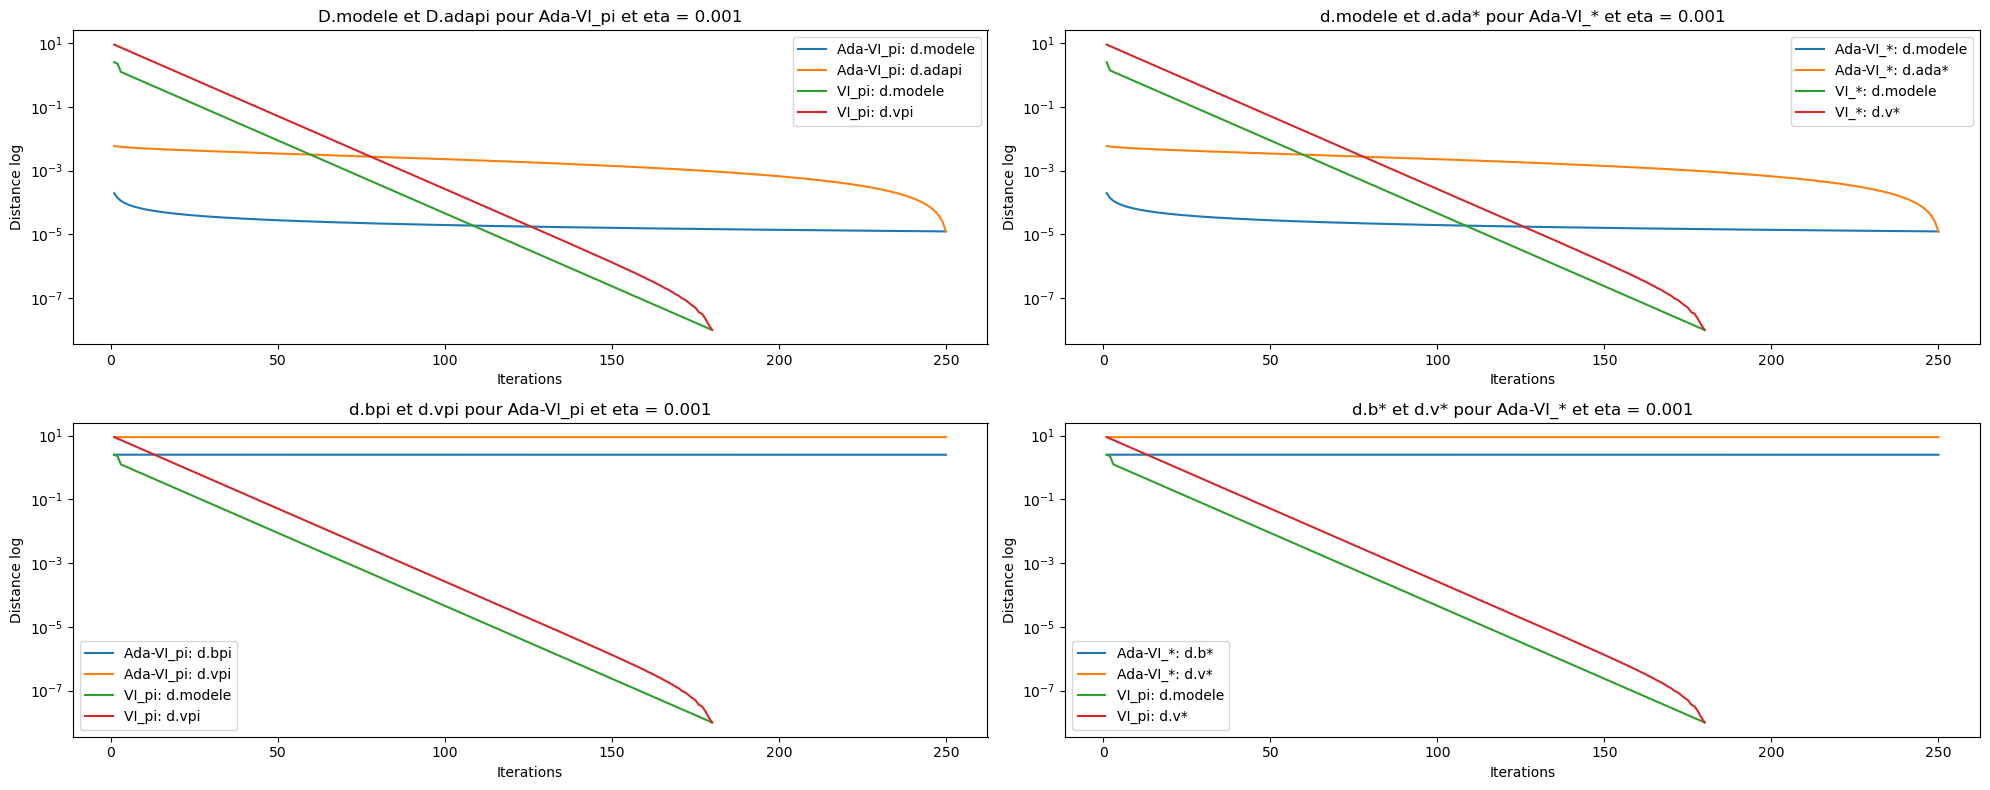

Processing etas:  14%|█▍        | 1/7 [00:37<03:46, 37.68s/it]

Distance finale entre v_pi estimée par VI et v_pi estimée par Ada-VI_pi pour eta = 0.1 : 8.650352147870407
Distance finale entre v_* estimée par VI et v_* estimée par Ada-VI_* pour eta = 0.1 : 8.650689147024854


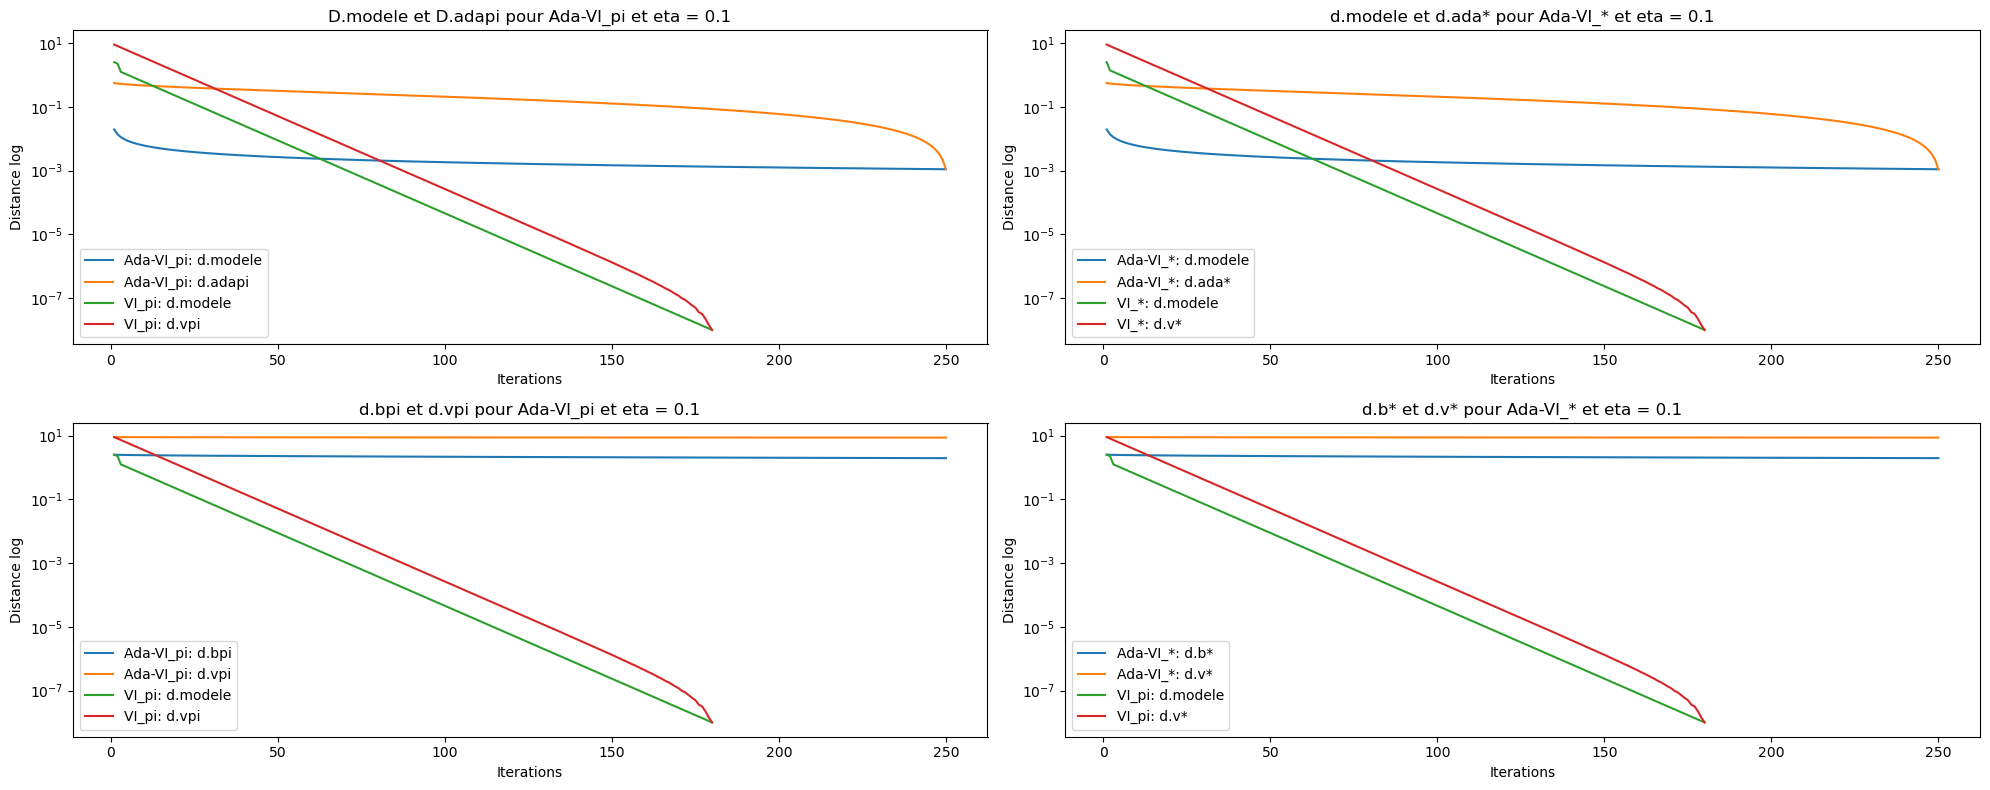

Processing etas:  29%|██▊       | 2/7 [01:10<02:53, 34.78s/it]

Distance finale entre v_pi estimée par VI et v_pi estimée par Ada-VI_pi pour eta = 1 : 6.076813081130797
Distance finale entre v_* estimée par VI et v_* estimée par Ada-VI_* pour eta = 1 : 5.988757290847052


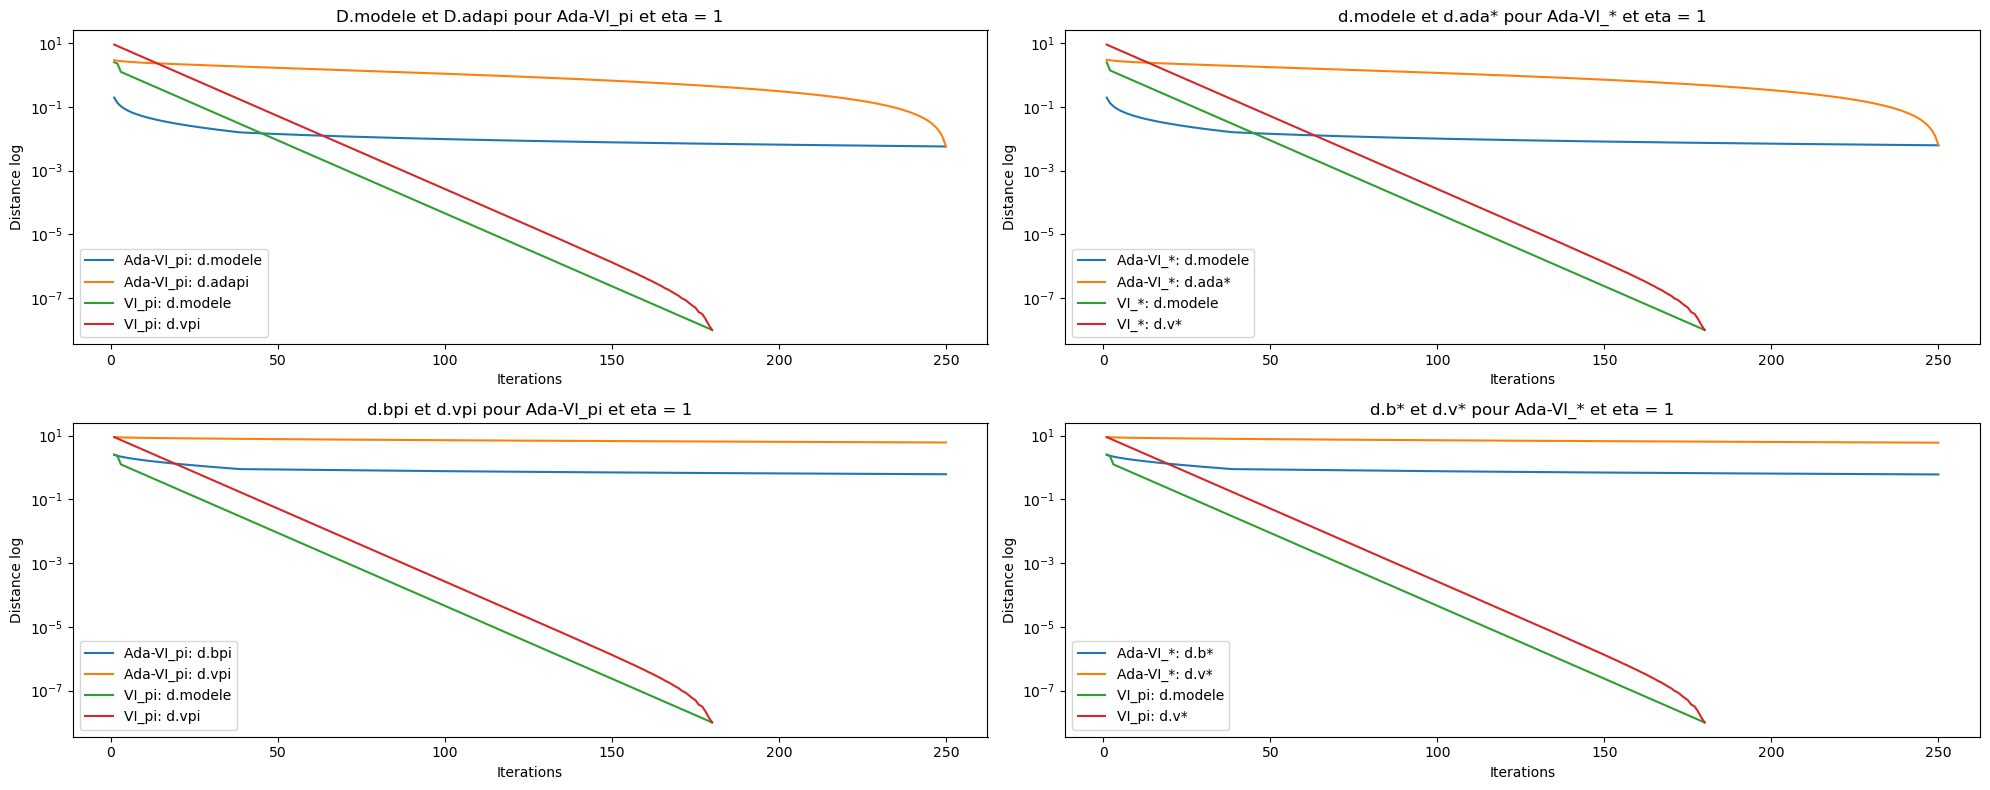

Processing etas:  43%|████▎     | 3/7 [01:43<02:15, 33.92s/it]

Distance finale entre v_pi estimée par VI et v_pi estimée par Ada-VI_pi pour eta = 10 : 0.0009233571590101519
Distance finale entre v_* estimée par VI et v_* estimée par Ada-VI_* pour eta = 10 : 0.0002919224360962147


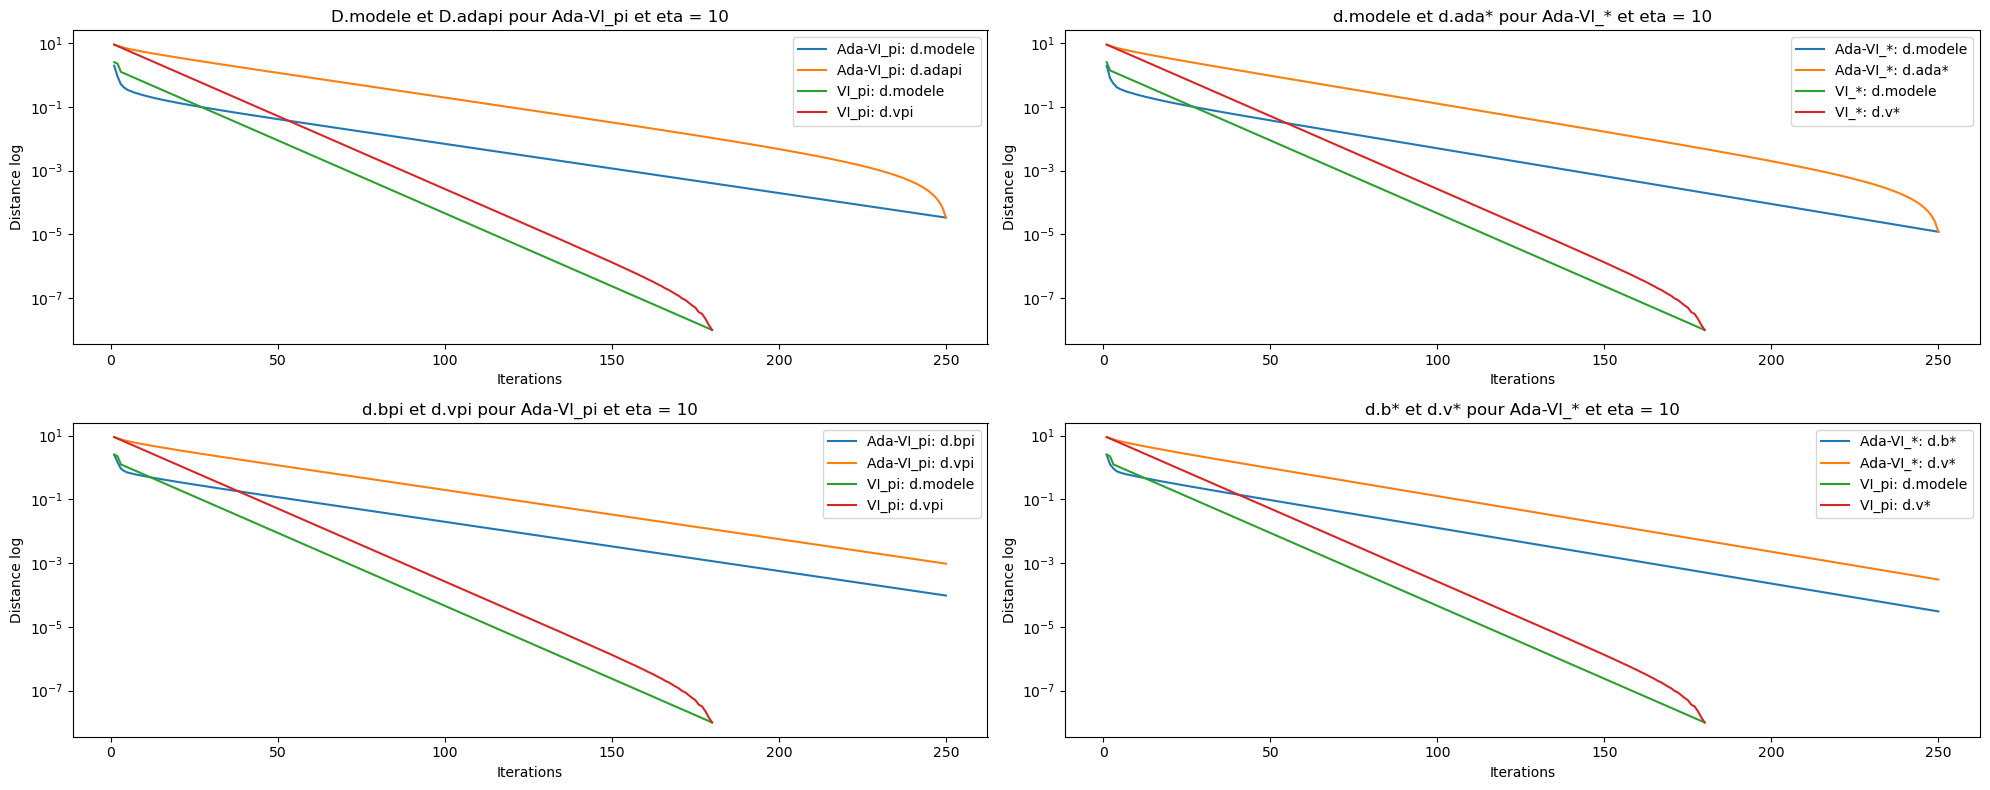

Processing etas:  57%|█████▋    | 4/7 [02:16<01:40, 33.44s/it]

Distance finale entre v_pi estimée par VI et v_pi estimée par Ada-VI_pi pour eta = 100 : 8.434648535171618e-08
Distance finale entre v_* estimée par VI et v_* estimée par Ada-VI_* pour eta = 100 : 9.206412399098696e-08


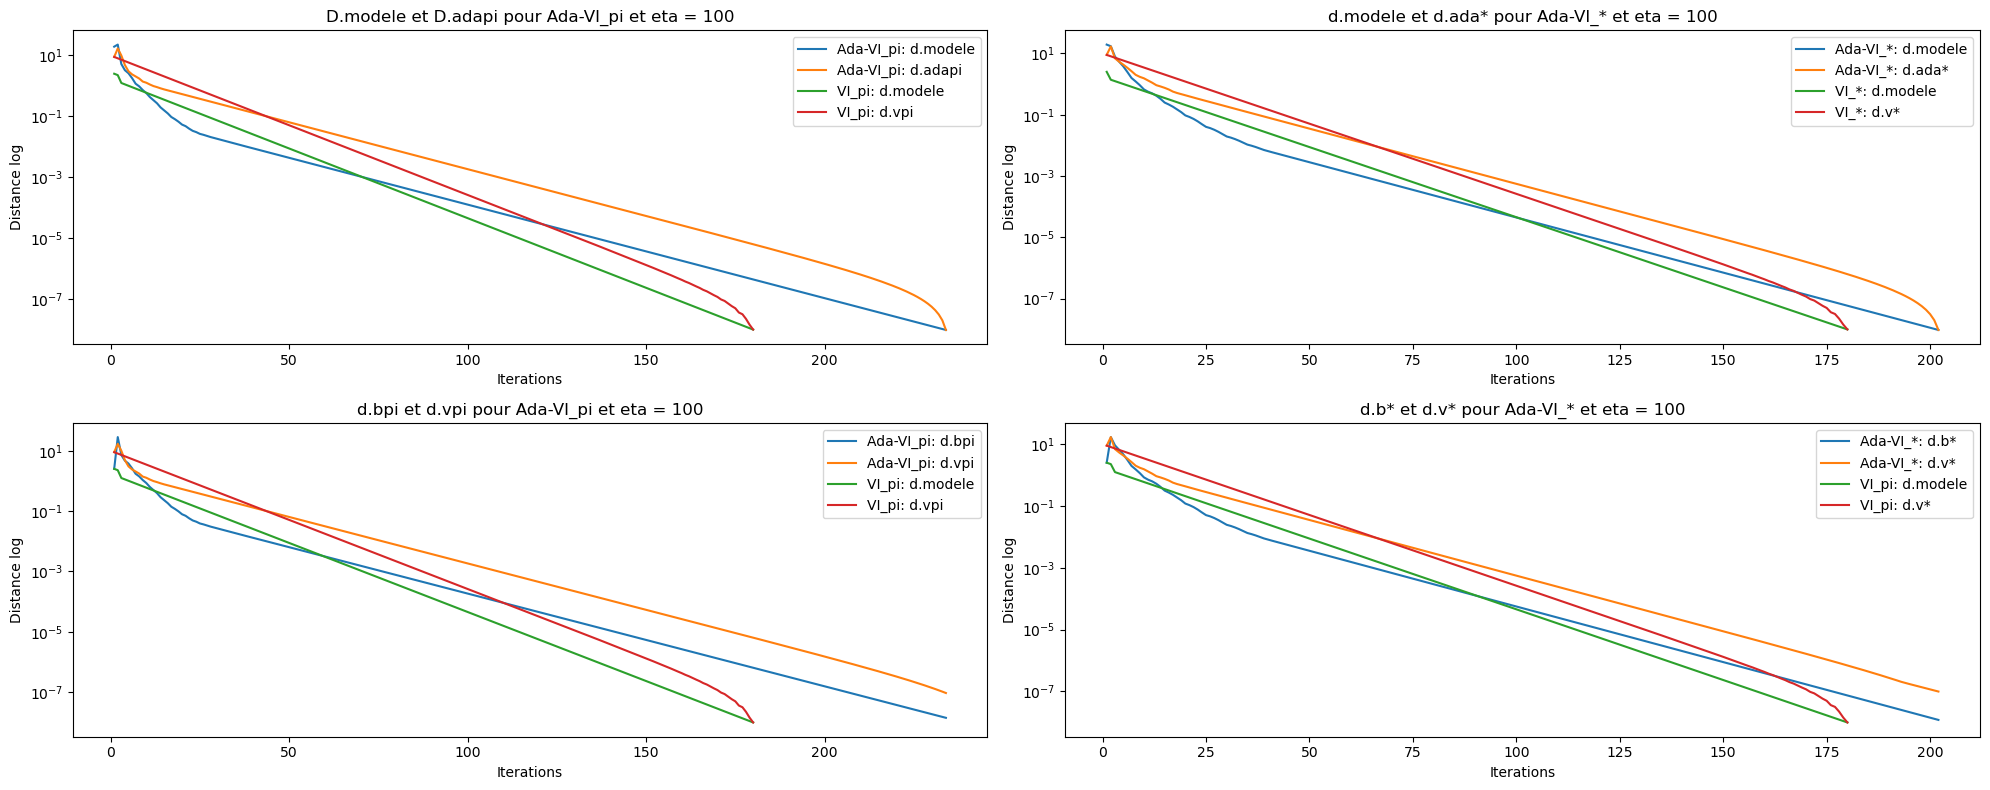

Processing etas:  71%|███████▏  | 5/7 [02:44<01:03, 31.55s/it]

Distance finale entre v_pi estimée par VI et v_pi estimée par Ada-VI_pi pour eta = 1000 : 2.9011267841383415e-06
Distance finale entre v_* estimée par VI et v_* estimée par Ada-VI_* pour eta = 1000 : 1.685266450834888e-07


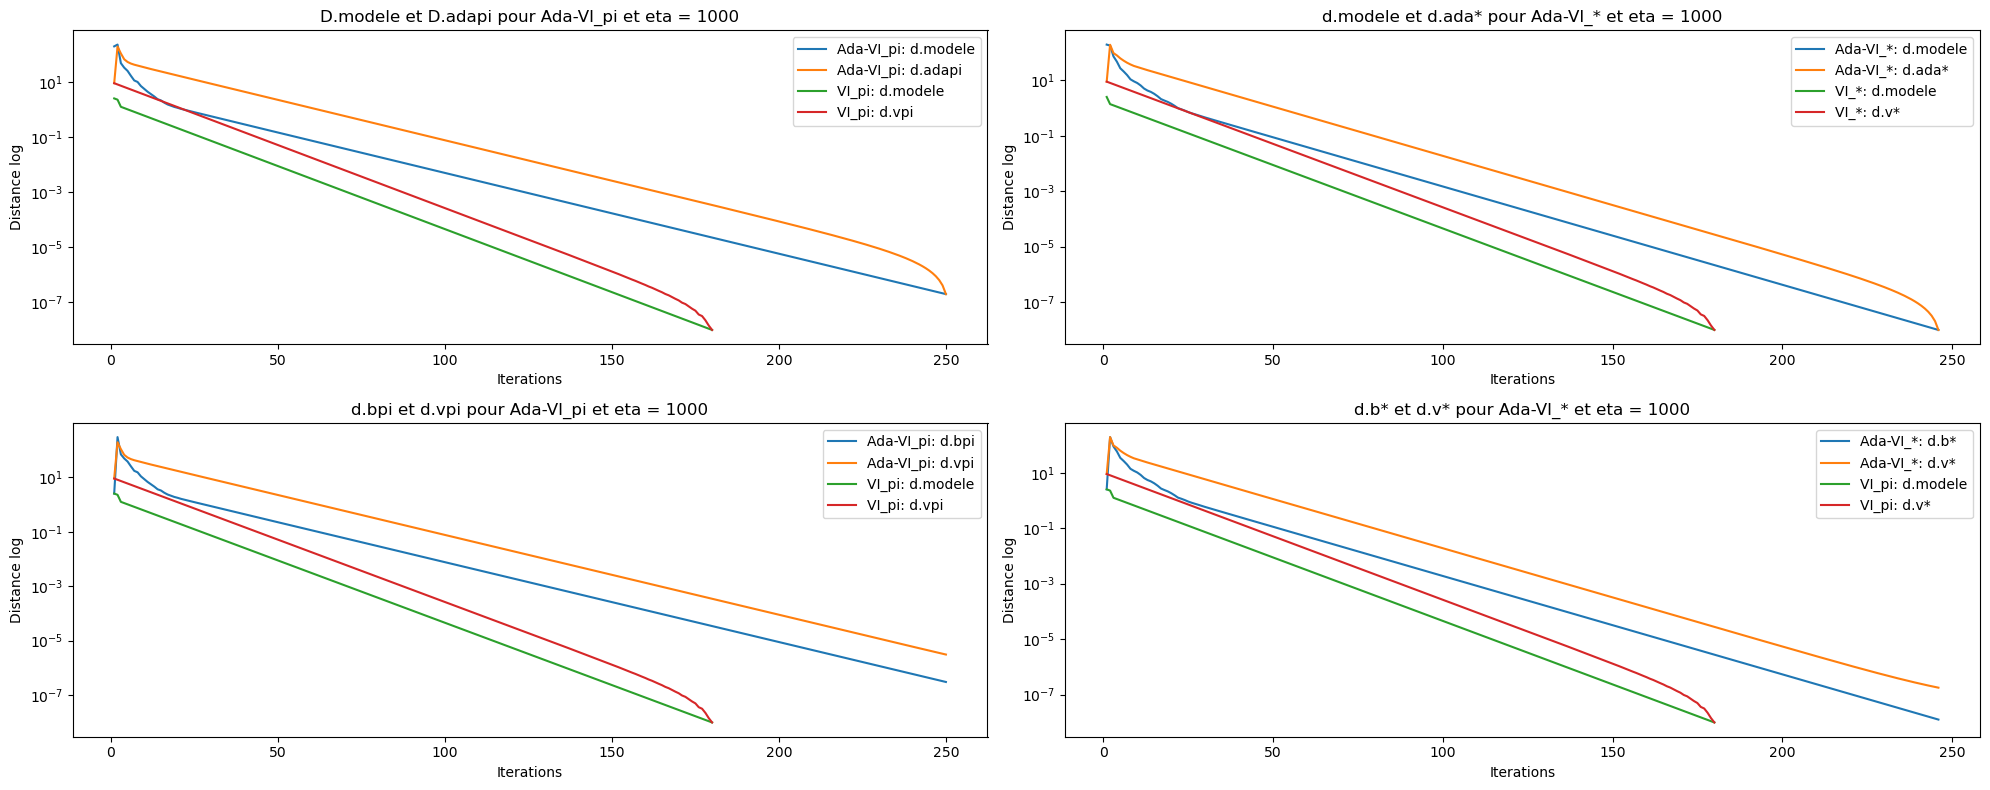

Processing etas:  86%|████████▌ | 6/7 [03:16<00:31, 31.79s/it]

Distance finale entre v_pi estimée par VI et v_pi estimée par Ada-VI_pi pour eta = 100000.0 : 0.0003643105157600246
Distance finale entre v_* estimée par VI et v_* estimée par Ada-VI_* pour eta = 100000.0 : 1.0521491011772355e-05


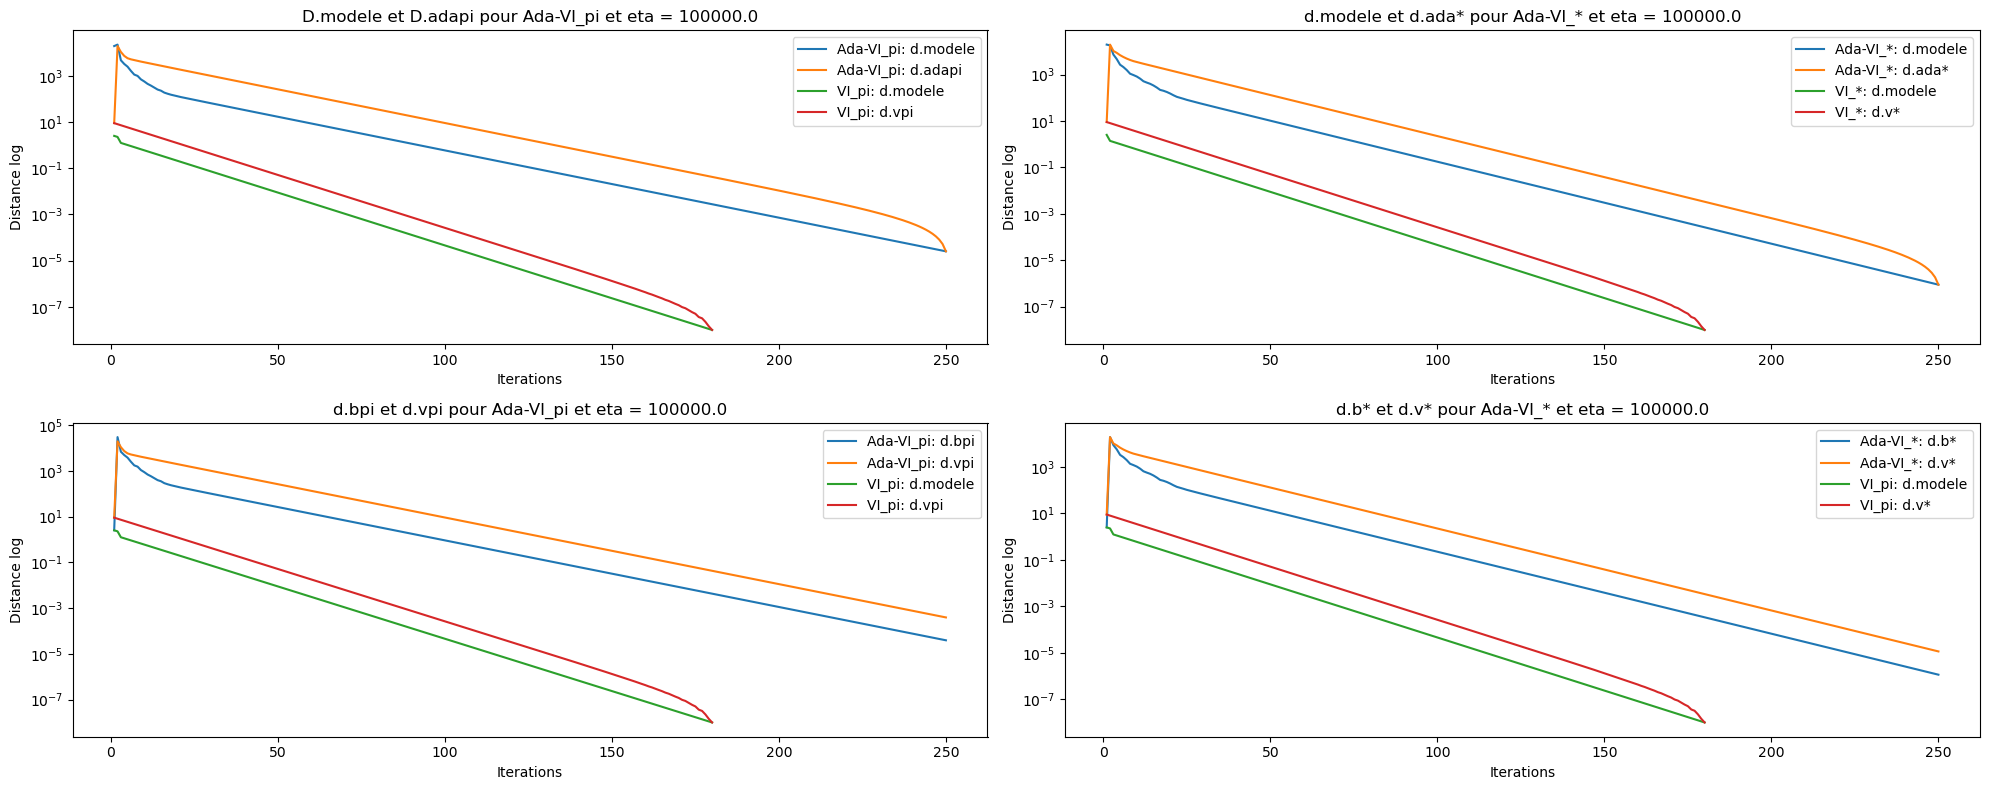

Processing etas: 100%|██████████| 7/7 [03:49<00:00, 32.76s/it]


In [33]:
etas = [1e-3,0.1, 1, 10, 100, 1000, 1e5]
plot_results_blackjack(etas,seuil = 1e-8,num_iterations=250)

On constate que les algorithmes classiques sont au moins aussi efficaces et on note une grande dépendance du comportement des algorithmes $\text{Ada-VI}_\pi^{(\mathrm{V})}$ et $\text{Ada-VI}_*^{(\mathrm{V})}$ par rapport à l'hyperparamètre $\eta$.Lorsque $\eta$ n'est pas correctement calibré, ici pour $\eta = 0.001$ par exemple, alors on constate que l'algorithme ne converge pas suffisamment vers le point fixe.

Lorsque $\eta$ est correctement calibré, ici pour $\eta = 100$, alors on obtient une convergence satisfaisante et un point fixe final très proche de celui obtenu par les algorithmes $\text{VI}_\pi^{(\mathrm{V})}$ et $\text{VI}_*^{(\mathrm{V})}$.Toutefois le coût computationnel est nettement plus élevée pour un nombre d'itérations égal, ce qui tends à favoriser les algorithmes $\text{VI}_\pi^{(\mathrm{V})}$ et $\text{VI}_*^{(\mathrm{V})}$ pour ce cas de figure.

On rejoint les mêmes conclusions que pour le MDP du labyrinthe.


Il est toutefois à rappeler qu'on se donne ici une politique stationnaire basée sur la politique gloutonne à l'initialisation de v, ce qui peut grandement impacter les résultats dans des environnements complexes. Les transitions définies peuvent aussi directement impacter la qualité des résultats obtenus. 
\
\
Ici j'ai opté pour des transitions très généralistes afin d'éviter de réitérer le cas où l'on a déjà tous les meilleurs choix connus via les transitions.

#### $\text{VI}_\pi^{(\mathrm{V})}$, $\text{VI}_*^{(\mathrm{V})}$, $\text{Ada-VI-Comp}_\pi^{(\mathrm{V})}$ et $\text{Ada-VI-Comp}_*^{(\mathrm{V})}$

Processing etas:   0%|          | 0/6 [00:00<?, ?it/s]

Distance finale entre v_pi estimée par VI et v_pi estimée par Ada-VI_Compos_pi pour eta = 0.001 : 8.948452566848715
Distance finale entre v_* estimée par VI et v_* estimée par Ada-VI_Compos_* pour eta = 0.001 : 8.948452566848715


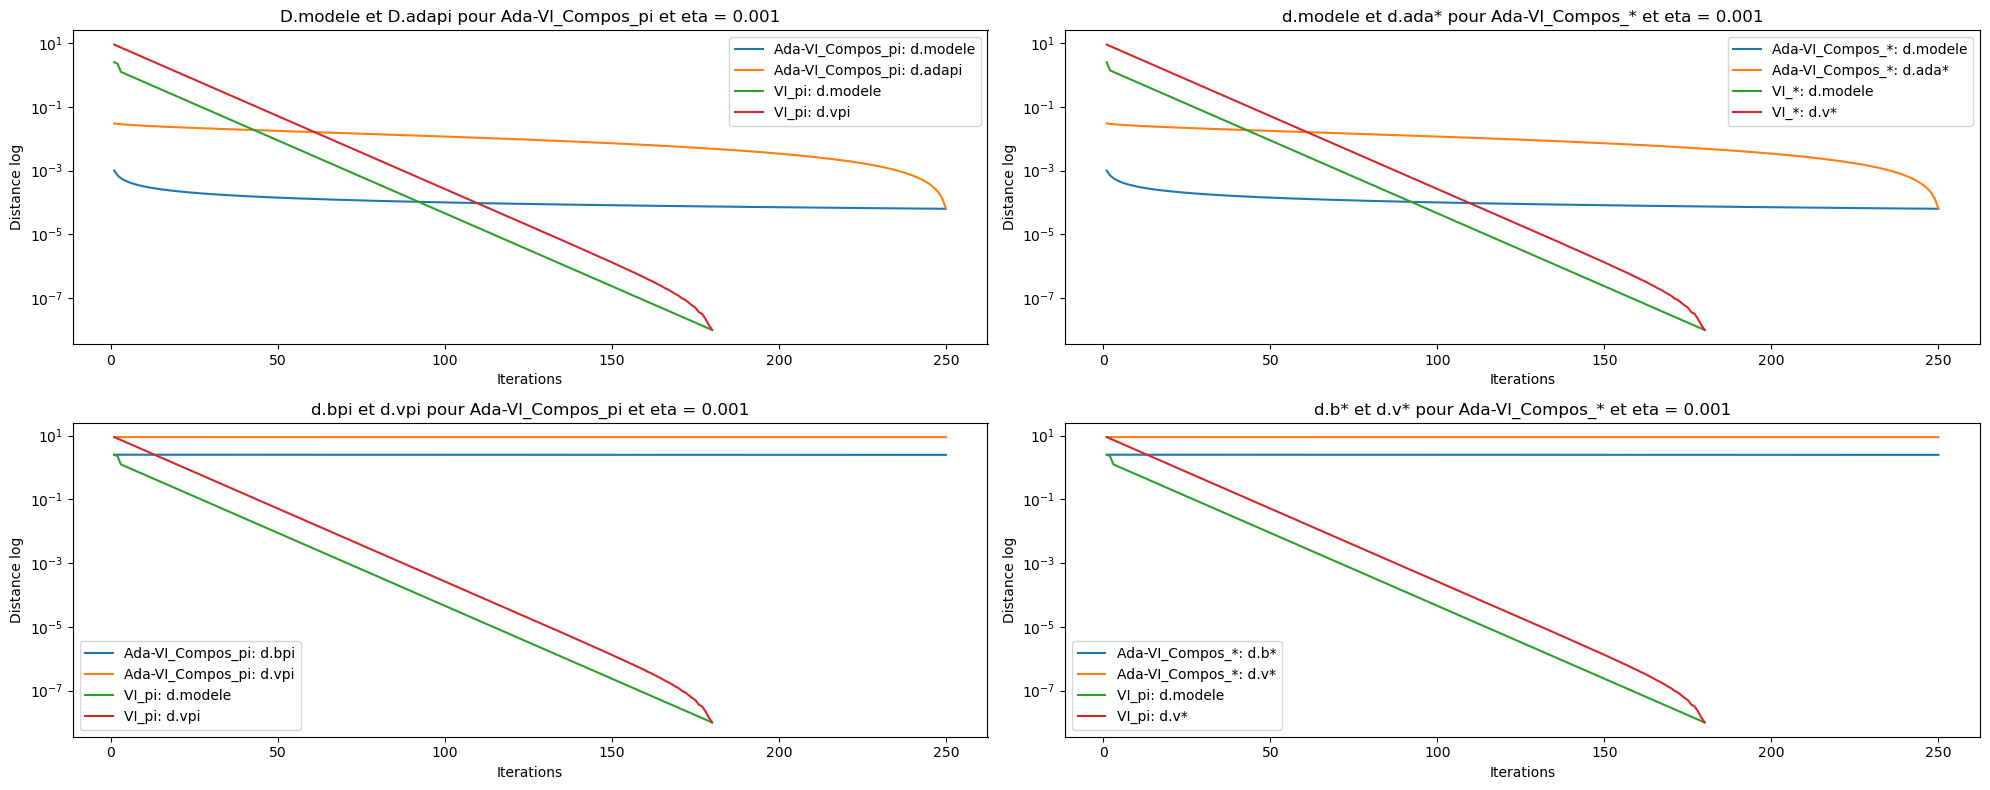

Processing etas:  17%|█▋        | 1/6 [00:50<04:10, 50.06s/it]

Distance finale entre v_pi estimée par VI et v_pi estimée par Ada-VI_Compos_pi pour eta = 0.1 : 6.127446942249389
Distance finale entre v_* estimée par VI et v_* estimée par Ada-VI_Compos_* pour eta = 0.1 : 6.127446942249389


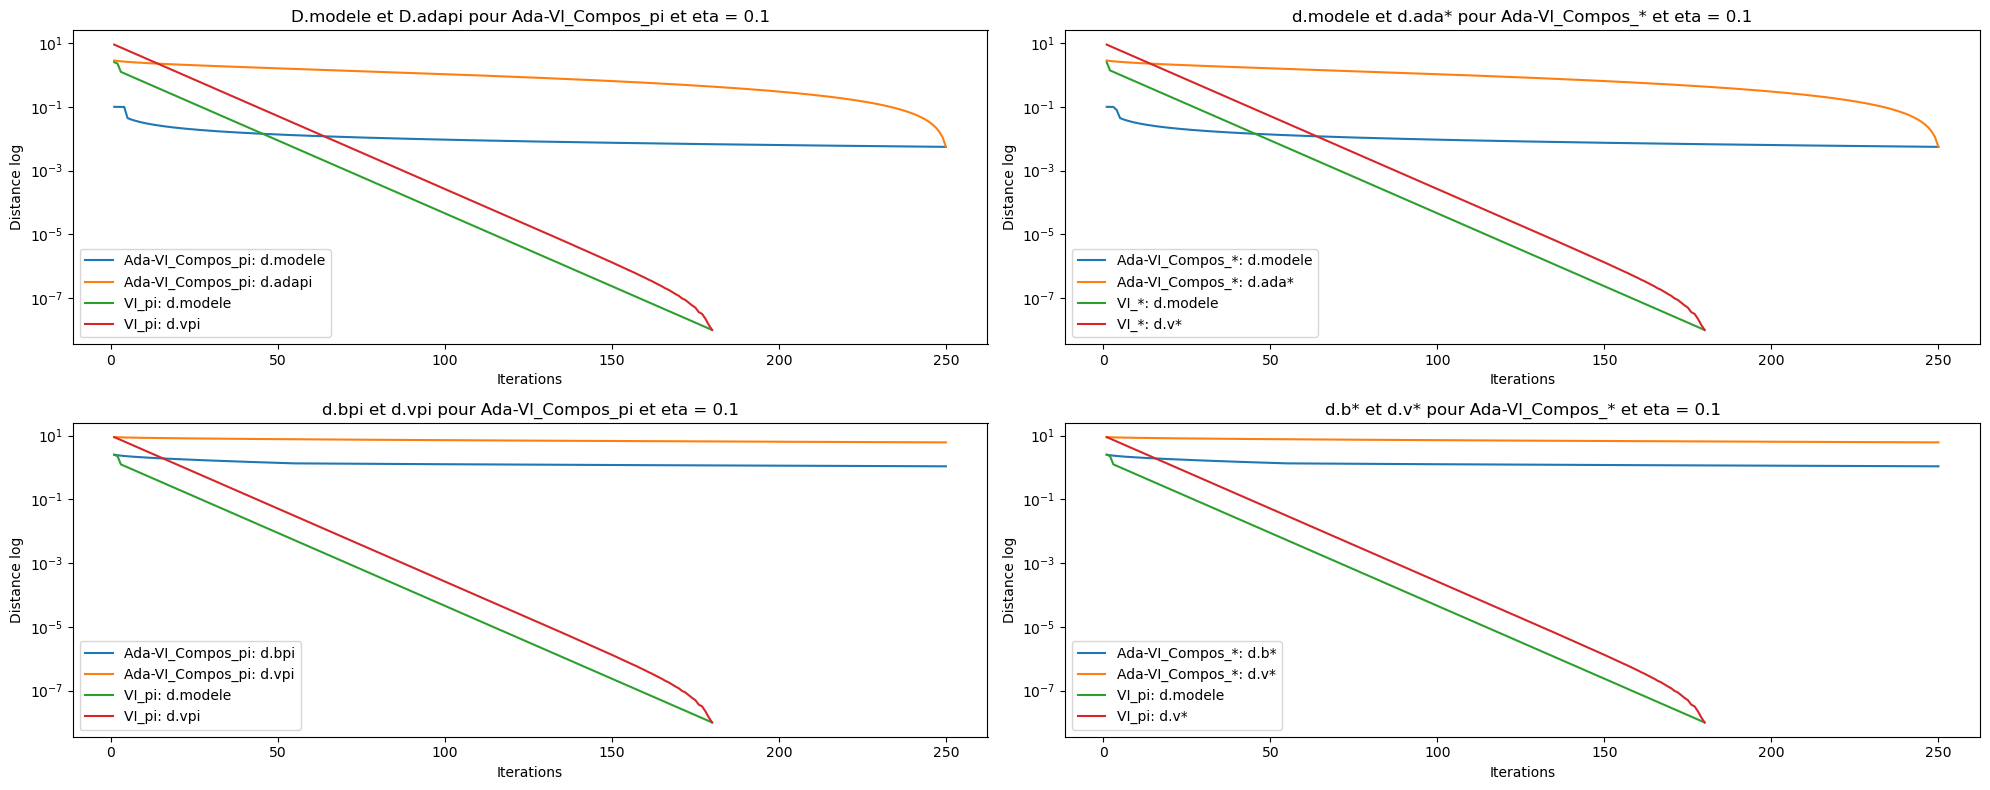

Processing etas:  33%|███▎      | 2/6 [01:44<03:31, 52.87s/it]

Distance finale entre v_pi estimée par VI et v_pi estimée par Ada-VI_Compos_pi pour eta = 1 : 0.00034888668193922
Distance finale entre v_* estimée par VI et v_* estimée par Ada-VI_Compos_* pour eta = 1 : 0.00034888668193922


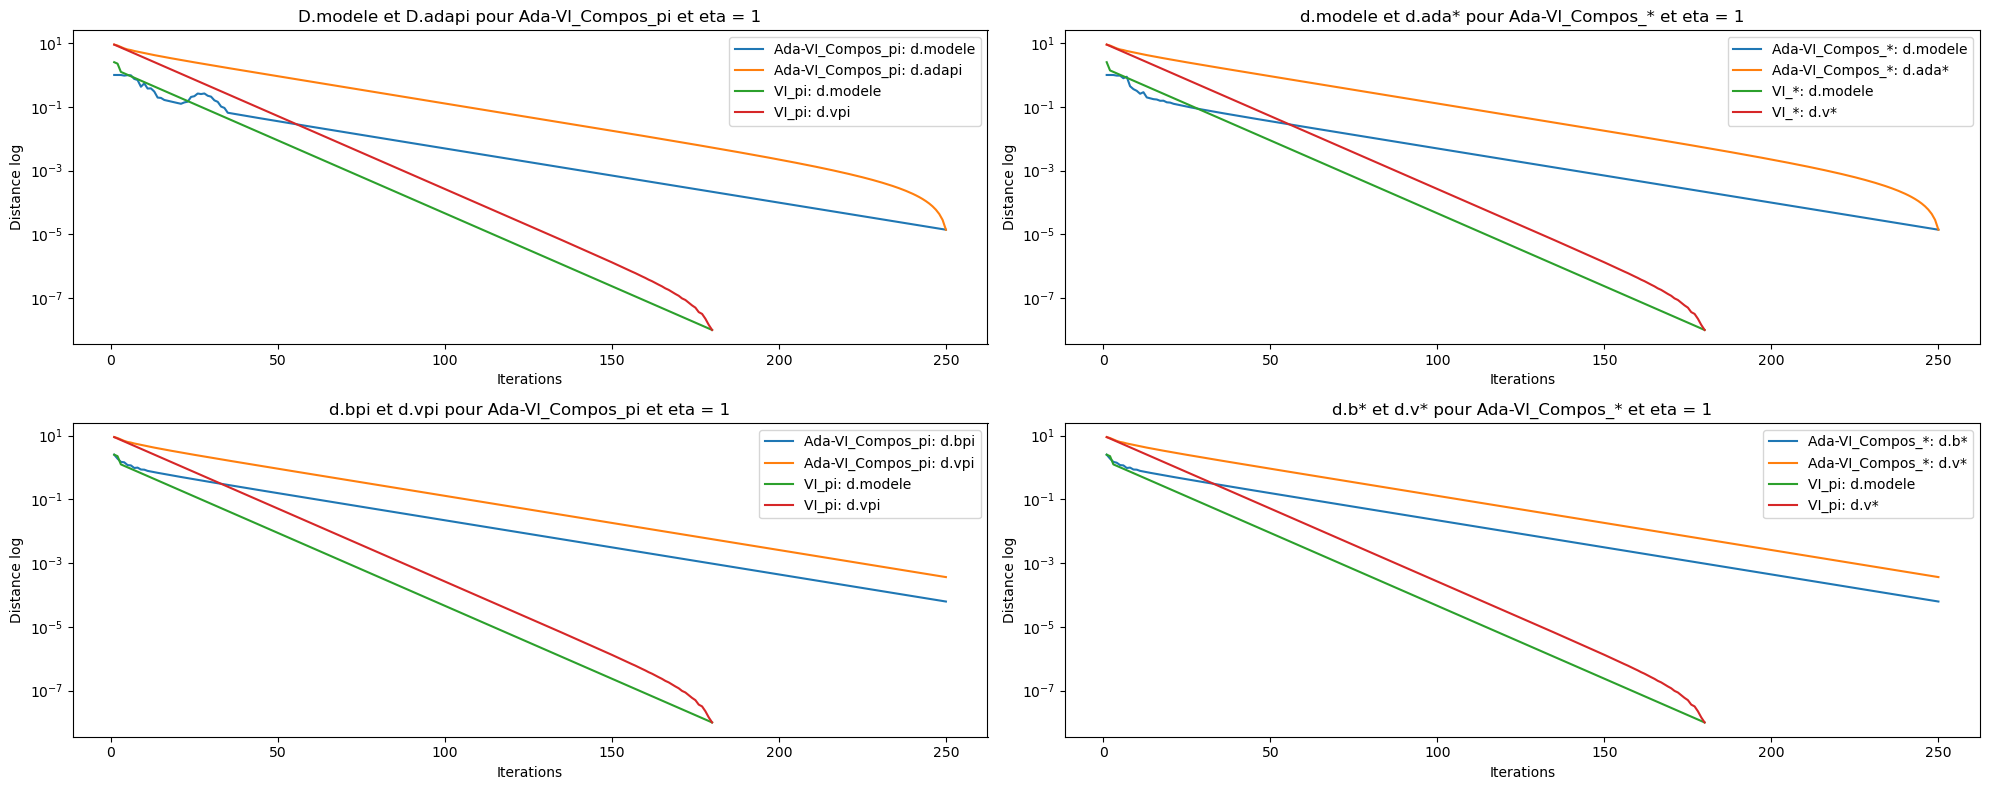

Processing etas:  50%|█████     | 3/6 [02:40<02:42, 54.28s/it]

Distance finale entre v_pi estimée par VI et v_pi estimée par Ada-VI_Compos_pi pour eta = 10 : 9.382199963603455e-07
Distance finale entre v_* estimée par VI et v_* estimée par Ada-VI_Compos_* pour eta = 10 : 1.7767260243939376e-05


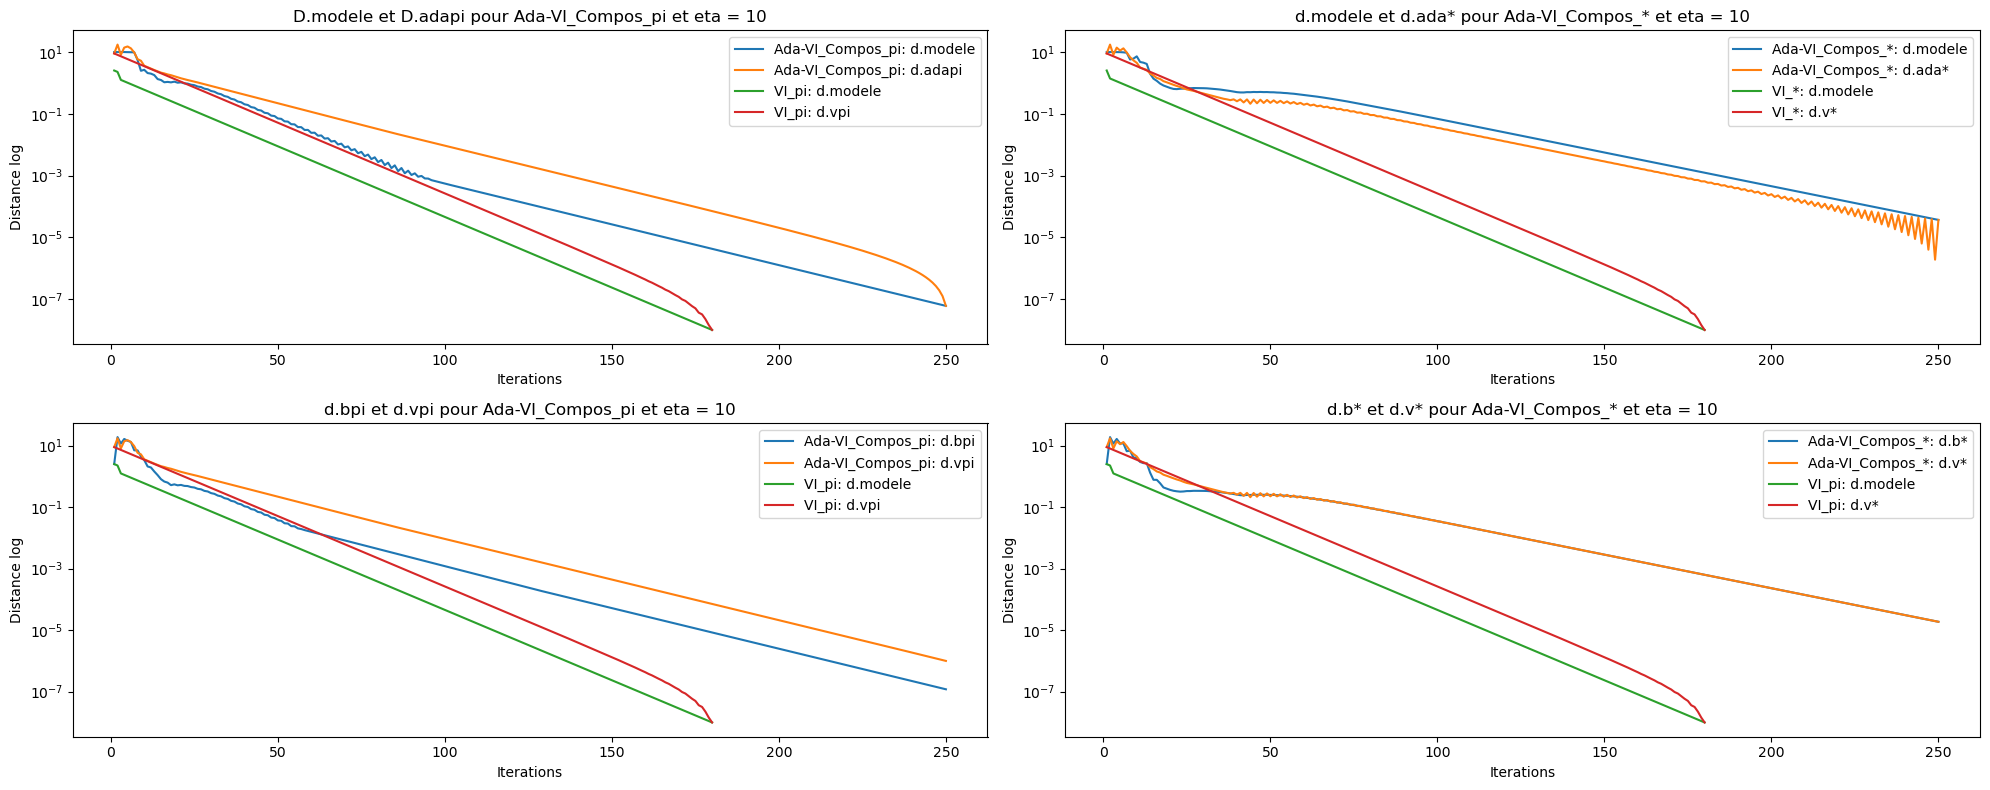

Processing etas:  67%|██████▋   | 4/6 [03:33<01:47, 53.80s/it]

Distance finale entre v_pi estimée par VI et v_pi estimée par Ada-VI_Compos_pi pour eta = 100 : 8.525986052276835e-06
Distance finale entre v_* estimée par VI et v_* estimée par Ada-VI_Compos_* pour eta = 100 : 3.155001794041823e-06


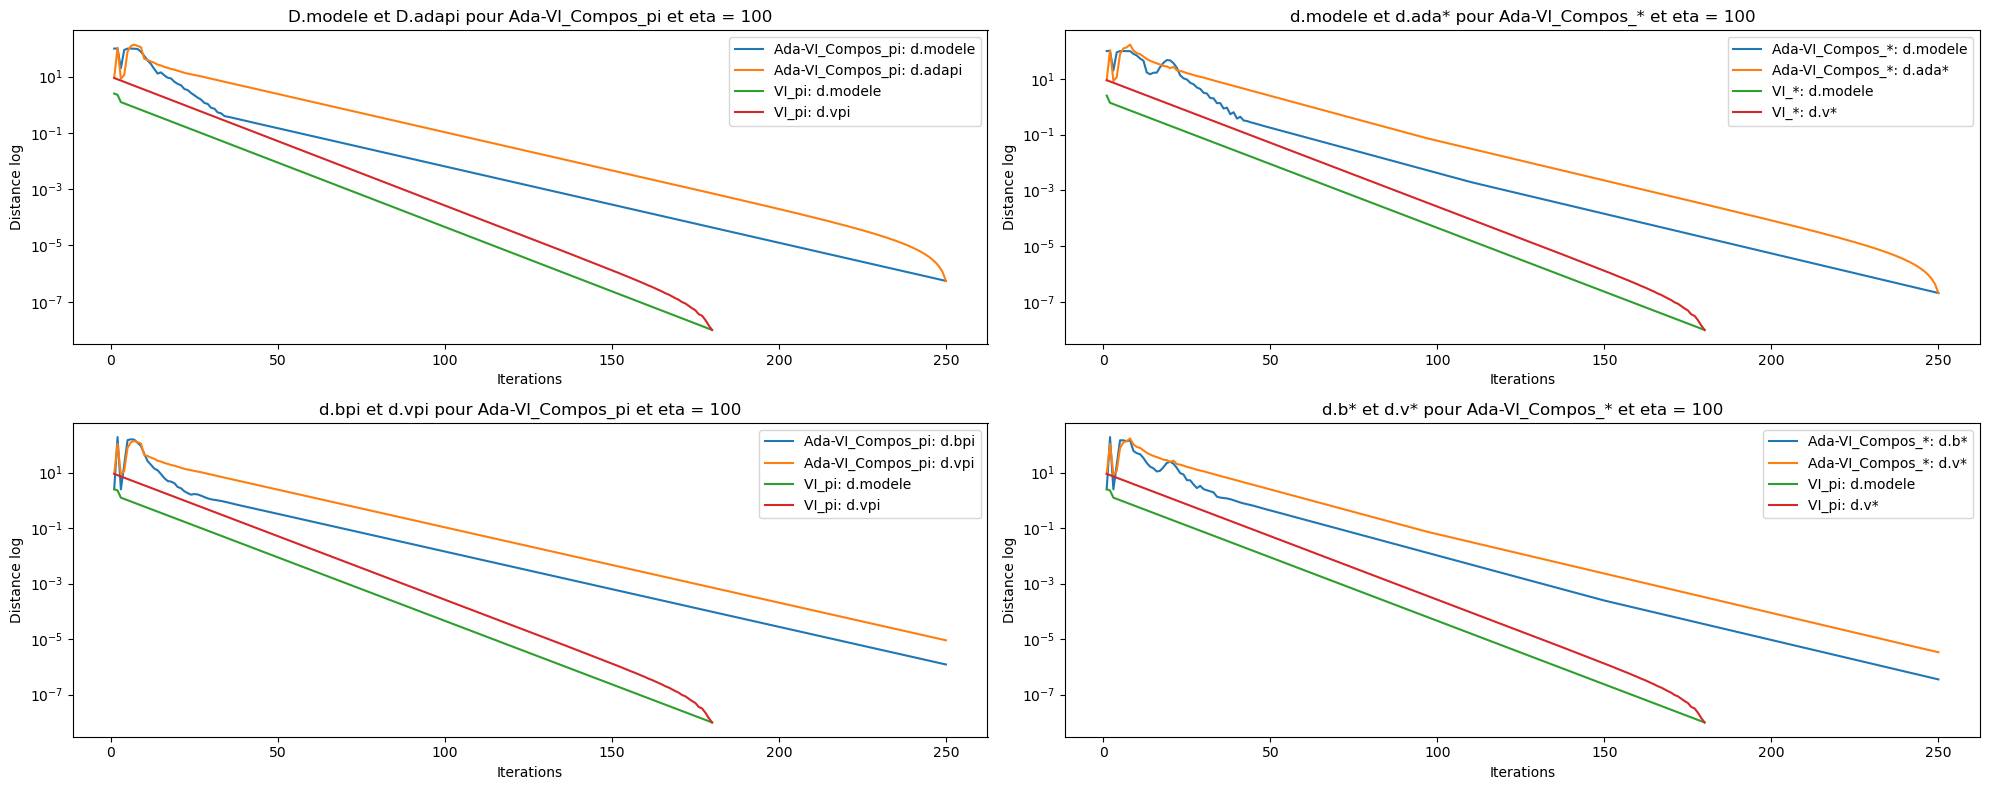

Processing etas:  83%|████████▎ | 5/6 [04:25<00:52, 52.86s/it]

Distance finale entre v_pi estimée par VI et v_pi estimée par Ada-VI_Compos_pi pour eta = 1000 : 5.216751943093456e-05
Distance finale entre v_* estimée par VI et v_* estimée par Ada-VI_Compos_* pour eta = 1000 : 6.736250172778568e-06


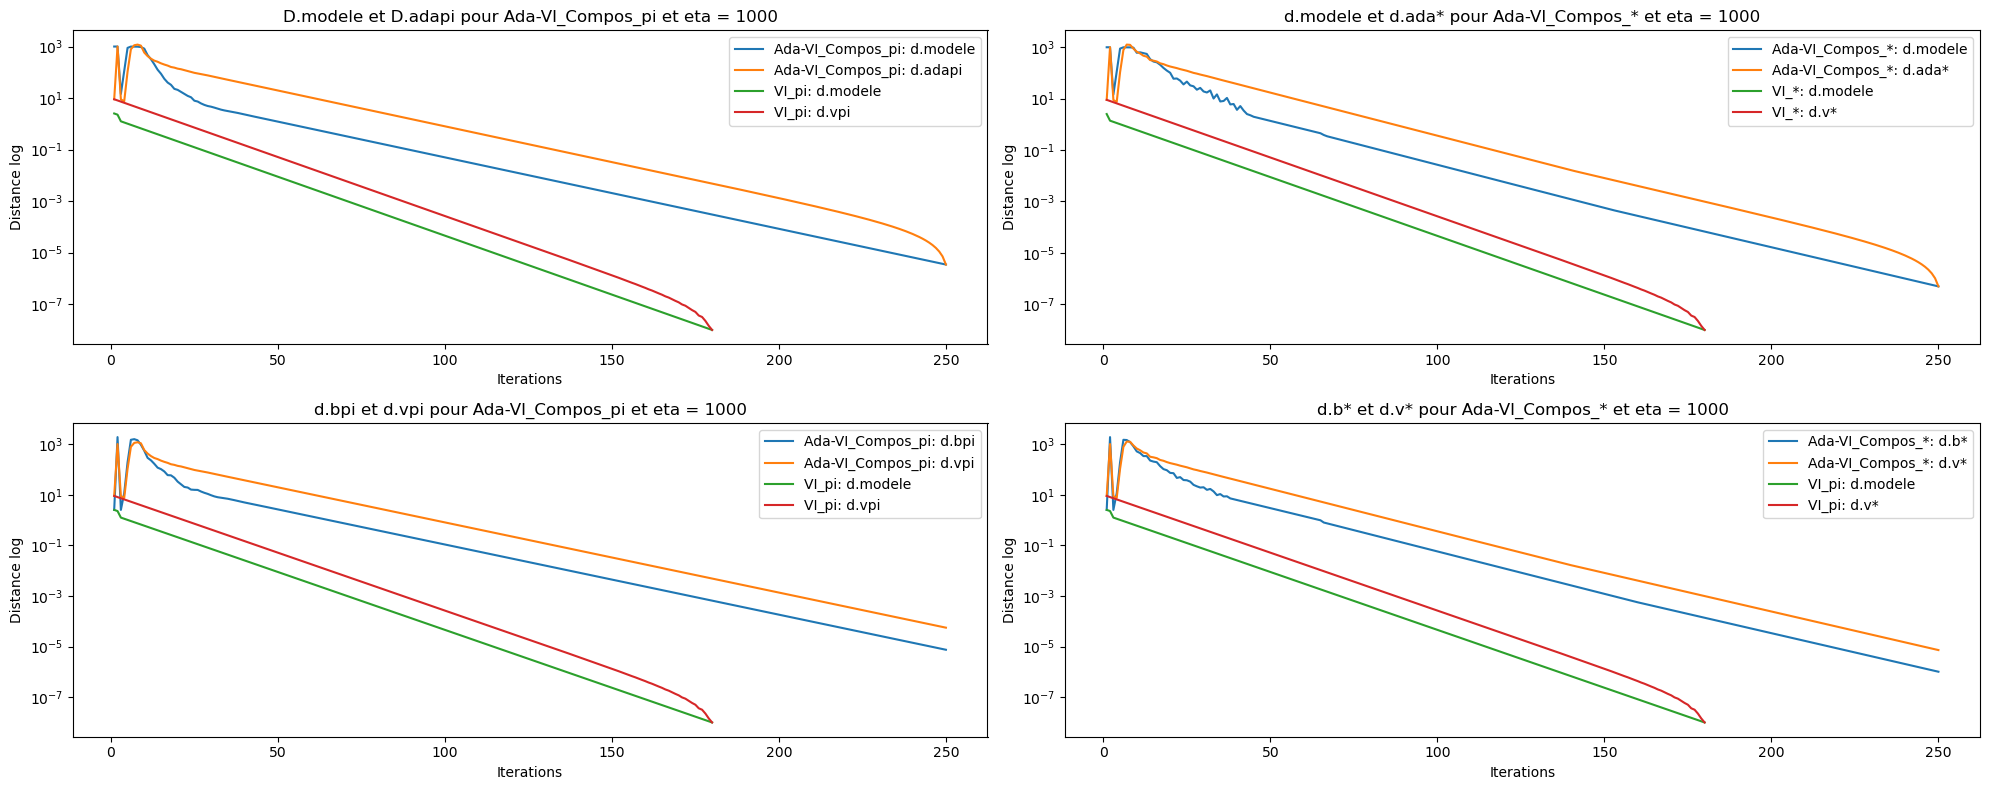

Processing etas: 100%|██████████| 6/6 [05:12<00:00, 52.04s/it]


In [34]:
etas = [1e-3,0.1, 1, 10, 100, 1000]
plot_results_blackjack(etas,seuil = 1e-8,ada_function = Ada_VI_composante_blackjack,num_iterations=250)

Les résultats sont similaires à ceux obtenus pour le labyrinthe, on réitère les mêmes conclusions.

##### Bonus: Animation du jeu de Blackjack

Les cellules suivantes implémentent une représentation visuelle du jeu du BlackJack, on peut ainsi observer plusieurs parties selon la politique qui nous intéresse.

In [35]:
exemple = Ada_VI_composante_blackjack(eta=10)
original_policy = exemple[-1]
final_policy = greedy_policy_blackjack(exemple[-3])

In [36]:
import time
import matplotlib.pyplot as plt
from IPython.display import clear_output

def play_blackjack(policy, number_of_games=5,seed = 0):
    
    # Créer l'environnement Blackjack avec les paramètres spécifiés
    env = gym.make('Blackjack-v1', natural=False, sab=False, render_mode="rgb_array")

    if seed !=0:
        np.random.seed(seed = seed)

    # Réinitialiser l'environnement
    observation = env.reset()
    compteur_reward = 0

    for episode in range(-1, number_of_games):
        print(f"Épisode {episode + 1}")

        # Réinitialiser l'environnement pour un nouvel épisode
        observation = env.reset()
        done = False
        obs = observation[0]

        # Boucle principale de l'épisode
        while not done:
            # Rendre l'environnement en mode "rgb_array"
            rendered_image = env.render()

            # Effacer l'affichage précédent
            clear_output(wait=True)

            # Afficher l'image actuelle
            plt.imshow(rendered_image)
            plt.show()

            # Pause pour rendre l'affichage plus visible (peut être ajustée)
            time.sleep(2.5)

            # Utiliser la politique pour choisir une action
            action = np.copy(policy[obs[0]][obs[1] - 1][obs[2]])

            # Appliquer l'action à l'environnement
            observation = env.step(action)
            obs, reward, done = observation[0], observation[1], observation[2]

        compteur_reward += reward
        time.sleep(2)

    # Afficher le résultat final
    print(f"Jeu terminé. Récompense finale pour les {number_of_games} parties: ", compteur_reward)
    print("")

    env.close()

# Exemple d'utilisation
# Remplacez policy par votre politique réelle
# play_blackjack(policy, number_of_games=5)


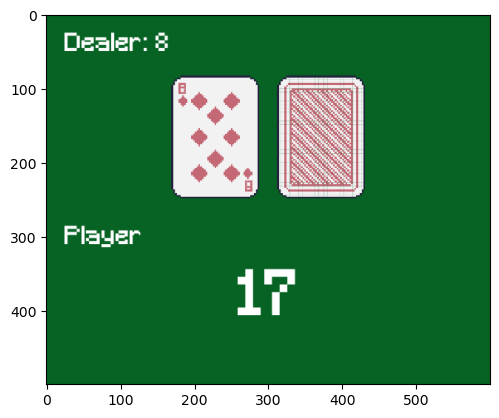

Jeu terminé. Récompense finale pour les 5 parties:  0.0



In [37]:
play_blackjack(final_policy,number_of_games=5,seed=42)

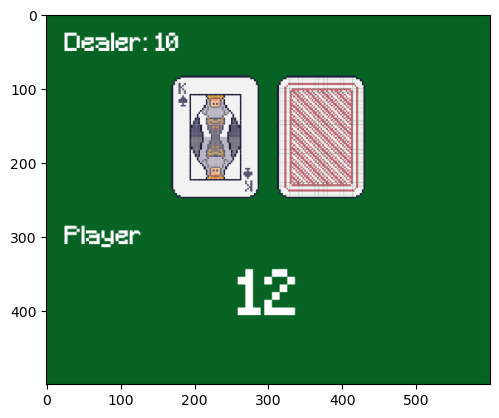

Jeu terminé. Récompense finale pour les 5 parties:  -6.0



In [38]:
play_blackjack(original_policy,number_of_games=5,seed=42)